# Project members

**Sali Raffaele**:
- 📧 [raffaele.sali@studio.unibo.it](mailto:raffaele.sali@studio.unibo.it)
- Student Number: `0001167817`

**Zanotti Niccolò**:
- 📧 [niccolo.zanotti@studio.unibo.it](mailto:niccolo.zanotti@studio.unibo.it)
- Student Number: `0001121646`

**Zocco Ramazzo Marco**:
- 📧 [marco.zoccoramazzo@studio.unibo.it](mailto:marco.zoccoramazzo@studio.unibo.it)
- Student Number: `0001198289`

# Assignment Module 2: Pet Classification

The goal of this assignment is to implement a neural network that classifies images of 37 breeds of cats and dogs from the [Oxford-IIIT-Pet dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). The assignment is divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.

## Setup and dependencies installation

In the following, we will assume that you have
- created a local python virtual environment - either with python [venv](https://docs.python.org/3/library/venv.html) module or via [uv](https://github.com/astral-sh/uv) (preferred) - with the `ipykernel` or `jupyter` packages pre-installed to start the jupyter kernel;
- have `git` installed on your machine;
- have a working internet connection

We will now download the `pyproject.toml` file specifying the project dependencies.

In [1]:
from pathlib import Path


def get_project_root() -> Path:
    """Return the root directory of the project."""
    start_dir = Path.cwd()

    markers = ["assignment2.ipynb"]

    for path in [start_dir, *list(start_dir.parents)]:
        for marker in markers:
            if (path / marker).exists():
                return path

    return start_dir


PROJECT_ROOT: Path = get_project_root()

In [ ]:
import urllib.request

PROJECT_REPO: str = "niccolozanotti/ipcv-assignments"
COMMIT_HASH: str = "9f1f600af59401673e2e816b12d1ae740dc4386b"

pyproject_url = (
    f"https://raw.githubusercontent.com/{PROJECT_REPO}/{COMMIT_HASH}/pyproject.toml"
)
lockfile_url = f"https://raw.githubusercontent.com/{PROJECT_REPO}/{COMMIT_HASH}/uv.lock"

urllib.request.urlretrieve(pyproject_url, PROJECT_ROOT / "pyproject.toml")
urllib.request.urlretrieve(lockfile_url, PROJECT_ROOT / "uv.lock");

If using [uv](https://github.com/astral-sh/uv) (recommended) you can now install the dependencies to a local virtual environment at `.venv` simply via
```sh
uv sync --extra assignment2
```

If not, the same can be achieved with the usual python [venv](https://docs.python.org/3/library/venv.html):
```sh
python3 -m venv .venv
source .venv/bin/activate
(.venv) pip install ".[assignment2]"
```

Make sure to do the above and *restart the kernel* if necessary before proceeding.

In [ ]:
import json
import logging
import shutil
import subprocess
from contextlib import nullcontext  # Allows conditional 'with' statements
from dataclasses import dataclass
from typing import List, Tuple

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from graphviz import Source as draw_diagram
from PIL import Image
from torch import Tensor, nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision.models import ResNet18_Weights
from torchvision.transforms import v2

## Dataset

The following cells contain the code to download and access the dataset you will be using in this assignment. Note that, although this dataset features each and every image from [Oxford-IIIT-Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/), it uses a different train-val-test split than the original authors.

In [ ]:
BRANCH_NAME: str = "dataset/assignment2"
REPO_URL: str = f"https://github.com/{PROJECT_REPO}.git"

temp_dir: Path = PROJECT_ROOT / "temp_repo"
dataset_path: Path = PROJECT_ROOT / "dataset"

if dataset_path.exists():
    print(f"'{dataset_path.name}' folder already exists locally. Skipping download.")
else:
    try:
        print(
            f"Downloading dataset at {PROJECT_REPO}/{BRANCH_NAME} via git sparse checkout..."
        )

        # Clone the repo tree
        clone_cmd = [
            "git",
            "clone",
            "--filter=blob:none",
            "--sparse",
            "--depth",
            "1",
            "--branch",
            BRANCH_NAME,
            REPO_URL,
            str(temp_dir),
        ]
        subprocess.run(clone_cmd, check=True, capture_output=True, text=True)

        # Fetch the contents of the 'dataset' folder
        sparse_cmd = ["git", "-C", str(temp_dir), "sparse-checkout", "set", "dataset"]
        subprocess.run(sparse_cmd, check=True, capture_output=True, text=True)

        source_dataset_path: Path = temp_dir / "dataset"

        if source_dataset_path.exists():
            shutil.move(source_dataset_path, dataset_path)
            print("Dataset successfully downloaded.")
        else:
            print(
                f"Error: Could not find the 'dataset' folder inside the cloned repo at '{temp_dir}'."
            )

    except subprocess.CalledProcessError as e:
        print(f"Git command failed: {e.stderr}")

    finally:
        # Clean up
        if temp_dir.exists():
            shutil.rmtree(temp_dir, ignore_errors=True)

In [ ]:
class OxfordPetDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = dataset_path
        self.split = split
        self.names, self.labels = self._get_names_and_labels()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img_path = self.root / "images" / f"{self.names[idx]}.jpg"
        img = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

    def _get_names_and_labels(self) -> Tuple[List[str], List[int]]:
        names = []
        labels = []

        with open(self.root / "annotations" / f"{self.split}.txt") as f:
            for line in f:
                name, label = line.replace("\n", "").split(" ")
                (names.append(name),)
                labels.append(int(label) - 1)

        return names, labels

In [ ]:
train_dataset1 = OxfordPetDataset(split="train")
print(len(train_dataset1))
img, label = train_dataset1[0]
print(img.size, label)

3669
(300, 225) 0


In [ ]:
def breed_from_name(name):
    return "_".join(name.split("_")[:-1])

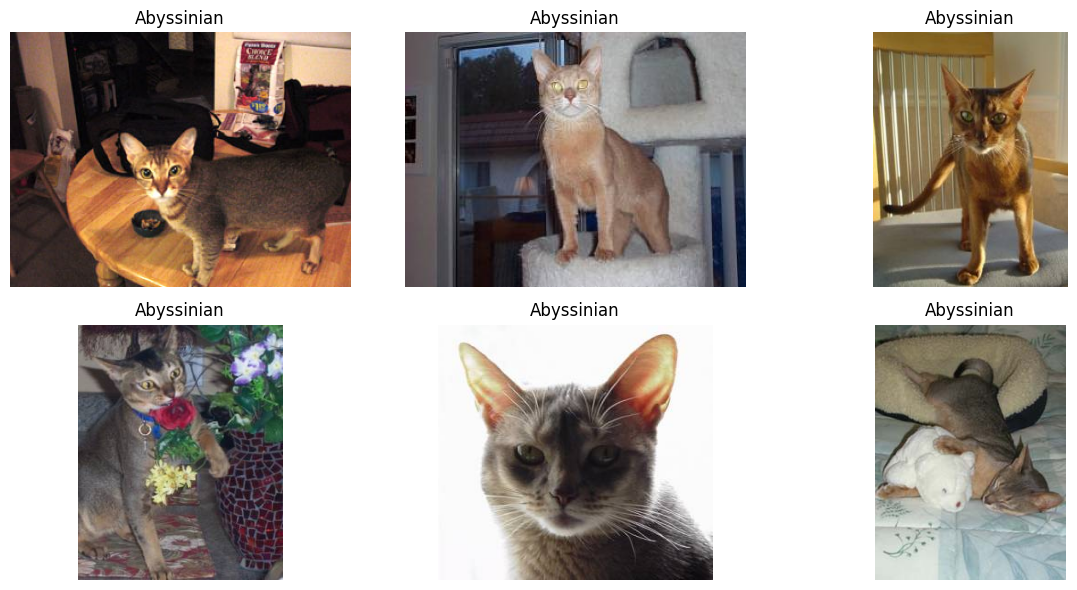

In [ ]:
# Images if we don't apply transformations
plt.figure(figsize=(12, 6))
for i in range(6):
    img, _ = train_dataset1[i]
    name = train_dataset1.names[i]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(breed_from_name(name))
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# Images if we apply transformations
train_transform = T.Compose(
    [
        T.Resize((256, 256)),
        T.RandomCrop(224),
        T.RandomHorizontalFlip(p=0.5),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

val_transform = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset = OxfordPetDataset(split="train", transform=train_transform)
test_dataset = OxfordPetDataset(split="test", transform=val_transform)
validation_dataset = OxfordPetDataset(split="val", transform=val_transform)
print("Number of samples - train:", len(train_dataset))
print("Number of classes - train:", train_dataset.get_num_classes())
print("Number of samples - test:", len(test_dataset))
print("Number of classes - test:", test_dataset.get_num_classes())
print("Number of samples - validation:", len(validation_dataset))
print("Number of classes - validation:", validation_dataset.get_num_classes())

Number of samples - train: 3669
Number of classes - train: 37
Number of samples - test: 1846
Number of classes - test: 37
Number of samples - validation: 1834
Number of classes - validation: 37


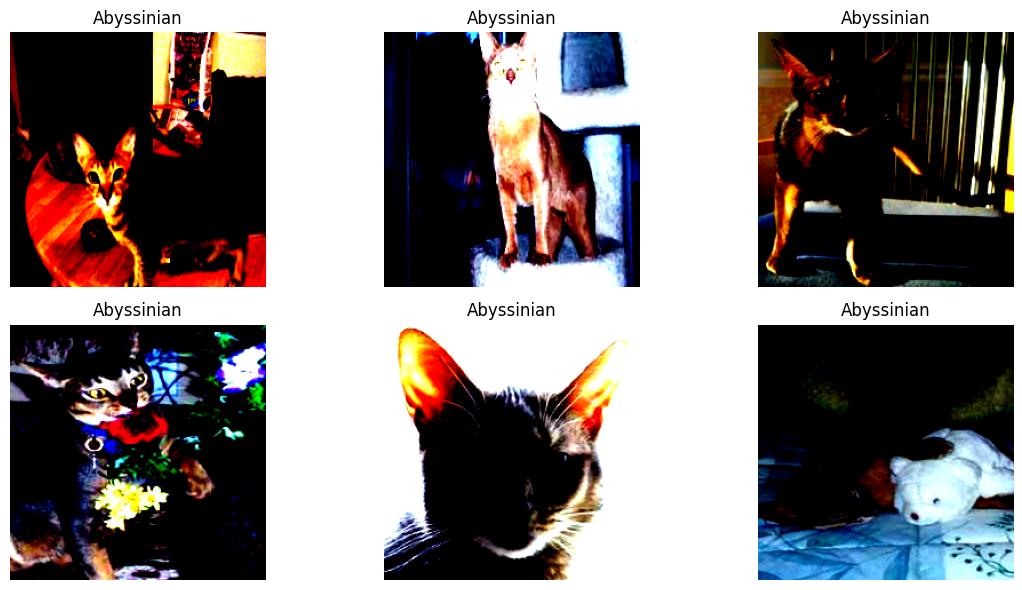

In [ ]:
logging.getLogger("matplotlib").setLevel(logging.ERROR)


def show_samples(dataset, n=6):
    plt.figure(figsize=(12, 6))
    for i in range(n):
        img, _ = dataset[i]
        names = dataset.names[i]
        # label = dataset.labels[i]
        img = img.permute(1, 2, 0)

        plt.subplot(2, n // 2, i + 1)
        plt.imshow(img)
        plt.title(f"{breed_from_name(names)}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


show_samples(train_dataset)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
images, labels = next(iter(train_loader))
print(images.shape)
print(images.min(), images.max())

torch.Size([32, 3, 224, 224])
tensor(-2.1179) tensor(2.6400)


## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it from scratch on `OxfordPetDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~60%. You are free to achieve this however you want, except for a few rules you must follow:

- Compile this notebook by displaying the results obtained by the best model you found throughout your experimentation; then show how, by removing some of its components, its performance drops. In other words, do an *ablation study* to prove that your design choices have a positive impact on the final result.

- Do not instantiate an off-the-self PyTorch network. Instead, construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you cannot use e.g. `torchvision.models.alexnet`.

- Show your results and ablations with plots, tables, images, etc. — the clearer, the better.

Don't be too concerned with your model performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded more points than a poorly experimentally validated model with higher accuracy.

## **NOTE:**
- Several strategies and network architectures were explored, with the main objective of exploiting the components and architectures presented during the course. More advanced networks, such as EfficientNet, were also developed, achieving results very close to those of a simpler ResNet-inspired network. For this reason, the network that better leverages the course topics was ultimately chosen.

## **Common Pipeline**

**Includes:**
- **Accuracy function:** takes into account different output structure when MixUp is employed or not
- **Evaluation function**
- **Residual block class:** defines the structure of the residual blocks, taking into account the presence or not of the Batch Normalization layers
- **Convolutional block class:** defines the structure of the convolutional blocks, which are employed when trying to evidence the impact of Residual blocks
- **Network class:** defines the structure of the CNN, taking into account the use of Stem layers, Batch Normalization layers, Residual layers, Pooling layers and Dropout, to measure the impact of these components
- **TrainConfig class:** defines some core parameters for the training process (like number of epochs, starting learning rate, MixUp parameter, label smoothing factor) and takes into account the use of Label Smoothing, Learning Rate Scheduler and MixUp data augmentation technique
- **build_training_components function:** defines the structure of criterion, optimizer, scheduler and mixup according to boolean and values set in the TrainConfig class
- **Train process function:** defines the pipeline for training the model, minimizing the loss function and updating weights, storing the model with the highest accuracy obtained in validation set

In [ ]:
def accuracy(outputs, labels):
    preds = outputs.argmax(dim=1)

    # If labels are one-hot / soft (MixUp case)
    if labels.ndim == 2:
        labels = labels.argmax(dim=1)

    return (preds == labels).sum()

In [ ]:
def compute_precision_recall_f1(preds, labels, num_classes):
    eps = 1e-8

    precision_list = []
    recall_list = []
    f1_list = []

    for cls in range(num_classes):
        tp = ((preds == cls) & (labels == cls)).sum().float()
        fp = ((preds == cls) & (labels != cls)).sum().float()
        fn = ((preds != cls) & (labels == cls)).sum().float()

        precision = tp / (tp + fp + eps)
        recall = tp / (tp + fn + eps)
        f1 = 2 * precision * recall / (precision + recall + eps)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    return (
        torch.mean(torch.stack(precision_list)).item(),
        torch.mean(torch.stack(recall_list)).item(),
        torch.mean(torch.stack(f1_list)).item(),
    )

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = outputs.argmax(dim=1)

            # Handle one-hot / soft labels
            if labels.ndim == 2:
                labels_hard = labels.argmax(dim=1)
            else:
                labels_hard = labels

            total_loss += loss.item() * labels.size(0)
            total_correct += accuracy(outputs, labels)
            total_samples += labels.size(0)

            all_preds.append(preds)
            all_labels.append(labels_hard)

    avg_loss = total_loss / total_samples
    avg_acc = total_correct.float() / total_samples

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    precision, recall, f1 = compute_precision_recall_f1(
        all_preds, all_labels, num_classes=outputs.size(1)
    )

    return avg_loss, avg_acc.item(), precision, recall, f1

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_batchnorm=True):
        super().__init__()

        norm = nn.BatchNorm2d if use_batchnorm else nn.Identity

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False,
        )
        self.bn1 = norm(out_channels)

        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = norm(out_channels)

        # Skip connection adjustment if shape changes
        self.skip = None
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size=1, stride=stride, bias=False
                ),
                norm(out_channels),
            )

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.skip is not None:
            identity = self.skip(identity)

        out += identity
        return self.relu(out)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_batchnorm=True):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
            nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity(),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.block(x)

In [ ]:
class Net(nn.Module):
    def __init__(
        self,
        n_classes,
        use_stem=True,
        use_residuals=True,
        use_batchnorm=True,
        use_pooling=True,
        use_dropout=True,
    ):
        super().__init__()

        self.use_residuals = use_residuals

        # Stem layers
        if use_stem:
            self.stem = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
            )
        else:
            # Minimal stem: only channel lifting, no downsampling or pooling
            self.stem = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(64) if use_batchnorm else nn.Identity(),
                nn.ReLU(),
            )

        # Residual blocks
        self.stage1 = self._make_stage(
            64, 64, num_blocks=2, stride=1, use_batchnorm=use_batchnorm
        )
        self.stage2 = self._make_stage(
            64, 128, num_blocks=2, stride=2, use_batchnorm=use_batchnorm
        )
        self.stage3 = self._make_stage(
            128, 256, num_blocks=2, stride=2, use_batchnorm=use_batchnorm
        )
        self.stage4 = self._make_stage(
            256, 512, num_blocks=2, stride=2, use_batchnorm=use_batchnorm
        )

        # Classifier and Pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1)) if use_pooling else None
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2) if use_dropout else nn.Identity(),
            nn.Linear(256, n_classes),
        )

    def _make_stage(self, in_channels, out_channels, num_blocks, stride, use_batchnorm):
        if not self.use_residuals:
            # Plain conv blocks instead of residual blocks
            layers = [ConvBlock(in_channels, out_channels, stride, use_batchnorm)]
            for _ in range(1, num_blocks):
                layers.append(ConvBlock(out_channels, out_channels, 1, use_batchnorm))
            return nn.Sequential(*layers)
        else:
            layers = [ResidualBlock(in_channels, out_channels, stride, use_batchnorm)]
            for _ in range(1, num_blocks):
                layers.append(
                    ResidualBlock(
                        out_channels, out_channels, use_batchnorm=use_batchnorm
                    )
                )
            return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)

        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        if self.pool is not None:
            x = self.pool(x)
        else:
            x = x.mean(dim=(2, 3), keepdim=True)

        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [ ]:
@dataclass
class TrainConfig:
    num_epochs: int = 100
    lr: float = 1e-3
    weight_decay: float = 1e-2

    use_scheduler: bool = False
    use_label_smoothing: bool = False
    label_smoothing: float = 0.1

    use_mixup: bool = False
    mixup_alpha: float = 0.2

    save_path: str = None

In [ ]:
class NoMixUp:
    def __call__(self, x, y):
        return x, y

In [ ]:
def build_training_components(model, train_loader, train_dataset, config: TrainConfig):
    criterion = nn.CrossEntropyLoss(
        label_smoothing=config.label_smoothing if config.use_label_smoothing else 0.0
    )

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.lr,
        weight_decay=config.weight_decay,
    )

    scheduler = None
    if config.use_scheduler:
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=config.lr,
            epochs=config.num_epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            anneal_strategy="cos",
        )

    if config.use_mixup:
        mixup = v2.MixUp(
            alpha=config.mixup_alpha,
            num_classes=train_dataset.get_num_classes(),
        )
    else:
        mixup = NoMixUp()

    return criterion, optimizer, scheduler, mixup

`USE_MLFLOW` boolean object determines whether the training metrics, hyperparameters, model architectures, and artifacts across all PyTorch experiments along with system usage metrics [will be logged on the mlflow instance](https://mlflow.org/docs/latest/ml/deep-learning/pytorch/).

All the experiment results are publicly available at https://mlflow.niccolozanotti.com/#/experiments/5/runs logging in as
- username: `guest`
- password: `publicpassword`

In [ ]:
USE_MLFLOW = True

if USE_MLFLOW:
    import mlflow

    mlflow.set_tracking_uri("https://mlflow.niccolozanotti.com")
    mlflow.set_experiment("ipcv-pet-classification-exp")
    print("MLflow logging is ENABLED.")
else:
    print("MLflow logging is DISABLED. Models will be saved locally.")

MLflow logging is ENABLED.


In [ ]:
def train_model(
    model_name,
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    mixup,
    device,
    config,
    use_mlflow=True,
):
    """
    Training loop that conditionally logs to MLflow and returns history.
    Assumes an MLflow run is ALREADY ACTIVE from the calling cell.
    """
    # Initialize history
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": [],
        "lr": [],
    }

    best_val_acc = 0.0

    for epoch in range(config.num_epochs):
        model.train()
        total_loss, total_correct, total_samples = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Apply MixUp if configured
            if config.use_mixup and mixup is not None:
                images, labels = mixup(images, labels)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step()

            total_loss += loss.item() * images.size(0)
            total_correct += accuracy(outputs, labels)
            total_samples += images.size(0)

        # Calculate Epoch Metrics
        train_loss = total_loss / total_samples
        train_acc = total_correct.float() / total_samples

        # Evaluate on Validation Set
        val_loss, val_acc, val_precision, val_recall, val_f1 = evaluate(
            model, val_loader, criterion, device
        )

        current_lr = optimizer.param_groups[0]["lr"]

        # --- Update History Dictionary ---
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc.item())
        history["val_acc"].append(val_acc)
        history["val_precision"].append(val_precision)
        history["val_recall"].append(val_recall)
        history["val_f1"].append(val_f1)
        history["lr"].append(current_lr)

        if use_mlflow:
            # Log metrics to MLflow per epoch
            mlflow.log_metrics(
                {
                    "train_loss": train_loss,
                    "train_acc": train_acc.item(),
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                    "val_precision": val_precision,
                    "val_recall": val_recall,
                    "val_f1": val_f1,
                    "lr": current_lr,
                },
                step=epoch,
            )

        print(
            f"Epoch [{epoch + 1}/{config.num_epochs}] | "
            f"Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.3f} | "
            f"Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f} | LR: {current_lr:.2e}"
        )

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc

            # Standard local save
            if config.save_path is not None:
                torch.save(model.state_dict(), config.save_path)

            if use_mlflow:
                # Uploads the PyTorch model artifact directly to MLflow
                mlflow.pytorch.log_model(model, artifact_path="best_model")

    print(f"[{model_name}] Finished! Best Validation Accuracy: {best_val_acc:.3f}\n")
    return best_val_acc, history

In [ ]:
def plot_accuracy(history):
    plt.figure()
    plt.plot(history["train_acc"])
    plt.plot(history["val_acc"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend(["Train", "Validation"])
    plt.grid(True)
    plt.show()


def plot_loss(history):
    plt.figure()
    plt.plot(history["train_loss"])
    plt.plot(history["val_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend(["Train", "Validation"])
    plt.grid(True)
    plt.show()


def plot_learning_rate(history):
    plt.figure()
    plt.plot(history["lr"])
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Schedule")
    plt.grid(True)
    plt.show()

In [2]:
ABLATION_CSV_PATH: Path = PROJECT_ROOT / "ablation_test_results.csv"
ABLATION_JSON_PATH: Path = PROJECT_ROOT / "ablation_histories.json"

In [ ]:
# Load previous CSV results if available
if ABLATION_CSV_PATH.exists():
    df_results = pd.read_csv(ABLATION_CSV_PATH)
    results = df_results.to_dict(orient="records")
else:
    results = []

# Load previous histories if available
if ABLATION_JSON_PATH.exists():
    with open(ABLATION_JSON_PATH, "r") as f:
        all_histories = json.load(f)
else:
    all_histories = {}

## **Model variant: Full model (baseline)**

**Architecture**
- Convolutional neural network implementing architectures and strategies faced during the course.
- A convolutional stem composed of a three 3×3 convolution (1st with stride=2 and others with stride=1), followed by Batch Normalization, ReLU activation, and max pooling.
- Four sequential stages operating at increasing feature dimensions (64 → 128 → 256 → 512).
- Each stage consists of two residual blocks with identity skip connections.
- When spatial resolution or channel dimensions change, skip connections are adapted using a 1×1 convolution followed by Batch Normalization.
- Global feature aggregation is performed using adaptive average pooling.
- The classifier head consists of two fully connected layers with ReLU activation and dropout.

**Normalization and regularization**
- Batch Normalization is applied after every convolution, including within residual branches and skip connections.
- Dropout is applied in the classifier to reduce overfitting.

**Training setup**
- Optimized using AdamW with weight decay.
- Learning rate scheduling is enabled via OneCycleLR with cosine annealing.
- Cross-entropy loss with label smoothing is used.
- MixUp data augmentation is applied during training.
- Gradient norm clipping is used to improve training stability.

**Purpose**
- This configuration serves as the baseline model against which all ablation studies are compared.


**NOTE:** All ablation variants modify a single component at a time while keeping the remaining architecture and training configuration identical to the baseline model.


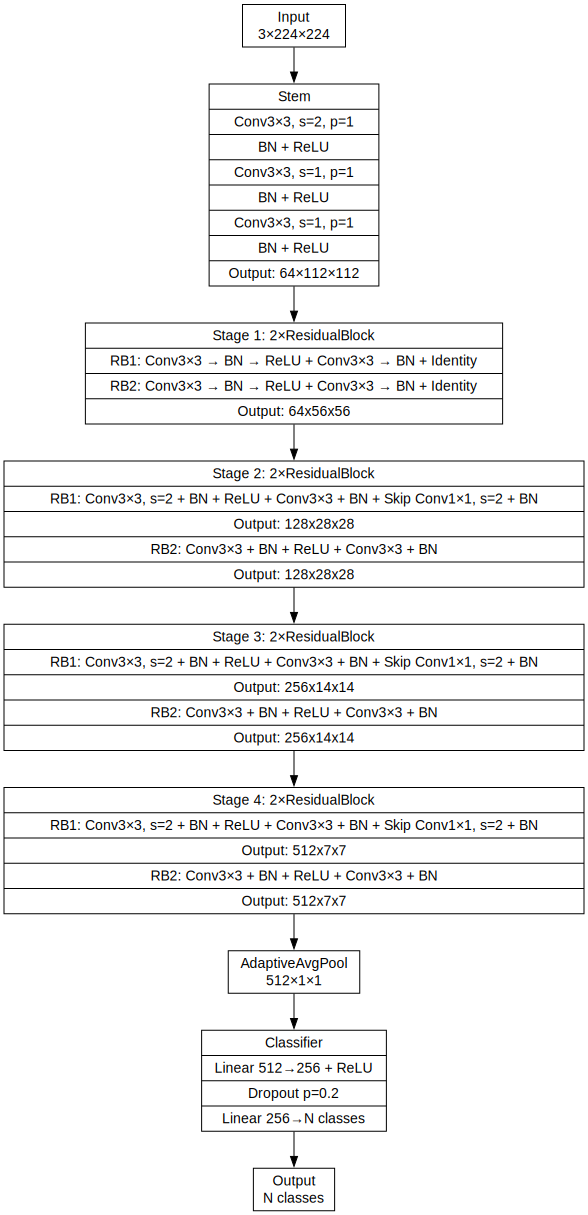

In [ ]:
network_diagram = r"""
digraph ImprovedNet {
    rankdir=TB;
    fontname="Helvetica";
    node [shape=record, fontname="Helvetica"];

    Input [
        label="Input\n3×224×224"
    ];

    Stem [
        label="{Stem|
        Conv3×3, s=2, p=1|
        BN + ReLU|
        Conv3×3, s=1, p=1|
        BN + ReLU|
        Conv3×3, s=1, p=1|
        BN + ReLU|
        Output: 64×112×112}"
    ];

    Stage1 [
        label="{Stage 1:
        2×ResidualBlock|
        RB1:
        Conv3×3 → BN → ReLU +
        Conv3×3 → BN
        + Identity|
        RB2:
        Conv3×3 → BN → ReLU +
        Conv3×3 → BN
        + Identity|
        Output: 64x56x56}"
    ];

    Stage2 [
        label="{Stage 2:
        2×ResidualBlock|
        RB1:
        Conv3×3, s=2 + BN + ReLU +
        Conv3×3 + BN
        + Skip Conv1×1, s=2 + BN|
        Output: 128x28x28|
        RB2:
        Conv3×3 + BN + ReLU +
        Conv3×3 + BN|
        Output: 128x28x28}"
    ];

    Stage3 [
        label="{Stage 3:
        2×ResidualBlock|
        RB1:
        Conv3×3, s=2 + BN + ReLU +
        Conv3×3 + BN
        + Skip Conv1×1, s=2 + BN|
        Output: 256x14x14|
        RB2:
        Conv3×3 + BN + ReLU +
        Conv3×3 + BN|
        Output: 256x14x14}"
    ];

    Stage4 [
        label="{Stage 4:
        2×ResidualBlock|
        RB1:
        Conv3×3, s=2 + BN + ReLU +
        Conv3×3 + BN
        + Skip Conv1×1, s=2 + BN|
        Output: 512x7x7|
        RB2:
        Conv3×3 + BN + ReLU +
        Conv3×3 + BN|
        Output: 512x7x7}"
    ];

    Pool [
        label="AdaptiveAvgPool\n512×1×1"
    ];

    FC [
        label="{Classifier|
        Linear 512→256 + ReLU|
        Dropout p=0.2|
        Linear 256→N classes}"
    ];

    Output [
        label="Output\nN classes"
    ];

    Input -> Stem -> Stage1 -> Stage2 -> Stage3 -> Stage4 -> Pool -> FC -> Output;
}
"""
draw_diagram(network_diagram)

We now choose the right GPU-acceleration backend to speed up our model(s) training. The following code chunk allows for CUDA (NVIDIA chips backend) or MPS (Apple Silicon chips backend) devices with fallback to CPU.
The outputs in this notebook were obtained by running it for $\sim 7$ hours on a [NVIDIA L40 GPU](https://www.nvidia.com/en-us/data-center/l40/). You can find the used sbatch script [here](https://github.com/niccolozanotti/ipcv-assignments/blob/main/scripts/run-task2.sbatch).

In [ ]:
match (torch.cuda.is_available(), torch.backends.mps.is_available()):
    case (True, _):
        device = torch.device("cuda")
    case (False, True):
        device = torch.device("mps")
    case _:
        device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [ ]:
def run_ablation_experiment(
    model_name,
    model_kwargs=None,
    config_kwargs=None,
    custom_train_dataset=None,
    custom_train_loader=None,
):
    """
    Runs a single ablation experiment, handles all MLflow logging,
    local saving, and plotting.
    """
    model_kwargs = model_kwargs or {}
    config_kwargs = config_kwargs or {}

    # Use defaults unless custom ones are provided (for Model 6)
    ds_train = custom_train_dataset if custom_train_dataset else train_dataset
    dl_train = custom_train_loader if custom_train_loader else train_loader

    # 1. Open the MLflow Run
    run_context = mlflow.start_run(run_name=model_name) if USE_MLFLOW else nullcontext()

    with run_context:
        # Initialize model with dynamic arguments
        model = Net(n_classes=ds_train.get_num_classes(), **model_kwargs).to(device)

        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"=== Running: {model_name} ===")
        print(f"Total parameters: {total_params:,} | Trainable: {trainable_params:,}")

        if USE_MLFLOW:
            mlflow.log_param("total_params", total_params)

        # Setup Config with dynamic overrides
        default_config = {
            "use_scheduler": True,
            "use_label_smoothing": True,
            "use_mixup": True,
            "save_path": f"best_{model_name.replace(' ', '_')}.pth",
        }
        default_config.update(
            config_kwargs
        )  # Overwrite defaults with any passed kwargs
        config = TrainConfig(**default_config)

        if USE_MLFLOW:
            mlflow.log_params(vars(config))

        # Build training components
        criterion, optimizer, scheduler, mixup = build_training_components(
            model=model,
            train_loader=dl_train,
            train_dataset=ds_train,
            config=config,
        )

        # 2. Train the model
        best_acc, history = train_model(
            model_name=model_name,
            model=model,
            train_loader=dl_train,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            mixup=mixup,
            device=device,
            config=config,
            use_mlflow=USE_MLFLOW,
        )

        # 3. Load best weights and Evaluate
        model.load_state_dict(torch.load(config.save_path, map_location=device))
        model.to(device)

        test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(
            model, test_loader, criterion, device
        )

        print(f"[{model_name}] Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}")

        # 4. Log to MLflow
        if USE_MLFLOW:
            mlflow.log_metrics(
                {
                    "test_loss": test_loss,
                    "test_accuracy": test_acc,
                    "test_precision": test_prec,
                    "test_recall": test_recall,
                    "test_f1": test_f1,
                }
            )
            mlflow.pytorch.log_model(model, artifact_path="model")

    # --- Local Saving and Plotting ---

    # Update global results list (removes previous run of the same model if it exists)
    global results, all_histories
    results = [r for r in results if r["Model"] != model_name]
    results.append(
        {
            "Model": model_name,
            "Test Loss": test_loss,
            "Test Accuracy": test_acc,
            "Test Precision": test_prec,
            "Test Recall": test_recall,
            "Test F1": test_f1,
        }
    )

    all_histories[model_name] = history

    # Save to disk
    pd.DataFrame(results).round(4).to_csv(ABLATION_CSV_PATH, index=False)
    with open(ABLATION_JSON_PATH, "w") as f:
        json.dump(all_histories, f, indent=4)

    # Plot
    plot_accuracy(history)
    plot_loss(history)
    plot_learning_rate(history)

    return model, history

=== Running: Baseline ===
Total parameters: 11,336,581 | Trainable: 11,336,581


2026/02/16 03:06:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 3.557, Train Acc: 0.055 | Val Loss: 3.551, Val Acc: 0.066 | LR: 6.35e-05


2026/02/16 03:06:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:06:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:07:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [2/100] | Train Loss: 3.480, Train Acc: 0.077 | Val Loss: 3.540, Val Acc: 0.074 | LR: 1.32e-04


2026/02/16 03:07:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:07:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [3/100] | Train Loss: 3.445, Train Acc: 0.088 | Val Loss: 3.919, Val Acc: 0.074 | LR: 2.38e-04


Epoch [4/100] | Train Loss: 3.414, Train Acc: 0.098 | Val Loss: 3.662, Val Acc: 0.074 | LR: 3.72e-04


2026/02/16 03:08:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [5/100] | Train Loss: 3.379, Train Acc: 0.105 | Val Loss: 3.595, Val Acc: 0.075 | LR: 5.21e-04


2026/02/16 03:08:10 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:08:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [6/100] | Train Loss: 3.318, Train Acc: 0.113 | Val Loss: 3.726, Val Acc: 0.065 | LR: 6.69e-04


2026/02/16 03:08:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [7/100] | Train Loss: 3.281, Train Acc: 0.141 | Val Loss: 3.524, Val Acc: 0.101 | LR: 8.03e-04


2026/02/16 03:08:56 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:09:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:09:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [8/100] | Train Loss: 3.205, Train Acc: 0.161 | Val Loss: 3.367, Val Acc: 0.120 | LR: 9.09e-04


2026/02/16 03:09:28 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:09:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:09:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [9/100] | Train Loss: 3.162, Train Acc: 0.164 | Val Loss: 3.285, Val Acc: 0.133 | LR: 9.77e-04


2026/02/16 03:10:00 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:10:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [10/100] | Train Loss: 3.109, Train Acc: 0.194 | Val Loss: 3.353, Val Acc: 0.130 | LR: 1.00e-03


2026/02/16 03:10:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [11/100] | Train Loss: 3.067, Train Acc: 0.202 | Val Loss: 3.315, Val Acc: 0.143 | LR: 1.00e-03


2026/02/16 03:10:47 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:10:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [12/100] | Train Loss: 3.004, Train Acc: 0.241 | Val Loss: 3.959, Val Acc: 0.101 | LR: 9.99e-04


2026/02/16 03:11:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [13/100] | Train Loss: 2.945, Train Acc: 0.248 | Val Loss: 3.404, Val Acc: 0.164 | LR: 9.97e-04


2026/02/16 03:11:33 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:11:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [14/100] | Train Loss: 2.890, Train Acc: 0.266 | Val Loss: 3.224, Val Acc: 0.164 | LR: 9.95e-04


2026/02/16 03:12:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [15/100] | Train Loss: 2.791, Train Acc: 0.288 | Val Loss: 3.278, Val Acc: 0.166 | LR: 9.92e-04


2026/02/16 03:12:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:12:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:12:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [16/100] | Train Loss: 2.793, Train Acc: 0.298 | Val Loss: 2.905, Val Acc: 0.244 | LR: 9.89e-04


2026/02/16 03:12:49 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:12:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [17/100] | Train Loss: 2.708, Train Acc: 0.334 | Val Loss: 2.862, Val Acc: 0.240 | LR: 9.85e-04


2026/02/16 03:13:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [18/100] | Train Loss: 2.709, Train Acc: 0.345 | Val Loss: 2.798, Val Acc: 0.277 | LR: 9.81e-04


2026/02/16 03:13:32 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:13:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [19/100] | Train Loss: 2.613, Train Acc: 0.359 | Val Loss: 3.068, Val Acc: 0.217 | LR: 9.75e-04


2026/02/16 03:14:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [20/100] | Train Loss: 2.622, Train Acc: 0.380 | Val Loss: 2.713, Val Acc: 0.281 | LR: 9.70e-04


2026/02/16 03:14:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:14:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [21/100] | Train Loss: 2.488, Train Acc: 0.405 | Val Loss: 2.911, Val Acc: 0.258 | LR: 9.64e-04


Epoch [22/100] | Train Loss: 2.486, Train Acc: 0.415 | Val Loss: 3.282, Val Acc: 0.197 | LR: 9.57e-04


2026/02/16 03:15:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [23/100] | Train Loss: 2.455, Train Acc: 0.424 | Val Loss: 2.837, Val Acc: 0.302 | LR: 9.49e-04


2026/02/16 03:15:17 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:15:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [24/100] | Train Loss: 2.325, Train Acc: 0.466 | Val Loss: 2.963, Val Acc: 0.244 | LR: 9.41e-04


Epoch [25/100] | Train Loss: 2.371, Train Acc: 0.463 | Val Loss: 2.792, Val Acc: 0.285 | LR: 9.33e-04


2026/02/16 03:16:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [26/100] | Train Loss: 2.218, Train Acc: 0.505 | Val Loss: 2.459, Val Acc: 0.347 | LR: 9.24e-04


2026/02/16 03:16:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:16:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:16:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [27/100] | Train Loss: 2.279, Train Acc: 0.488 | Val Loss: 2.439, Val Acc: 0.372 | LR: 9.14e-04


2026/02/16 03:16:48 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:16:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:17:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [28/100] | Train Loss: 2.231, Train Acc: 0.521 | Val Loss: 2.307, Val Acc: 0.445 | LR: 9.04e-04


2026/02/16 03:17:19 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:17:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:17:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [29/100] | Train Loss: 2.143, Train Acc: 0.553 | Val Loss: 2.231, Val Acc: 0.454 | LR: 8.94e-04


2026/02/16 03:17:52 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:17:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:18:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [30/100] | Train Loss: 2.129, Train Acc: 0.561 | Val Loss: 2.204, Val Acc: 0.473 | LR: 8.83e-04


2026/02/16 03:18:22 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:18:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [31/100] | Train Loss: 2.064, Train Acc: 0.580 | Val Loss: 2.341, Val Acc: 0.421 | LR: 8.71e-04


2026/02/16 03:19:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [32/100] | Train Loss: 2.112, Train Acc: 0.590 | Val Loss: 2.135, Val Acc: 0.488 | LR: 8.60e-04


2026/02/16 03:19:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:19:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [33/100] | Train Loss: 1.979, Train Acc: 0.623 | Val Loss: 2.517, Val Acc: 0.377 | LR: 8.47e-04


Epoch [34/100] | Train Loss: 2.041, Train Acc: 0.617 | Val Loss: 2.398, Val Acc: 0.396 | LR: 8.34e-04


Epoch [35/100] | Train Loss: 2.008, Train Acc: 0.622 | Val Loss: 2.107, Val Acc: 0.482 | LR: 8.21e-04


2026/02/16 03:20:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [36/100] | Train Loss: 1.889, Train Acc: 0.669 | Val Loss: 2.044, Val Acc: 0.508 | LR: 8.08e-04


2026/02/16 03:20:24 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:20:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [37/100] | Train Loss: 1.887, Train Acc: 0.651 | Val Loss: 2.140, Val Acc: 0.485 | LR: 7.94e-04


Epoch [38/100] | Train Loss: 1.967, Train Acc: 0.660 | Val Loss: 2.112, Val Acc: 0.491 | LR: 7.79e-04


Epoch [39/100] | Train Loss: 1.847, Train Acc: 0.690 | Val Loss: 2.092, Val Acc: 0.508 | LR: 7.65e-04


Epoch [40/100] | Train Loss: 1.873, Train Acc: 0.690 | Val Loss: 2.140, Val Acc: 0.489 | LR: 7.50e-04


Epoch [41/100] | Train Loss: 1.900, Train Acc: 0.696 | Val Loss: 2.186, Val Acc: 0.467 | LR: 7.35e-04


2026/02/16 03:22:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [42/100] | Train Loss: 1.807, Train Acc: 0.718 | Val Loss: 1.970, Val Acc: 0.534 | LR: 7.19e-04


2026/02/16 03:22:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:22:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:22:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [43/100] | Train Loss: 1.825, Train Acc: 0.702 | Val Loss: 1.885, Val Acc: 0.561 | LR: 7.03e-04


2026/02/16 03:22:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:22:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [44/100] | Train Loss: 1.804, Train Acc: 0.703 | Val Loss: 1.993, Val Acc: 0.547 | LR: 6.87e-04


2026/02/16 03:23:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [45/100] | Train Loss: 1.760, Train Acc: 0.733 | Val Loss: 1.856, Val Acc: 0.589 | LR: 6.71e-04


2026/02/16 03:23:20 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:23:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [46/100] | Train Loss: 1.771, Train Acc: 0.743 | Val Loss: 2.016, Val Acc: 0.516 | LR: 6.54e-04


Epoch [47/100] | Train Loss: 1.750, Train Acc: 0.754 | Val Loss: 2.214, Val Acc: 0.461 | LR: 6.38e-04


Epoch [48/100] | Train Loss: 1.606, Train Acc: 0.790 | Val Loss: 1.867, Val Acc: 0.563 | LR: 6.21e-04


Epoch [49/100] | Train Loss: 1.615, Train Acc: 0.783 | Val Loss: 2.076, Val Acc: 0.511 | LR: 6.04e-04


Epoch [50/100] | Train Loss: 1.681, Train Acc: 0.766 | Val Loss: 1.964, Val Acc: 0.549 | LR: 5.87e-04


2026/02/16 03:25:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [51/100] | Train Loss: 1.758, Train Acc: 0.760 | Val Loss: 1.783, Val Acc: 0.618 | LR: 5.69e-04


2026/02/16 03:25:06 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:25:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [52/100] | Train Loss: 1.720, Train Acc: 0.781 | Val Loss: 1.779, Val Acc: 0.613 | LR: 5.52e-04


Epoch [53/100] | Train Loss: 1.614, Train Acc: 0.808 | Val Loss: 1.827, Val Acc: 0.594 | LR: 5.35e-04


Epoch [54/100] | Train Loss: 1.523, Train Acc: 0.819 | Val Loss: 1.819, Val Acc: 0.592 | LR: 5.17e-04


Epoch [55/100] | Train Loss: 1.565, Train Acc: 0.835 | Val Loss: 1.806, Val Acc: 0.603 | LR: 5.00e-04


2026/02/16 03:26:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [56/100] | Train Loss: 1.610, Train Acc: 0.829 | Val Loss: 1.749, Val Acc: 0.637 | LR: 4.82e-04


2026/02/16 03:26:40 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:26:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [57/100] | Train Loss: 1.438, Train Acc: 0.857 | Val Loss: 1.850, Val Acc: 0.581 | LR: 4.65e-04


Epoch [58/100] | Train Loss: 1.545, Train Acc: 0.849 | Val Loss: 1.750, Val Acc: 0.623 | LR: 4.48e-04


Epoch [59/100] | Train Loss: 1.492, Train Acc: 0.858 | Val Loss: 1.804, Val Acc: 0.605 | LR: 4.30e-04


2026/02/16 03:27:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [60/100] | Train Loss: 1.564, Train Acc: 0.839 | Val Loss: 1.649, Val Acc: 0.660 | LR: 4.13e-04


2026/02/16 03:27:58 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:28:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [61/100] | Train Loss: 1.504, Train Acc: 0.858 | Val Loss: 1.718, Val Acc: 0.639 | LR: 3.96e-04


Epoch [62/100] | Train Loss: 1.359, Train Acc: 0.885 | Val Loss: 1.732, Val Acc: 0.643 | LR: 3.79e-04


Epoch [63/100] | Train Loss: 1.430, Train Acc: 0.878 | Val Loss: 1.706, Val Acc: 0.646 | LR: 3.62e-04


Epoch [64/100] | Train Loss: 1.475, Train Acc: 0.877 | Val Loss: 1.670, Val Acc: 0.646 | LR: 3.45e-04


Epoch [65/100] | Train Loss: 1.383, Train Acc: 0.893 | Val Loss: 1.656, Val Acc: 0.659 | LR: 3.29e-04


2026/02/16 03:29:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [66/100] | Train Loss: 1.383, Train Acc: 0.901 | Val Loss: 1.659, Val Acc: 0.660 | LR: 3.13e-04


2026/02/16 03:29:45 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:29:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:30:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [67/100] | Train Loss: 1.470, Train Acc: 0.879 | Val Loss: 1.608, Val Acc: 0.677 | LR: 2.96e-04


2026/02/16 03:30:17 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:30:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [68/100] | Train Loss: 1.376, Train Acc: 0.896 | Val Loss: 1.683, Val Acc: 0.650 | LR: 2.81e-04


Epoch [69/100] | Train Loss: 1.430, Train Acc: 0.893 | Val Loss: 1.645, Val Acc: 0.655 | LR: 2.65e-04


2026/02/16 03:31:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [70/100] | Train Loss: 1.313, Train Acc: 0.907 | Val Loss: 1.574, Val Acc: 0.687 | LR: 2.50e-04


2026/02/16 03:31:21 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:31:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [71/100] | Train Loss: 1.460, Train Acc: 0.894 | Val Loss: 1.604, Val Acc: 0.679 | LR: 2.35e-04


Epoch [72/100] | Train Loss: 1.372, Train Acc: 0.905 | Val Loss: 1.623, Val Acc: 0.682 | LR: 2.20e-04


2026/02/16 03:32:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [73/100] | Train Loss: 1.337, Train Acc: 0.922 | Val Loss: 1.568, Val Acc: 0.689 | LR: 2.06e-04


2026/02/16 03:32:22 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:32:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:32:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [74/100] | Train Loss: 1.324, Train Acc: 0.928 | Val Loss: 1.539, Val Acc: 0.704 | LR: 1.92e-04


2026/02/16 03:32:54 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:32:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [75/100] | Train Loss: 1.437, Train Acc: 0.911 | Val Loss: 1.596, Val Acc: 0.685 | LR: 1.78e-04


Epoch [76/100] | Train Loss: 1.460, Train Acc: 0.906 | Val Loss: 1.602, Val Acc: 0.672 | LR: 1.65e-04


Epoch [77/100] | Train Loss: 1.347, Train Acc: 0.918 | Val Loss: 1.600, Val Acc: 0.687 | LR: 1.53e-04


Epoch [78/100] | Train Loss: 1.381, Train Acc: 0.922 | Val Loss: 1.564, Val Acc: 0.696 | LR: 1.40e-04


2026/02/16 03:34:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [79/100] | Train Loss: 1.247, Train Acc: 0.946 | Val Loss: 1.535, Val Acc: 0.708 | LR: 1.28e-04


2026/02/16 03:34:25 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:34:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [80/100] | Train Loss: 1.236, Train Acc: 0.931 | Val Loss: 1.565, Val Acc: 0.699 | LR: 1.17e-04


2026/02/16 03:35:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [81/100] | Train Loss: 1.257, Train Acc: 0.929 | Val Loss: 1.544, Val Acc: 0.711 | LR: 1.06e-04


2026/02/16 03:35:11 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:35:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [82/100] | Train Loss: 1.309, Train Acc: 0.936 | Val Loss: 1.525, Val Acc: 0.702 | LR: 9.54e-05


Epoch [83/100] | Train Loss: 1.253, Train Acc: 0.942 | Val Loss: 1.558, Val Acc: 0.703 | LR: 8.54e-05


Epoch [84/100] | Train Loss: 1.393, Train Acc: 0.918 | Val Loss: 1.561, Val Acc: 0.707 | LR: 7.59e-05


2026/02/16 03:36:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [85/100] | Train Loss: 1.312, Train Acc: 0.950 | Val Loss: 1.526, Val Acc: 0.712 | LR: 6.69e-05


2026/02/16 03:36:28 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:36:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:36:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [86/100] | Train Loss: 1.265, Train Acc: 0.942 | Val Loss: 1.516, Val Acc: 0.714 | LR: 5.85e-05


2026/02/16 03:37:00 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:37:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [87/100] | Train Loss: 1.333, Train Acc: 0.938 | Val Loss: 1.514, Val Acc: 0.707 | LR: 5.05e-05


Epoch [88/100] | Train Loss: 1.273, Train Acc: 0.947 | Val Loss: 1.529, Val Acc: 0.713 | LR: 4.32e-05


Epoch [89/100] | Train Loss: 1.318, Train Acc: 0.933 | Val Loss: 1.543, Val Acc: 0.713 | LR: 3.64e-05


Epoch [90/100] | Train Loss: 1.392, Train Acc: 0.922 | Val Loss: 1.551, Val Acc: 0.709 | LR: 3.01e-05


2026/02/16 03:38:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [91/100] | Train Loss: 1.272, Train Acc: 0.943 | Val Loss: 1.522, Val Acc: 0.714 | LR: 2.44e-05


2026/02/16 03:38:31 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:38:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:38:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [92/100] | Train Loss: 1.331, Train Acc: 0.928 | Val Loss: 1.526, Val Acc: 0.720 | LR: 1.93e-05


2026/02/16 03:39:03 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:39:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [93/100] | Train Loss: 1.213, Train Acc: 0.942 | Val Loss: 1.545, Val Acc: 0.709 | LR: 1.48e-05


Epoch [94/100] | Train Loss: 1.317, Train Acc: 0.931 | Val Loss: 1.531, Val Acc: 0.707 | LR: 1.09e-05


Epoch [95/100] | Train Loss: 1.260, Train Acc: 0.947 | Val Loss: 1.519, Val Acc: 0.714 | LR: 7.57e-06


Epoch [96/100] | Train Loss: 1.245, Train Acc: 0.952 | Val Loss: 1.512, Val Acc: 0.715 | LR: 4.85e-06


Epoch [97/100] | Train Loss: 1.270, Train Acc: 0.939 | Val Loss: 1.527, Val Acc: 0.712 | LR: 2.73e-06


Epoch [98/100] | Train Loss: 1.211, Train Acc: 0.945 | Val Loss: 1.505, Val Acc: 0.719 | LR: 1.21e-06


Epoch [99/100] | Train Loss: 1.273, Train Acc: 0.931 | Val Loss: 1.520, Val Acc: 0.713 | LR: 3.03e-07


Epoch [100/100] | Train Loss: 1.246, Train Acc: 0.942 | Val Loss: 1.513, Val Acc: 0.719 | LR: 4.02e-09
[Baseline] Finished! Best Validation Accuracy: 0.720



[Baseline] Test Loss: 1.446 | Test Acc: 0.749


2026/02/16 03:41:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 03:41:28 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:41:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run Baseline at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/b7043c90861140a8bc5cd55cda1cdd67
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


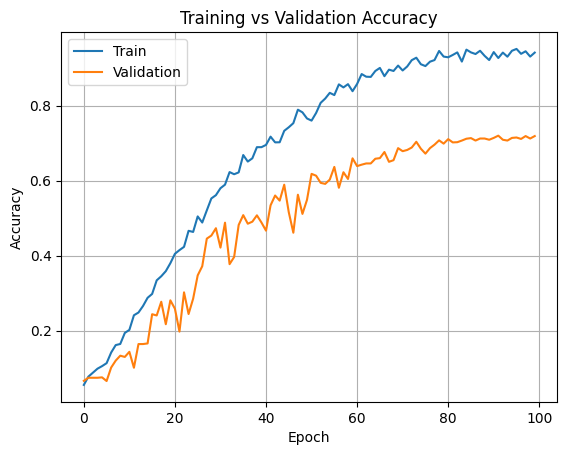

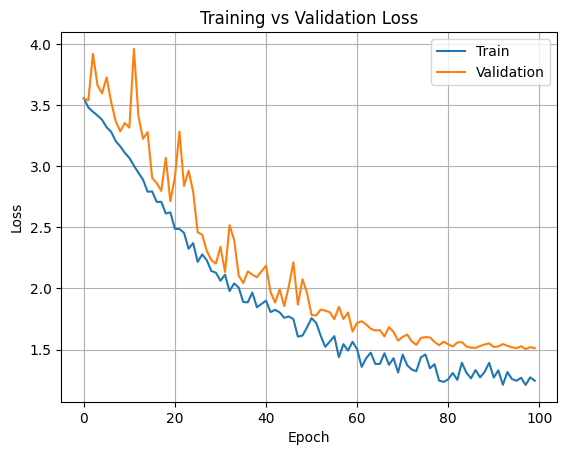

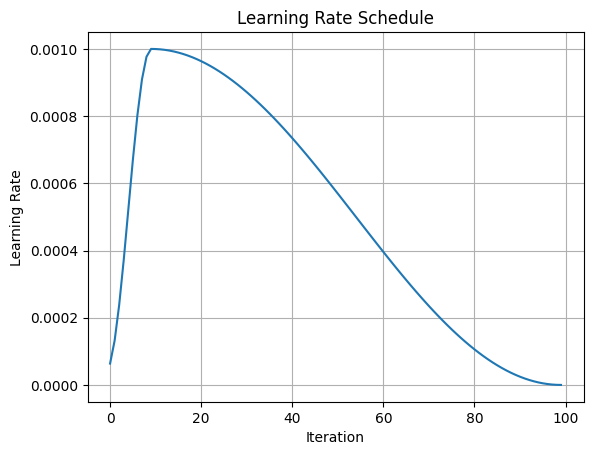

(Net(
   (stem): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
   )
   (stage1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
# Model 1
run_ablation_experiment("Baseline")

## **Model variant: No Batch Normalization**

**Change**
- Removed all Batch Normalization layers from the network, including those in residual skip connections.

**Purpose**
- To assess the contribution of Batch Normalization to training stability and final performance.


=== Running: No BatchNorm ===
Total parameters: 11,327,109 | Trainable: 11,327,109


2026/02/16 03:41:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 3.612, Train Acc: 0.023 | Val Loss: 3.609, Val Acc: 0.038 | LR: 6.35e-05


2026/02/16 03:42:01 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:42:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [2/100] | Train Loss: 3.590, Train Acc: 0.044 | Val Loss: 3.603, Val Acc: 0.035 | LR: 1.32e-04


2026/02/16 03:42:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [3/100] | Train Loss: 3.579, Train Acc: 0.044 | Val Loss: 3.569, Val Acc: 0.047 | LR: 2.38e-04


2026/02/16 03:42:46 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:42:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:43:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [4/100] | Train Loss: 3.546, Train Acc: 0.051 | Val Loss: 3.545, Val Acc: 0.064 | LR: 3.72e-04


2026/02/16 03:43:16 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:43:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [5/100] | Train Loss: 3.521, Train Acc: 0.060 | Val Loss: 3.557, Val Acc: 0.051 | LR: 5.21e-04


2026/02/16 03:43:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [6/100] | Train Loss: 3.475, Train Acc: 0.071 | Val Loss: 3.456, Val Acc: 0.067 | LR: 6.69e-04


2026/02/16 03:44:02 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:44:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [7/100] | Train Loss: 3.433, Train Acc: 0.080 | Val Loss: 3.504, Val Acc: 0.055 | LR: 8.03e-04


Epoch [8/100] | Train Loss: 3.425, Train Acc: 0.085 | Val Loss: 3.432, Val Acc: 0.065 | LR: 9.09e-04


Epoch [9/100] | Train Loss: 3.417, Train Acc: 0.083 | Val Loss: 3.426, Val Acc: 0.071 | LR: 9.77e-04


2026/02/16 03:45:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 03:45:05 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:45:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:45:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [10/100] | Train Loss: 3.398, Train Acc: 0.090 | Val Loss: 3.454, Val Acc: 0.082 | LR: 1.00e-03


2026/02/16 03:45:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:45:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:46:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [11/100] | Train Loss: 3.353, Train Acc: 0.104 | Val Loss: 3.340, Val Acc: 0.093 | LR: 1.00e-03


2026/02/16 03:46:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:46:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:46:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [12/100] | Train Loss: 3.324, Train Acc: 0.119 | Val Loss: 3.371, Val Acc: 0.102 | LR: 9.99e-04


2026/02/16 03:46:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:46:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:47:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [13/100] | Train Loss: 3.303, Train Acc: 0.119 | Val Loss: 3.289, Val Acc: 0.103 | LR: 9.97e-04


2026/02/16 03:47:06 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:47:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:47:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [14/100] | Train Loss: 3.265, Train Acc: 0.130 | Val Loss: 3.323, Val Acc: 0.110 | LR: 9.95e-04


2026/02/16 03:47:35 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:47:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:47:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [15/100] | Train Loss: 3.220, Train Acc: 0.147 | Val Loss: 3.342, Val Acc: 0.115 | LR: 9.92e-04


2026/02/16 03:48:04 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:48:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:48:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [16/100] | Train Loss: 3.204, Train Acc: 0.158 | Val Loss: 3.259, Val Acc: 0.129 | LR: 9.89e-04


2026/02/16 03:48:35 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:48:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:49:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [17/100] | Train Loss: 3.181, Train Acc: 0.162 | Val Loss: 3.183, Val Acc: 0.131 | LR: 9.85e-04


2026/02/16 03:49:05 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:49:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:49:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [18/100] | Train Loss: 3.144, Train Acc: 0.185 | Val Loss: 3.146, Val Acc: 0.151 | LR: 9.81e-04


2026/02/16 03:49:35 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:49:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:49:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [19/100] | Train Loss: 3.110, Train Acc: 0.189 | Val Loss: 3.141, Val Acc: 0.152 | LR: 9.75e-04


2026/02/16 03:50:03 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:50:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:50:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [20/100] | Train Loss: 3.079, Train Acc: 0.216 | Val Loss: 3.147, Val Acc: 0.162 | LR: 9.70e-04


2026/02/16 03:50:31 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:50:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:50:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [21/100] | Train Loss: 3.071, Train Acc: 0.205 | Val Loss: 3.092, Val Acc: 0.176 | LR: 9.64e-04


2026/02/16 03:51:00 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:51:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:51:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [22/100] | Train Loss: 2.992, Train Acc: 0.220 | Val Loss: 3.018, Val Acc: 0.196 | LR: 9.57e-04


2026/02/16 03:51:29 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:51:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [23/100] | Train Loss: 2.962, Train Acc: 0.244 | Val Loss: 3.101, Val Acc: 0.173 | LR: 9.49e-04


2026/02/16 03:52:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [24/100] | Train Loss: 2.915, Train Acc: 0.265 | Val Loss: 3.008, Val Acc: 0.207 | LR: 9.41e-04


2026/02/16 03:52:12 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:52:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [25/100] | Train Loss: 2.884, Train Acc: 0.272 | Val Loss: 2.979, Val Acc: 0.206 | LR: 9.33e-04


2026/02/16 03:52:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [26/100] | Train Loss: 2.818, Train Acc: 0.283 | Val Loss: 2.928, Val Acc: 0.225 | LR: 9.24e-04


2026/02/16 03:52:53 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:52:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:53:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [27/100] | Train Loss: 2.771, Train Acc: 0.325 | Val Loss: 2.932, Val Acc: 0.226 | LR: 9.14e-04


2026/02/16 03:53:21 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:53:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:53:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [28/100] | Train Loss: 2.776, Train Acc: 0.318 | Val Loss: 2.927, Val Acc: 0.244 | LR: 9.04e-04


2026/02/16 03:53:50 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:53:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:54:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [29/100] | Train Loss: 2.637, Train Acc: 0.349 | Val Loss: 2.811, Val Acc: 0.279 | LR: 8.94e-04


2026/02/16 03:54:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:54:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [30/100] | Train Loss: 2.653, Train Acc: 0.360 | Val Loss: 2.793, Val Acc: 0.273 | LR: 8.83e-04


2026/02/16 03:54:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [31/100] | Train Loss: 2.617, Train Acc: 0.373 | Val Loss: 2.730, Val Acc: 0.288 | LR: 8.71e-04


2026/02/16 03:55:00 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:55:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:55:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [32/100] | Train Loss: 2.562, Train Acc: 0.405 | Val Loss: 2.731, Val Acc: 0.290 | LR: 8.60e-04


2026/02/16 03:55:28 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:55:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:55:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [33/100] | Train Loss: 2.500, Train Acc: 0.427 | Val Loss: 2.712, Val Acc: 0.292 | LR: 8.47e-04


2026/02/16 03:55:59 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:56:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:56:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [34/100] | Train Loss: 2.481, Train Acc: 0.429 | Val Loss: 2.772, Val Acc: 0.306 | LR: 8.34e-04


2026/02/16 03:56:27 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:56:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:56:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [35/100] | Train Loss: 2.381, Train Acc: 0.473 | Val Loss: 2.693, Val Acc: 0.311 | LR: 8.21e-04


2026/02/16 03:56:57 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:57:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 03:57:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [36/100] | Train Loss: 2.383, Train Acc: 0.478 | Val Loss: 2.615, Val Acc: 0.339 | LR: 8.08e-04


2026/02/16 03:57:25 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:57:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [37/100] | Train Loss: 2.349, Train Acc: 0.504 | Val Loss: 2.620, Val Acc: 0.330 | LR: 7.94e-04


2026/02/16 03:58:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [38/100] | Train Loss: 2.295, Train Acc: 0.521 | Val Loss: 2.576, Val Acc: 0.363 | LR: 7.79e-04


2026/02/16 03:58:06 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:58:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [39/100] | Train Loss: 2.297, Train Acc: 0.531 | Val Loss: 2.550, Val Acc: 0.353 | LR: 7.65e-04


Epoch [40/100] | Train Loss: 2.206, Train Acc: 0.545 | Val Loss: 2.570, Val Acc: 0.362 | LR: 7.50e-04


2026/02/16 03:58:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [41/100] | Train Loss: 2.210, Train Acc: 0.552 | Val Loss: 2.495, Val Acc: 0.377 | LR: 7.35e-04


2026/02/16 03:59:03 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:59:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [42/100] | Train Loss: 2.108, Train Acc: 0.598 | Val Loss: 2.566, Val Acc: 0.363 | LR: 7.19e-04


2026/02/16 03:59:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [43/100] | Train Loss: 2.080, Train Acc: 0.612 | Val Loss: 2.497, Val Acc: 0.381 | LR: 7.03e-04


2026/02/16 03:59:44 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 03:59:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [44/100] | Train Loss: 2.105, Train Acc: 0.601 | Val Loss: 2.517, Val Acc: 0.372 | LR: 6.87e-04


2026/02/16 04:00:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [45/100] | Train Loss: 2.008, Train Acc: 0.637 | Val Loss: 2.458, Val Acc: 0.410 | LR: 6.71e-04


2026/02/16 04:00:28 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:00:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:00:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [46/100] | Train Loss: 1.993, Train Acc: 0.644 | Val Loss: 2.455, Val Acc: 0.414 | LR: 6.54e-04


2026/02/16 04:00:56 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:01:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [47/100] | Train Loss: 1.975, Train Acc: 0.666 | Val Loss: 2.406, Val Acc: 0.412 | LR: 6.38e-04


Epoch [48/100] | Train Loss: 1.881, Train Acc: 0.680 | Val Loss: 2.462, Val Acc: 0.391 | LR: 6.21e-04


Epoch [49/100] | Train Loss: 1.842, Train Acc: 0.706 | Val Loss: 2.458, Val Acc: 0.414 | LR: 6.04e-04


Epoch [50/100] | Train Loss: 1.934, Train Acc: 0.699 | Val Loss: 2.438, Val Acc: 0.408 | LR: 5.87e-04


Epoch [51/100] | Train Loss: 1.871, Train Acc: 0.708 | Val Loss: 2.414, Val Acc: 0.407 | LR: 5.69e-04


Epoch [52/100] | Train Loss: 1.833, Train Acc: 0.722 | Val Loss: 2.437, Val Acc: 0.412 | LR: 5.52e-04


Epoch [53/100] | Train Loss: 1.718, Train Acc: 0.754 | Val Loss: 2.473, Val Acc: 0.391 | LR: 5.35e-04


2026/02/16 04:02:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [54/100] | Train Loss: 1.674, Train Acc: 0.772 | Val Loss: 2.381, Val Acc: 0.431 | LR: 5.17e-04


2026/02/16 04:02:59 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:03:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [55/100] | Train Loss: 1.687, Train Acc: 0.780 | Val Loss: 2.445, Val Acc: 0.421 | LR: 5.00e-04


Epoch [56/100] | Train Loss: 1.655, Train Acc: 0.790 | Val Loss: 2.398, Val Acc: 0.429 | LR: 4.82e-04


2026/02/16 04:03:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [57/100] | Train Loss: 1.746, Train Acc: 0.777 | Val Loss: 2.401, Val Acc: 0.436 | LR: 4.65e-04


2026/02/16 04:03:55 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:04:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [58/100] | Train Loss: 1.655, Train Acc: 0.807 | Val Loss: 2.386, Val Acc: 0.435 | LR: 4.48e-04


2026/02/16 04:04:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [59/100] | Train Loss: 1.636, Train Acc: 0.803 | Val Loss: 2.376, Val Acc: 0.443 | LR: 4.30e-04


2026/02/16 04:04:39 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:04:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [60/100] | Train Loss: 1.586, Train Acc: 0.847 | Val Loss: 2.355, Val Acc: 0.439 | LR: 4.13e-04


Epoch [61/100] | Train Loss: 1.604, Train Acc: 0.829 | Val Loss: 2.378, Val Acc: 0.433 | LR: 3.96e-04


2026/02/16 04:05:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [62/100] | Train Loss: 1.614, Train Acc: 0.831 | Val Loss: 2.396, Val Acc: 0.452 | LR: 3.79e-04


2026/02/16 04:05:37 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:05:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [63/100] | Train Loss: 1.495, Train Acc: 0.869 | Val Loss: 2.363, Val Acc: 0.447 | LR: 3.62e-04


Epoch [64/100] | Train Loss: 1.517, Train Acc: 0.859 | Val Loss: 2.365, Val Acc: 0.443 | LR: 3.45e-04


Epoch [65/100] | Train Loss: 1.434, Train Acc: 0.878 | Val Loss: 2.340, Val Acc: 0.448 | LR: 3.29e-04


Epoch [66/100] | Train Loss: 1.534, Train Acc: 0.874 | Val Loss: 2.359, Val Acc: 0.450 | LR: 3.13e-04


Epoch [67/100] | Train Loss: 1.554, Train Acc: 0.862 | Val Loss: 2.382, Val Acc: 0.446 | LR: 2.96e-04


2026/02/16 04:07:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [68/100] | Train Loss: 1.499, Train Acc: 0.880 | Val Loss: 2.348, Val Acc: 0.461 | LR: 2.81e-04


2026/02/16 04:07:26 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:07:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [69/100] | Train Loss: 1.510, Train Acc: 0.889 | Val Loss: 2.340, Val Acc: 0.457 | LR: 2.65e-04


Epoch [70/100] | Train Loss: 1.439, Train Acc: 0.881 | Val Loss: 2.318, Val Acc: 0.454 | LR: 2.50e-04


2026/02/16 04:08:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [71/100] | Train Loss: 1.397, Train Acc: 0.907 | Val Loss: 2.330, Val Acc: 0.468 | LR: 2.35e-04


2026/02/16 04:08:26 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:08:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [72/100] | Train Loss: 1.463, Train Acc: 0.887 | Val Loss: 2.321, Val Acc: 0.459 | LR: 2.20e-04


Epoch [73/100] | Train Loss: 1.432, Train Acc: 0.890 | Val Loss: 2.335, Val Acc: 0.460 | LR: 2.06e-04


Epoch [74/100] | Train Loss: 1.477, Train Acc: 0.893 | Val Loss: 2.335, Val Acc: 0.457 | LR: 1.92e-04


Epoch [75/100] | Train Loss: 1.370, Train Acc: 0.913 | Val Loss: 2.326, Val Acc: 0.467 | LR: 1.78e-04


Epoch [76/100] | Train Loss: 1.489, Train Acc: 0.895 | Val Loss: 2.314, Val Acc: 0.466 | LR: 1.65e-04


Epoch [77/100] | Train Loss: 1.413, Train Acc: 0.910 | Val Loss: 2.323, Val Acc: 0.458 | LR: 1.53e-04


Epoch [78/100] | Train Loss: 1.293, Train Acc: 0.937 | Val Loss: 2.313, Val Acc: 0.467 | LR: 1.40e-04


2026/02/16 04:10:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [79/100] | Train Loss: 1.191, Train Acc: 0.947 | Val Loss: 2.317, Val Acc: 0.472 | LR: 1.28e-04


2026/02/16 04:10:32 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:10:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [80/100] | Train Loss: 1.344, Train Acc: 0.922 | Val Loss: 2.314, Val Acc: 0.463 | LR: 1.17e-04


Epoch [81/100] | Train Loss: 1.349, Train Acc: 0.920 | Val Loss: 2.323, Val Acc: 0.472 | LR: 1.06e-04


2026/02/16 04:11:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [82/100] | Train Loss: 1.285, Train Acc: 0.945 | Val Loss: 2.296, Val Acc: 0.475 | LR: 9.54e-05


2026/02/16 04:11:28 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:11:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [83/100] | Train Loss: 1.432, Train Acc: 0.895 | Val Loss: 2.316, Val Acc: 0.469 | LR: 8.54e-05


Epoch [84/100] | Train Loss: 1.373, Train Acc: 0.913 | Val Loss: 2.300, Val Acc: 0.474 | LR: 7.59e-05


2026/02/16 04:12:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [85/100] | Train Loss: 1.326, Train Acc: 0.933 | Val Loss: 2.277, Val Acc: 0.477 | LR: 6.69e-05


2026/02/16 04:12:25 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:12:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:12:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [86/100] | Train Loss: 1.435, Train Acc: 0.913 | Val Loss: 2.293, Val Acc: 0.487 | LR: 5.85e-05


2026/02/16 04:12:56 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:13:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [87/100] | Train Loss: 1.473, Train Acc: 0.905 | Val Loss: 2.294, Val Acc: 0.477 | LR: 5.05e-05


Epoch [88/100] | Train Loss: 1.438, Train Acc: 0.899 | Val Loss: 2.281, Val Acc: 0.480 | LR: 4.32e-05


Epoch [89/100] | Train Loss: 1.451, Train Acc: 0.902 | Val Loss: 2.286, Val Acc: 0.475 | LR: 3.64e-05


Epoch [90/100] | Train Loss: 1.344, Train Acc: 0.925 | Val Loss: 2.276, Val Acc: 0.481 | LR: 3.01e-05


Epoch [91/100] | Train Loss: 1.292, Train Acc: 0.936 | Val Loss: 2.276, Val Acc: 0.482 | LR: 2.44e-05


Epoch [92/100] | Train Loss: 1.344, Train Acc: 0.936 | Val Loss: 2.275, Val Acc: 0.481 | LR: 1.93e-05


Epoch [93/100] | Train Loss: 1.417, Train Acc: 0.908 | Val Loss: 2.279, Val Acc: 0.479 | LR: 1.48e-05


Epoch [94/100] | Train Loss: 1.318, Train Acc: 0.930 | Val Loss: 2.280, Val Acc: 0.477 | LR: 1.09e-05


Epoch [95/100] | Train Loss: 1.300, Train Acc: 0.928 | Val Loss: 2.277, Val Acc: 0.480 | LR: 7.57e-06


Epoch [96/100] | Train Loss: 1.359, Train Acc: 0.919 | Val Loss: 2.286, Val Acc: 0.483 | LR: 4.85e-06


Epoch [97/100] | Train Loss: 1.330, Train Acc: 0.920 | Val Loss: 2.277, Val Acc: 0.479 | LR: 2.73e-06


Epoch [98/100] | Train Loss: 1.262, Train Acc: 0.941 | Val Loss: 2.273, Val Acc: 0.481 | LR: 1.21e-06


Epoch [99/100] | Train Loss: 1.364, Train Acc: 0.922 | Val Loss: 2.276, Val Acc: 0.480 | LR: 3.03e-07


Epoch [100/100] | Train Loss: 1.316, Train Acc: 0.930 | Val Loss: 2.274, Val Acc: 0.479 | LR: 4.02e-09
[No BatchNorm] Finished! Best Validation Accuracy: 0.487



[No BatchNorm] Test Loss: 2.151 | Test Acc: 0.535


2026/02/16 04:16:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 04:16:31 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:16:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run No BatchNorm at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/500c1e04d5bb46cab92ba1a37f121f37
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


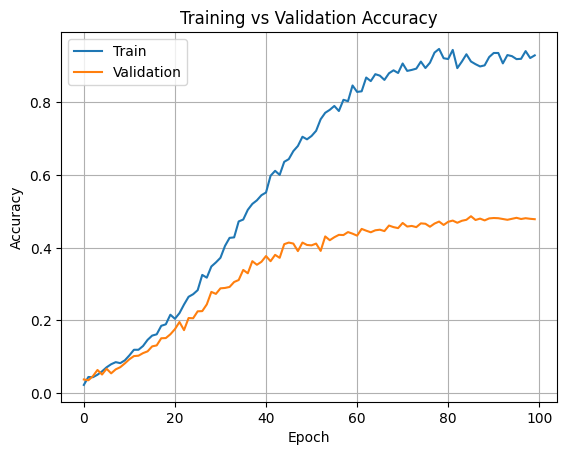

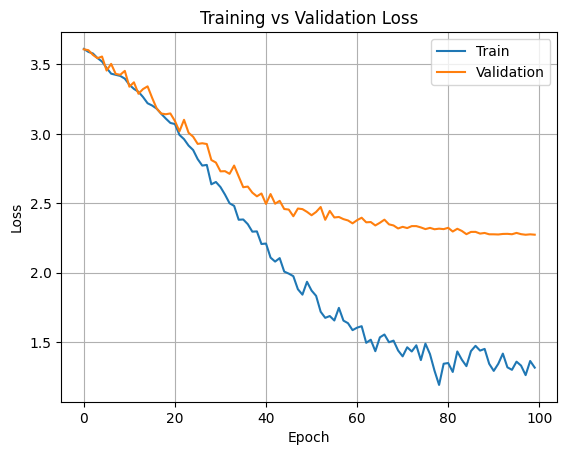

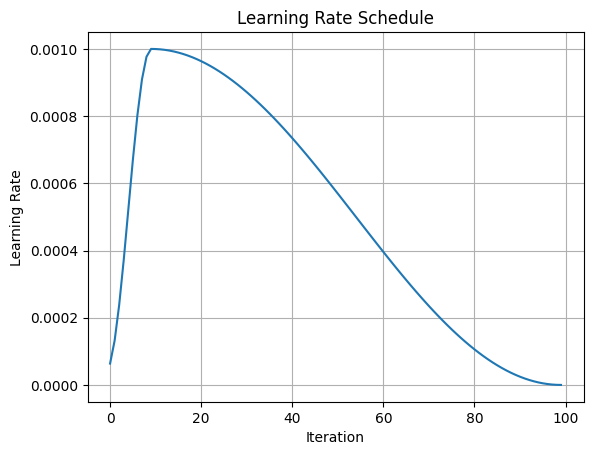

(Net(
   (stem): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
   )
   (stage1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): Identity()
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): Identity()
     )
     (1): Residua

In [ ]:
# Model 2
run_ablation_experiment("No BatchNorm", model_kwargs={"use_batchnorm": False})

=== Running: No Pooling ===
Total parameters: 11,336,581 | Trainable: 11,336,581


2026/02/16 04:16:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 3.569, Train Acc: 0.050 | Val Loss: 3.522, Val Acc: 0.067 | LR: 6.35e-05


2026/02/16 04:17:02 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:17:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:17:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [2/100] | Train Loss: 3.487, Train Acc: 0.079 | Val Loss: 3.504, Val Acc: 0.080 | LR: 1.32e-04


2026/02/16 04:17:31 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:17:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [3/100] | Train Loss: 3.454, Train Acc: 0.087 | Val Loss: 3.492, Val Acc: 0.076 | LR: 2.38e-04


Epoch [4/100] | Train Loss: 3.413, Train Acc: 0.098 | Val Loss: 3.680, Val Acc: 0.061 | LR: 3.72e-04


Epoch [5/100] | Train Loss: 3.338, Train Acc: 0.128 | Val Loss: 5.529, Val Acc: 0.035 | LR: 5.21e-04


2026/02/16 04:18:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [6/100] | Train Loss: 3.299, Train Acc: 0.138 | Val Loss: 3.504, Val Acc: 0.093 | LR: 6.69e-04


2026/02/16 04:18:39 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:18:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [7/100] | Train Loss: 3.223, Train Acc: 0.143 | Val Loss: 4.623, Val Acc: 0.067 | LR: 8.03e-04


2026/02/16 04:19:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [8/100] | Train Loss: 3.196, Train Acc: 0.166 | Val Loss: 3.429, Val Acc: 0.117 | LR: 9.09e-04


2026/02/16 04:19:23 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:19:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:19:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [9/100] | Train Loss: 3.123, Train Acc: 0.187 | Val Loss: 3.202, Val Acc: 0.135 | LR: 9.77e-04


2026/02/16 04:19:51 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:19:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [10/100] | Train Loss: 3.081, Train Acc: 0.200 | Val Loss: 4.782, Val Acc: 0.077 | LR: 1.00e-03


2026/02/16 04:20:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [11/100] | Train Loss: 3.035, Train Acc: 0.217 | Val Loss: 3.371, Val Acc: 0.141 | LR: 1.00e-03


2026/02/16 04:20:33 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:20:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:20:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [12/100] | Train Loss: 2.912, Train Acc: 0.250 | Val Loss: 3.052, Val Acc: 0.177 | LR: 9.99e-04


2026/02/16 04:21:00 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:21:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:21:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [13/100] | Train Loss: 2.893, Train Acc: 0.262 | Val Loss: 3.146, Val Acc: 0.185 | LR: 9.97e-04


2026/02/16 04:21:30 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:21:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [14/100] | Train Loss: 2.835, Train Acc: 0.287 | Val Loss: 3.635, Val Acc: 0.149 | LR: 9.95e-04


Epoch [15/100] | Train Loss: 2.726, Train Acc: 0.315 | Val Loss: 3.627, Val Acc: 0.156 | LR: 9.92e-04


2026/02/16 04:22:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [16/100] | Train Loss: 2.758, Train Acc: 0.315 | Val Loss: 2.738, Val Acc: 0.290 | LR: 9.89e-04


2026/02/16 04:22:26 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:22:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [17/100] | Train Loss: 2.634, Train Acc: 0.354 | Val Loss: 2.870, Val Acc: 0.237 | LR: 9.85e-04


Epoch [18/100] | Train Loss: 2.646, Train Acc: 0.367 | Val Loss: 4.062, Val Acc: 0.149 | LR: 9.81e-04


Epoch [19/100] | Train Loss: 2.571, Train Acc: 0.380 | Val Loss: 3.179, Val Acc: 0.224 | LR: 9.75e-04


2026/02/16 04:23:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [20/100] | Train Loss: 2.425, Train Acc: 0.420 | Val Loss: 2.686, Val Acc: 0.311 | LR: 9.70e-04


2026/02/16 04:23:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:23:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:24:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [21/100] | Train Loss: 2.484, Train Acc: 0.418 | Val Loss: 2.611, Val Acc: 0.329 | LR: 9.64e-04


2026/02/16 04:24:05 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:24:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [22/100] | Train Loss: 2.419, Train Acc: 0.442 | Val Loss: 2.672, Val Acc: 0.328 | LR: 9.57e-04


Epoch [23/100] | Train Loss: 2.435, Train Acc: 0.444 | Val Loss: 2.595, Val Acc: 0.316 | LR: 9.49e-04


2026/02/16 04:24:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [24/100] | Train Loss: 2.351, Train Acc: 0.473 | Val Loss: 2.584, Val Acc: 0.338 | LR: 9.41e-04


2026/02/16 04:25:02 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:25:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [25/100] | Train Loss: 2.346, Train Acc: 0.473 | Val Loss: 2.972, Val Acc: 0.249 | LR: 9.33e-04


2026/02/16 04:25:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [26/100] | Train Loss: 2.270, Train Acc: 0.502 | Val Loss: 2.301, Val Acc: 0.406 | LR: 9.24e-04


2026/02/16 04:25:44 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:25:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [27/100] | Train Loss: 2.225, Train Acc: 0.523 | Val Loss: 2.872, Val Acc: 0.298 | LR: 9.14e-04


2026/02/16 04:26:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [28/100] | Train Loss: 2.193, Train Acc: 0.549 | Val Loss: 2.319, Val Acc: 0.430 | LR: 9.04e-04


2026/02/16 04:26:27 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:26:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [29/100] | Train Loss: 2.146, Train Acc: 0.551 | Val Loss: 2.477, Val Acc: 0.353 | LR: 8.94e-04


Epoch [30/100] | Train Loss: 2.185, Train Acc: 0.539 | Val Loss: 3.405, Val Acc: 0.244 | LR: 8.83e-04


Epoch [31/100] | Train Loss: 2.051, Train Acc: 0.590 | Val Loss: 2.289, Val Acc: 0.425 | LR: 8.71e-04


Epoch [32/100] | Train Loss: 2.149, Train Acc: 0.573 | Val Loss: 2.376, Val Acc: 0.385 | LR: 8.60e-04


2026/02/16 04:27:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [33/100] | Train Loss: 2.098, Train Acc: 0.590 | Val Loss: 2.114, Val Acc: 0.487 | LR: 8.47e-04


2026/02/16 04:27:50 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:27:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:28:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [34/100] | Train Loss: 2.007, Train Acc: 0.620 | Val Loss: 2.068, Val Acc: 0.495 | LR: 8.34e-04


2026/02/16 04:28:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:28:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [35/100] | Train Loss: 2.065, Train Acc: 0.611 | Val Loss: 2.344, Val Acc: 0.424 | LR: 8.21e-04


Epoch [36/100] | Train Loss: 1.917, Train Acc: 0.629 | Val Loss: 2.619, Val Acc: 0.351 | LR: 8.08e-04


2026/02/16 04:29:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [37/100] | Train Loss: 1.941, Train Acc: 0.649 | Val Loss: 2.052, Val Acc: 0.513 | LR: 7.94e-04


2026/02/16 04:29:14 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:29:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [38/100] | Train Loss: 1.970, Train Acc: 0.637 | Val Loss: 2.188, Val Acc: 0.469 | LR: 7.79e-04


2026/02/16 04:29:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [39/100] | Train Loss: 1.965, Train Acc: 0.645 | Val Loss: 1.967, Val Acc: 0.537 | LR: 7.65e-04


2026/02/16 04:29:56 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:30:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [40/100] | Train Loss: 1.844, Train Acc: 0.681 | Val Loss: 2.007, Val Acc: 0.529 | LR: 7.50e-04


Epoch [41/100] | Train Loss: 1.852, Train Acc: 0.695 | Val Loss: 2.057, Val Acc: 0.511 | LR: 7.35e-04


Epoch [42/100] | Train Loss: 1.885, Train Acc: 0.682 | Val Loss: 2.274, Val Acc: 0.455 | LR: 7.19e-04


2026/02/16 04:31:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [43/100] | Train Loss: 1.783, Train Acc: 0.721 | Val Loss: 1.909, Val Acc: 0.556 | LR: 7.03e-04


2026/02/16 04:31:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:31:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:31:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [44/100] | Train Loss: 1.742, Train Acc: 0.730 | Val Loss: 1.910, Val Acc: 0.574 | LR: 6.87e-04


2026/02/16 04:31:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:31:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [45/100] | Train Loss: 1.762, Train Acc: 0.723 | Val Loss: 2.006, Val Acc: 0.517 | LR: 6.71e-04


Epoch [46/100] | Train Loss: 1.739, Train Acc: 0.737 | Val Loss: 2.121, Val Acc: 0.487 | LR: 6.54e-04


2026/02/16 04:32:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [47/100] | Train Loss: 1.803, Train Acc: 0.736 | Val Loss: 1.884, Val Acc: 0.580 | LR: 6.38e-04


2026/02/16 04:32:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:32:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [48/100] | Train Loss: 1.676, Train Acc: 0.759 | Val Loss: 1.976, Val Acc: 0.540 | LR: 6.21e-04


2026/02/16 04:33:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [49/100] | Train Loss: 1.682, Train Acc: 0.762 | Val Loss: 1.823, Val Acc: 0.585 | LR: 6.04e-04


2026/02/16 04:33:19 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:33:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [50/100] | Train Loss: 1.605, Train Acc: 0.796 | Val Loss: 1.912, Val Acc: 0.569 | LR: 5.87e-04


Epoch [51/100] | Train Loss: 1.576, Train Acc: 0.802 | Val Loss: 1.842, Val Acc: 0.576 | LR: 5.69e-04


2026/02/16 04:34:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [52/100] | Train Loss: 1.622, Train Acc: 0.799 | Val Loss: 1.760, Val Acc: 0.616 | LR: 5.52e-04


2026/02/16 04:34:13 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:34:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:34:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [53/100] | Train Loss: 1.565, Train Acc: 0.814 | Val Loss: 1.760, Val Acc: 0.622 | LR: 5.35e-04


2026/02/16 04:34:41 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:34:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [54/100] | Train Loss: 1.596, Train Acc: 0.805 | Val Loss: 2.051, Val Acc: 0.524 | LR: 5.17e-04


Epoch [55/100] | Train Loss: 1.609, Train Acc: 0.804 | Val Loss: 1.871, Val Acc: 0.590 | LR: 5.00e-04


Epoch [56/100] | Train Loss: 1.487, Train Acc: 0.836 | Val Loss: 1.809, Val Acc: 0.603 | LR: 4.82e-04


2026/02/16 04:35:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [57/100] | Train Loss: 1.462, Train Acc: 0.848 | Val Loss: 1.725, Val Acc: 0.630 | LR: 4.65e-04


2026/02/16 04:35:50 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:35:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:36:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [58/100] | Train Loss: 1.528, Train Acc: 0.835 | Val Loss: 1.693, Val Acc: 0.632 | LR: 4.48e-04


2026/02/16 04:36:19 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:36:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [59/100] | Train Loss: 1.481, Train Acc: 0.851 | Val Loss: 1.777, Val Acc: 0.608 | LR: 4.30e-04


Epoch [60/100] | Train Loss: 1.425, Train Acc: 0.855 | Val Loss: 1.802, Val Acc: 0.609 | LR: 4.13e-04


2026/02/16 04:37:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [61/100] | Train Loss: 1.468, Train Acc: 0.859 | Val Loss: 1.698, Val Acc: 0.642 | LR: 3.96e-04


2026/02/16 04:37:14 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:37:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:37:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [62/100] | Train Loss: 1.417, Train Acc: 0.882 | Val Loss: 1.654, Val Acc: 0.660 | LR: 3.79e-04


2026/02/16 04:37:44 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:37:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [63/100] | Train Loss: 1.372, Train Acc: 0.880 | Val Loss: 1.718, Val Acc: 0.640 | LR: 3.62e-04


2026/02/16 04:38:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [64/100] | Train Loss: 1.415, Train Acc: 0.874 | Val Loss: 1.613, Val Acc: 0.672 | LR: 3.45e-04


2026/02/16 04:38:26 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:38:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [65/100] | Train Loss: 1.338, Train Acc: 0.907 | Val Loss: 1.604, Val Acc: 0.666 | LR: 3.29e-04


Epoch [66/100] | Train Loss: 1.425, Train Acc: 0.892 | Val Loss: 1.743, Val Acc: 0.629 | LR: 3.13e-04


Epoch [67/100] | Train Loss: 1.351, Train Acc: 0.896 | Val Loss: 1.676, Val Acc: 0.649 | LR: 2.96e-04


Epoch [68/100] | Train Loss: 1.364, Train Acc: 0.898 | Val Loss: 1.640, Val Acc: 0.666 | LR: 2.81e-04


2026/02/16 04:39:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [69/100] | Train Loss: 1.382, Train Acc: 0.895 | Val Loss: 1.612, Val Acc: 0.672 | LR: 2.65e-04


2026/02/16 04:39:50 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:39:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [70/100] | Train Loss: 1.325, Train Acc: 0.917 | Val Loss: 1.623, Val Acc: 0.671 | LR: 2.50e-04


2026/02/16 04:40:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [71/100] | Train Loss: 1.317, Train Acc: 0.908 | Val Loss: 1.571, Val Acc: 0.698 | LR: 2.35e-04


2026/02/16 04:40:32 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:40:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [72/100] | Train Loss: 1.448, Train Acc: 0.887 | Val Loss: 1.609, Val Acc: 0.681 | LR: 2.20e-04


Epoch [73/100] | Train Loss: 1.437, Train Acc: 0.914 | Val Loss: 1.610, Val Acc: 0.685 | LR: 2.06e-04


Epoch [74/100] | Train Loss: 1.344, Train Acc: 0.917 | Val Loss: 1.604, Val Acc: 0.678 | LR: 1.92e-04


Epoch [75/100] | Train Loss: 1.353, Train Acc: 0.912 | Val Loss: 1.591, Val Acc: 0.685 | LR: 1.78e-04


Epoch [76/100] | Train Loss: 1.284, Train Acc: 0.928 | Val Loss: 1.575, Val Acc: 0.690 | LR: 1.65e-04


Epoch [77/100] | Train Loss: 1.309, Train Acc: 0.919 | Val Loss: 1.590, Val Acc: 0.683 | LR: 1.53e-04


Epoch [78/100] | Train Loss: 1.355, Train Acc: 0.911 | Val Loss: 1.574, Val Acc: 0.691 | LR: 1.40e-04


Epoch [79/100] | Train Loss: 1.357, Train Acc: 0.922 | Val Loss: 1.579, Val Acc: 0.679 | LR: 1.28e-04


2026/02/16 04:42:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [80/100] | Train Loss: 1.296, Train Acc: 0.923 | Val Loss: 1.533, Val Acc: 0.701 | LR: 1.17e-04


2026/02/16 04:42:56 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:43:02 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [81/100] | Train Loss: 1.278, Train Acc: 0.929 | Val Loss: 1.559, Val Acc: 0.696 | LR: 1.06e-04


2026/02/16 04:43:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [82/100] | Train Loss: 1.201, Train Acc: 0.959 | Val Loss: 1.530, Val Acc: 0.706 | LR: 9.54e-05


2026/02/16 04:43:42 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:43:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [83/100] | Train Loss: 1.280, Train Acc: 0.932 | Val Loss: 1.564, Val Acc: 0.696 | LR: 8.54e-05


Epoch [84/100] | Train Loss: 1.321, Train Acc: 0.927 | Val Loss: 1.554, Val Acc: 0.696 | LR: 7.59e-05


Epoch [85/100] | Train Loss: 1.396, Train Acc: 0.923 | Val Loss: 1.607, Val Acc: 0.692 | LR: 6.69e-05


2026/02/16 04:44:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [86/100] | Train Loss: 1.300, Train Acc: 0.929 | Val Loss: 1.556, Val Acc: 0.712 | LR: 5.85e-05


2026/02/16 04:44:55 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:45:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [87/100] | Train Loss: 1.325, Train Acc: 0.930 | Val Loss: 1.561, Val Acc: 0.703 | LR: 5.05e-05


Epoch [88/100] | Train Loss: 1.248, Train Acc: 0.951 | Val Loss: 1.520, Val Acc: 0.712 | LR: 4.32e-05


2026/02/16 04:45:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [89/100] | Train Loss: 1.242, Train Acc: 0.945 | Val Loss: 1.530, Val Acc: 0.715 | LR: 3.64e-05


2026/02/16 04:45:53 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:45:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:46:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [90/100] | Train Loss: 1.300, Train Acc: 0.933 | Val Loss: 1.536, Val Acc: 0.717 | LR: 3.01e-05


2026/02/16 04:46:21 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:46:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [91/100] | Train Loss: 1.248, Train Acc: 0.953 | Val Loss: 1.539, Val Acc: 0.708 | LR: 2.44e-05


2026/02/16 04:47:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [92/100] | Train Loss: 1.310, Train Acc: 0.938 | Val Loss: 1.530, Val Acc: 0.718 | LR: 1.93e-05


2026/02/16 04:47:07 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:47:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [93/100] | Train Loss: 1.199, Train Acc: 0.958 | Val Loss: 1.544, Val Acc: 0.712 | LR: 1.48e-05


Epoch [94/100] | Train Loss: 1.285, Train Acc: 0.943 | Val Loss: 1.551, Val Acc: 0.704 | LR: 1.09e-05


Epoch [95/100] | Train Loss: 1.333, Train Acc: 0.921 | Val Loss: 1.523, Val Acc: 0.710 | LR: 7.57e-06


Epoch [96/100] | Train Loss: 1.266, Train Acc: 0.947 | Val Loss: 1.511, Val Acc: 0.716 | LR: 4.85e-06


Epoch [97/100] | Train Loss: 1.236, Train Acc: 0.953 | Val Loss: 1.525, Val Acc: 0.710 | LR: 2.73e-06


Epoch [98/100] | Train Loss: 1.318, Train Acc: 0.935 | Val Loss: 1.548, Val Acc: 0.708 | LR: 1.21e-06


Epoch [99/100] | Train Loss: 1.369, Train Acc: 0.920 | Val Loss: 1.531, Val Acc: 0.711 | LR: 3.03e-07


2026/02/16 04:49:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [100/100] | Train Loss: 1.238, Train Acc: 0.950 | Val Loss: 1.515, Val Acc: 0.719 | LR: 4.02e-09


2026/02/16 04:49:19 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:49:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


[No Pooling] Finished! Best Validation Accuracy: 0.719



[No Pooling] Test Loss: 1.464 | Test Acc: 0.737


2026/02/16 04:49:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 04:49:41 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:49:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run No Pooling at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/6f35b87cacd44c409e8ce2e2f36af93f
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


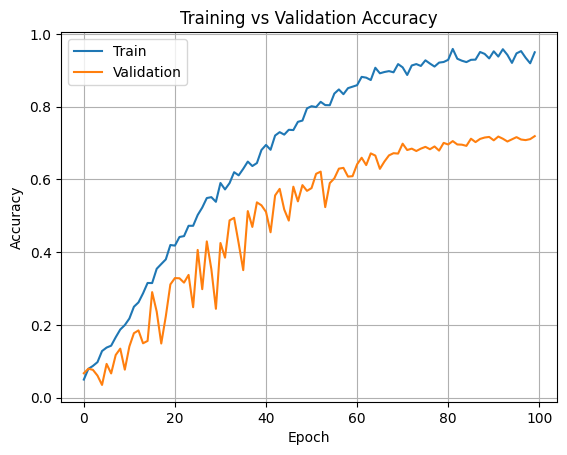

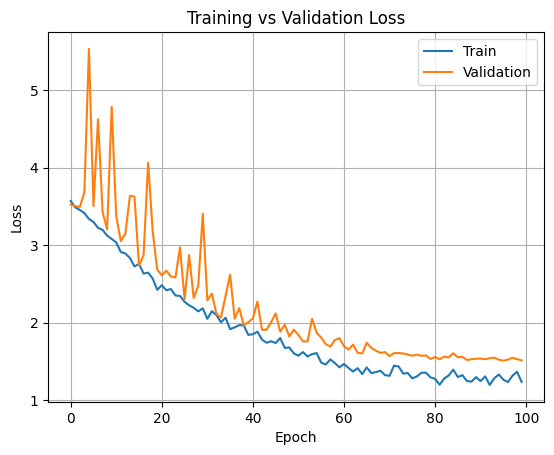

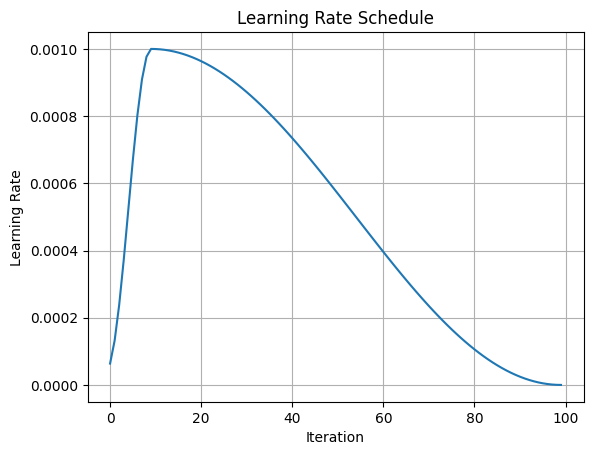

(Net(
   (stem): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
   )
   (stage1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
# Model 3
run_ablation_experiment("No Pooling", model_kwargs={"use_pooling": False})

## **Model variant: No Dropout**

**Change**
- Removed dropout from the classifier head while keeping the rest of the architecture unchanged.

**Purpose**
- To assess the impact of dropout-based regularization on overfitting and generalization performance.

=== Running: No Dropout ===
Total parameters: 11,336,581 | Trainable: 11,336,581


2026/02/16 04:50:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 3.539, Train Acc: 0.062 | Val Loss: 3.525, Val Acc: 0.067 | LR: 6.35e-05


2026/02/16 04:50:12 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:50:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:50:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [2/100] | Train Loss: 3.446, Train Acc: 0.089 | Val Loss: 3.530, Val Acc: 0.087 | LR: 1.32e-04


2026/02/16 04:50:42 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:50:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [3/100] | Train Loss: 3.397, Train Acc: 0.107 | Val Loss: 3.475, Val Acc: 0.080 | LR: 2.38e-04


Epoch [4/100] | Train Loss: 3.328, Train Acc: 0.120 | Val Loss: 3.730, Val Acc: 0.074 | LR: 3.72e-04


Epoch [5/100] | Train Loss: 3.280, Train Acc: 0.138 | Val Loss: 4.312, Val Acc: 0.052 | LR: 5.21e-04


2026/02/16 04:51:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [6/100] | Train Loss: 3.231, Train Acc: 0.146 | Val Loss: 3.347, Val Acc: 0.109 | LR: 6.69e-04


2026/02/16 04:51:51 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:51:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [7/100] | Train Loss: 3.156, Train Acc: 0.176 | Val Loss: 4.785, Val Acc: 0.050 | LR: 8.03e-04


2026/02/16 04:52:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [8/100] | Train Loss: 3.102, Train Acc: 0.193 | Val Loss: 3.230, Val Acc: 0.146 | LR: 9.09e-04


2026/02/16 04:52:34 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:52:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [9/100] | Train Loss: 3.014, Train Acc: 0.217 | Val Loss: 5.769, Val Acc: 0.071 | LR: 9.77e-04


Epoch [10/100] | Train Loss: 2.941, Train Acc: 0.249 | Val Loss: 3.457, Val Acc: 0.123 | LR: 1.00e-03


2026/02/16 04:53:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [11/100] | Train Loss: 2.893, Train Acc: 0.268 | Val Loss: 3.219, Val Acc: 0.153 | LR: 1.00e-03


2026/02/16 04:53:28 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:53:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [12/100] | Train Loss: 2.782, Train Acc: 0.292 | Val Loss: 3.247, Val Acc: 0.152 | LR: 9.99e-04


2026/02/16 04:54:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [13/100] | Train Loss: 2.711, Train Acc: 0.318 | Val Loss: 3.038, Val Acc: 0.237 | LR: 9.97e-04


2026/02/16 04:54:12 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:54:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 04:54:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [14/100] | Train Loss: 2.640, Train Acc: 0.359 | Val Loss: 2.904, Val Acc: 0.238 | LR: 9.95e-04


2026/02/16 04:54:39 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:54:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [15/100] | Train Loss: 2.603, Train Acc: 0.363 | Val Loss: 3.851, Val Acc: 0.135 | LR: 9.92e-04


2026/02/16 04:55:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [16/100] | Train Loss: 2.503, Train Acc: 0.412 | Val Loss: 2.870, Val Acc: 0.260 | LR: 9.89e-04


2026/02/16 04:55:23 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:55:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [17/100] | Train Loss: 2.374, Train Acc: 0.437 | Val Loss: 3.487, Val Acc: 0.226 | LR: 9.85e-04


2026/02/16 04:56:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [18/100] | Train Loss: 2.365, Train Acc: 0.456 | Val Loss: 2.679, Val Acc: 0.330 | LR: 9.81e-04


2026/02/16 04:56:04 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:56:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [19/100] | Train Loss: 2.353, Train Acc: 0.470 | Val Loss: 3.012, Val Acc: 0.277 | LR: 9.75e-04


2026/02/16 04:56:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [20/100] | Train Loss: 2.295, Train Acc: 0.495 | Val Loss: 2.569, Val Acc: 0.351 | LR: 9.70e-04


2026/02/16 04:56:48 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:56:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [21/100] | Train Loss: 2.200, Train Acc: 0.512 | Val Loss: 2.914, Val Acc: 0.277 | LR: 9.64e-04


Epoch [22/100] | Train Loss: 2.173, Train Acc: 0.543 | Val Loss: 2.700, Val Acc: 0.332 | LR: 9.57e-04


2026/02/16 04:57:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [23/100] | Train Loss: 2.127, Train Acc: 0.542 | Val Loss: 2.320, Val Acc: 0.429 | LR: 9.49e-04


2026/02/16 04:57:44 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:57:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [24/100] | Train Loss: 2.185, Train Acc: 0.563 | Val Loss: 2.712, Val Acc: 0.323 | LR: 9.41e-04


Epoch [25/100] | Train Loss: 2.057, Train Acc: 0.585 | Val Loss: 2.800, Val Acc: 0.262 | LR: 9.33e-04


2026/02/16 04:58:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [26/100] | Train Loss: 2.085, Train Acc: 0.588 | Val Loss: 2.247, Val Acc: 0.457 | LR: 9.24e-04


2026/02/16 04:58:41 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:58:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [27/100] | Train Loss: 1.979, Train Acc: 0.597 | Val Loss: 2.701, Val Acc: 0.347 | LR: 9.14e-04


Epoch [28/100] | Train Loss: 1.988, Train Acc: 0.617 | Val Loss: 2.570, Val Acc: 0.369 | LR: 9.04e-04


2026/02/16 04:59:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [29/100] | Train Loss: 1.915, Train Acc: 0.627 | Val Loss: 2.187, Val Acc: 0.471 | LR: 8.94e-04


2026/02/16 04:59:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 04:59:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:00:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [30/100] | Train Loss: 1.904, Train Acc: 0.647 | Val Loss: 2.173, Val Acc: 0.472 | LR: 8.83e-04


2026/02/16 05:00:07 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:00:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [31/100] | Train Loss: 1.834, Train Acc: 0.679 | Val Loss: 2.537, Val Acc: 0.365 | LR: 8.71e-04


2026/02/16 05:00:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [32/100] | Train Loss: 1.818, Train Acc: 0.694 | Val Loss: 2.108, Val Acc: 0.487 | LR: 8.60e-04


2026/02/16 05:00:53 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:00:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [33/100] | Train Loss: 1.847, Train Acc: 0.686 | Val Loss: 2.320, Val Acc: 0.417 | LR: 8.47e-04


Epoch [34/100] | Train Loss: 1.856, Train Acc: 0.700 | Val Loss: 2.119, Val Acc: 0.485 | LR: 8.34e-04


Epoch [35/100] | Train Loss: 1.757, Train Acc: 0.719 | Val Loss: 2.266, Val Acc: 0.461 | LR: 8.21e-04


2026/02/16 05:02:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [36/100] | Train Loss: 1.741, Train Acc: 0.714 | Val Loss: 2.136, Val Acc: 0.490 | LR: 8.08e-04


2026/02/16 05:02:10 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:02:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:02:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [37/100] | Train Loss: 1.681, Train Acc: 0.741 | Val Loss: 2.016, Val Acc: 0.528 | LR: 7.94e-04


2026/02/16 05:02:41 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:02:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [38/100] | Train Loss: 1.661, Train Acc: 0.754 | Val Loss: 2.209, Val Acc: 0.478 | LR: 7.79e-04


Epoch [39/100] | Train Loss: 1.655, Train Acc: 0.755 | Val Loss: 2.034, Val Acc: 0.509 | LR: 7.65e-04


2026/02/16 05:03:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [40/100] | Train Loss: 1.667, Train Acc: 0.757 | Val Loss: 1.985, Val Acc: 0.538 | LR: 7.50e-04


2026/02/16 05:03:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:03:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [41/100] | Train Loss: 1.732, Train Acc: 0.745 | Val Loss: 2.258, Val Acc: 0.458 | LR: 7.35e-04


Epoch [42/100] | Train Loss: 1.666, Train Acc: 0.775 | Val Loss: 2.022, Val Acc: 0.535 | LR: 7.19e-04


2026/02/16 05:04:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [43/100] | Train Loss: 1.604, Train Acc: 0.780 | Val Loss: 1.955, Val Acc: 0.551 | LR: 7.03e-04


2026/02/16 05:04:39 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:04:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:05:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [44/100] | Train Loss: 1.572, Train Acc: 0.794 | Val Loss: 1.983, Val Acc: 0.558 | LR: 6.87e-04


2026/02/16 05:05:10 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:05:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [45/100] | Train Loss: 1.615, Train Acc: 0.804 | Val Loss: 2.096, Val Acc: 0.509 | LR: 6.71e-04


2026/02/16 05:05:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [46/100] | Train Loss: 1.506, Train Acc: 0.823 | Val Loss: 1.940, Val Acc: 0.562 | LR: 6.54e-04


2026/02/16 05:05:52 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:05:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [47/100] | Train Loss: 1.621, Train Acc: 0.809 | Val Loss: 2.019, Val Acc: 0.547 | LR: 6.38e-04


2026/02/16 05:06:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [48/100] | Train Loss: 1.581, Train Acc: 0.836 | Val Loss: 1.871, Val Acc: 0.591 | LR: 6.21e-04


2026/02/16 05:06:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:06:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [49/100] | Train Loss: 1.465, Train Acc: 0.847 | Val Loss: 1.871, Val Acc: 0.585 | LR: 6.04e-04


Epoch [50/100] | Train Loss: 1.466, Train Acc: 0.844 | Val Loss: 1.906, Val Acc: 0.574 | LR: 5.87e-04


2026/02/16 05:07:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [51/100] | Train Loss: 1.524, Train Acc: 0.830 | Val Loss: 1.833, Val Acc: 0.605 | LR: 5.69e-04


2026/02/16 05:07:31 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:07:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [52/100] | Train Loss: 1.383, Train Acc: 0.872 | Val Loss: 1.886, Val Acc: 0.586 | LR: 5.52e-04


2026/02/16 05:08:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [53/100] | Train Loss: 1.512, Train Acc: 0.863 | Val Loss: 1.787, Val Acc: 0.610 | LR: 5.35e-04


2026/02/16 05:08:14 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:08:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:08:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [54/100] | Train Loss: 1.373, Train Acc: 0.868 | Val Loss: 1.782, Val Acc: 0.616 | LR: 5.17e-04


2026/02/16 05:08:42 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:08:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:09:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [55/100] | Train Loss: 1.326, Train Acc: 0.889 | Val Loss: 1.773, Val Acc: 0.622 | LR: 5.00e-04


2026/02/16 05:09:13 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:09:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:09:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [56/100] | Train Loss: 1.468, Train Acc: 0.871 | Val Loss: 1.765, Val Acc: 0.633 | LR: 4.82e-04


2026/02/16 05:09:42 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:09:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:10:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [57/100] | Train Loss: 1.505, Train Acc: 0.857 | Val Loss: 1.682, Val Acc: 0.658 | LR: 4.65e-04


2026/02/16 05:10:13 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:10:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [58/100] | Train Loss: 1.361, Train Acc: 0.888 | Val Loss: 1.657, Val Acc: 0.656 | LR: 4.48e-04


Epoch [59/100] | Train Loss: 1.322, Train Acc: 0.899 | Val Loss: 1.807, Val Acc: 0.607 | LR: 4.30e-04


Epoch [60/100] | Train Loss: 1.292, Train Acc: 0.922 | Val Loss: 1.744, Val Acc: 0.636 | LR: 4.13e-04


Epoch [61/100] | Train Loss: 1.408, Train Acc: 0.895 | Val Loss: 1.759, Val Acc: 0.636 | LR: 3.96e-04


Epoch [62/100] | Train Loss: 1.273, Train Acc: 0.930 | Val Loss: 1.689, Val Acc: 0.647 | LR: 3.79e-04


Epoch [63/100] | Train Loss: 1.329, Train Acc: 0.918 | Val Loss: 1.708, Val Acc: 0.641 | LR: 3.62e-04


2026/02/16 05:11:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [64/100] | Train Loss: 1.233, Train Acc: 0.937 | Val Loss: 1.587, Val Acc: 0.684 | LR: 3.45e-04


2026/02/16 05:12:04 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:12:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [65/100] | Train Loss: 1.366, Train Acc: 0.905 | Val Loss: 1.639, Val Acc: 0.683 | LR: 3.29e-04


Epoch [66/100] | Train Loss: 1.269, Train Acc: 0.937 | Val Loss: 1.621, Val Acc: 0.682 | LR: 3.13e-04


2026/02/16 05:12:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [67/100] | Train Loss: 1.285, Train Acc: 0.922 | Val Loss: 1.602, Val Acc: 0.688 | LR: 2.96e-04


2026/02/16 05:13:01 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:13:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [68/100] | Train Loss: 1.340, Train Acc: 0.908 | Val Loss: 1.620, Val Acc: 0.685 | LR: 2.81e-04


2026/02/16 05:13:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [69/100] | Train Loss: 1.366, Train Acc: 0.917 | Val Loss: 1.619, Val Acc: 0.692 | LR: 2.65e-04


2026/02/16 05:13:45 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:13:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:14:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [70/100] | Train Loss: 1.405, Train Acc: 0.908 | Val Loss: 1.604, Val Acc: 0.695 | LR: 2.50e-04


2026/02/16 05:14:15 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:14:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:14:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [71/100] | Train Loss: 1.233, Train Acc: 0.949 | Val Loss: 1.566, Val Acc: 0.707 | LR: 2.35e-04


2026/02/16 05:14:43 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:14:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [72/100] | Train Loss: 1.242, Train Acc: 0.942 | Val Loss: 1.621, Val Acc: 0.689 | LR: 2.20e-04


2026/02/16 05:15:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [73/100] | Train Loss: 1.256, Train Acc: 0.941 | Val Loss: 1.553, Val Acc: 0.718 | LR: 2.06e-04


2026/02/16 05:15:29 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:15:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [74/100] | Train Loss: 1.275, Train Acc: 0.938 | Val Loss: 1.597, Val Acc: 0.697 | LR: 1.92e-04


Epoch [75/100] | Train Loss: 1.278, Train Acc: 0.928 | Val Loss: 1.555, Val Acc: 0.708 | LR: 1.78e-04


Epoch [76/100] | Train Loss: 1.286, Train Acc: 0.928 | Val Loss: 1.572, Val Acc: 0.710 | LR: 1.65e-04


Epoch [77/100] | Train Loss: 1.188, Train Acc: 0.952 | Val Loss: 1.558, Val Acc: 0.713 | LR: 1.53e-04


Epoch [78/100] | Train Loss: 1.259, Train Acc: 0.949 | Val Loss: 1.568, Val Acc: 0.708 | LR: 1.40e-04


Epoch [79/100] | Train Loss: 1.152, Train Acc: 0.957 | Val Loss: 1.532, Val Acc: 0.715 | LR: 1.28e-04


2026/02/16 05:17:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [80/100] | Train Loss: 1.278, Train Acc: 0.939 | Val Loss: 1.554, Val Acc: 0.720 | LR: 1.17e-04


2026/02/16 05:17:20 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:17:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [81/100] | Train Loss: 1.183, Train Acc: 0.959 | Val Loss: 1.569, Val Acc: 0.716 | LR: 1.06e-04


2026/02/16 05:17:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [82/100] | Train Loss: 1.193, Train Acc: 0.948 | Val Loss: 1.531, Val Acc: 0.725 | LR: 9.54e-05


2026/02/16 05:18:04 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:18:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:18:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [83/100] | Train Loss: 1.319, Train Acc: 0.935 | Val Loss: 1.571, Val Acc: 0.727 | LR: 8.54e-05


2026/02/16 05:18:32 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:18:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [84/100] | Train Loss: 1.133, Train Acc: 0.953 | Val Loss: 1.533, Val Acc: 0.719 | LR: 7.59e-05


Epoch [85/100] | Train Loss: 1.210, Train Acc: 0.950 | Val Loss: 1.522, Val Acc: 0.724 | LR: 6.69e-05


Epoch [86/100] | Train Loss: 1.134, Train Acc: 0.959 | Val Loss: 1.518, Val Acc: 0.725 | LR: 5.85e-05


2026/02/16 05:19:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [87/100] | Train Loss: 1.235, Train Acc: 0.953 | Val Loss: 1.542, Val Acc: 0.730 | LR: 5.05e-05


2026/02/16 05:19:43 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:19:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [88/100] | Train Loss: 1.153, Train Acc: 0.953 | Val Loss: 1.525, Val Acc: 0.726 | LR: 4.32e-05


Epoch [89/100] | Train Loss: 1.210, Train Acc: 0.959 | Val Loss: 1.528, Val Acc: 0.727 | LR: 3.64e-05


Epoch [90/100] | Train Loss: 1.246, Train Acc: 0.944 | Val Loss: 1.527, Val Acc: 0.722 | LR: 3.01e-05


Epoch [91/100] | Train Loss: 1.157, Train Acc: 0.960 | Val Loss: 1.512, Val Acc: 0.724 | LR: 2.44e-05


Epoch [92/100] | Train Loss: 1.178, Train Acc: 0.947 | Val Loss: 1.522, Val Acc: 0.725 | LR: 1.93e-05


Epoch [93/100] | Train Loss: 1.214, Train Acc: 0.948 | Val Loss: 1.535, Val Acc: 0.723 | LR: 1.48e-05


2026/02/16 05:21:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [94/100] | Train Loss: 1.208, Train Acc: 0.950 | Val Loss: 1.526, Val Acc: 0.733 | LR: 1.09e-05


2026/02/16 05:21:33 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:21:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [95/100] | Train Loss: 1.210, Train Acc: 0.962 | Val Loss: 1.535, Val Acc: 0.730 | LR: 7.57e-06


Epoch [96/100] | Train Loss: 1.153, Train Acc: 0.960 | Val Loss: 1.515, Val Acc: 0.724 | LR: 4.85e-06


Epoch [97/100] | Train Loss: 1.170, Train Acc: 0.958 | Val Loss: 1.510, Val Acc: 0.732 | LR: 2.73e-06


Epoch [98/100] | Train Loss: 1.167, Train Acc: 0.950 | Val Loss: 1.522, Val Acc: 0.726 | LR: 1.21e-06


Epoch [99/100] | Train Loss: 1.157, Train Acc: 0.948 | Val Loss: 1.517, Val Acc: 0.728 | LR: 3.03e-07


Epoch [100/100] | Train Loss: 1.220, Train Acc: 0.944 | Val Loss: 1.519, Val Acc: 0.728 | LR: 4.02e-09
[No Dropout] Finished! Best Validation Accuracy: 0.733



[No Dropout] Test Loss: 1.477 | Test Acc: 0.735


2026/02/16 05:23:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 05:23:15 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:23:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run No Dropout at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/0b51da96878b44c09db84d3110929061
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


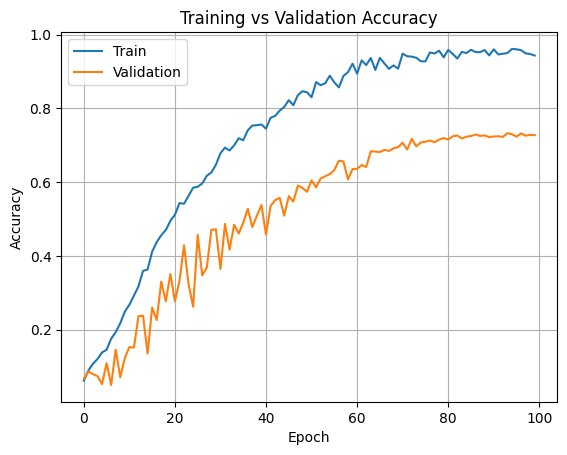

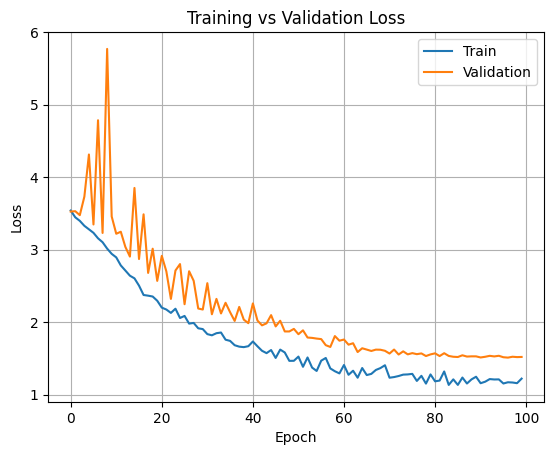

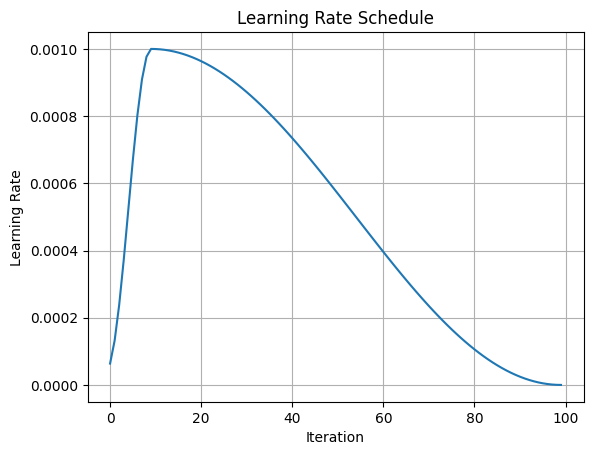

(Net(
   (stem): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
   )
   (stage1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
# Model 4
run_ablation_experiment("No Dropout", model_kwargs={"use_dropout": False})

## **Model variant: No MixUp**

**Change**
- Disabled MixUp data augmentation during training, using only standard input–label pairs.

**Purpose**
- To measure the effect of MixUp on model robustness and generalization compared to standard supervised training.

=== Running: No MixUp ===
Total parameters: 11,336,581 | Trainable: 11,336,581


2026/02/16 05:23:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 3.550, Train Acc: 0.052 | Val Loss: 3.540, Val Acc: 0.066 | LR: 6.35e-05


2026/02/16 05:23:46 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:23:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [2/100] | Train Loss: 3.437, Train Acc: 0.081 | Val Loss: 3.674, Val Acc: 0.058 | LR: 1.32e-04


Epoch [3/100] | Train Loss: 3.383, Train Acc: 0.103 | Val Loss: 3.724, Val Acc: 0.061 | LR: 2.38e-04


2026/02/16 05:24:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [4/100] | Train Loss: 3.346, Train Acc: 0.104 | Val Loss: 3.539, Val Acc: 0.081 | LR: 3.72e-04


2026/02/16 05:24:42 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:24:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [5/100] | Train Loss: 3.279, Train Acc: 0.116 | Val Loss: 3.859, Val Acc: 0.051 | LR: 5.21e-04


2026/02/16 05:25:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [6/100] | Train Loss: 3.208, Train Acc: 0.141 | Val Loss: 3.446, Val Acc: 0.092 | LR: 6.69e-04


2026/02/16 05:25:24 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:25:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:25:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [7/100] | Train Loss: 3.115, Train Acc: 0.165 | Val Loss: 3.664, Val Acc: 0.101 | LR: 8.03e-04


2026/02/16 05:25:54 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:25:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [8/100] | Train Loss: 3.062, Train Acc: 0.179 | Val Loss: 3.568, Val Acc: 0.079 | LR: 9.09e-04


2026/02/16 05:26:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [9/100] | Train Loss: 2.921, Train Acc: 0.219 | Val Loss: 3.421, Val Acc: 0.129 | LR: 9.77e-04


2026/02/16 05:26:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:26:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [10/100] | Train Loss: 2.847, Train Acc: 0.240 | Val Loss: 3.543, Val Acc: 0.124 | LR: 1.00e-03


2026/02/16 05:27:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [11/100] | Train Loss: 2.749, Train Acc: 0.265 | Val Loss: 3.786, Val Acc: 0.135 | LR: 1.00e-03


2026/02/16 05:27:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:27:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:27:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [12/100] | Train Loss: 2.669, Train Acc: 0.292 | Val Loss: 3.368, Val Acc: 0.191 | LR: 9.99e-04


2026/02/16 05:27:47 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:27:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:28:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [13/100] | Train Loss: 2.557, Train Acc: 0.328 | Val Loss: 3.276, Val Acc: 0.197 | LR: 9.97e-04


2026/02/16 05:28:16 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:28:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:28:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [14/100] | Train Loss: 2.492, Train Acc: 0.349 | Val Loss: 2.899, Val Acc: 0.233 | LR: 9.95e-04


2026/02/16 05:28:44 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:28:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:29:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [15/100] | Train Loss: 2.385, Train Acc: 0.391 | Val Loss: 2.805, Val Acc: 0.268 | LR: 9.92e-04


2026/02/16 05:29:14 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:29:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [16/100] | Train Loss: 2.344, Train Acc: 0.399 | Val Loss: 2.997, Val Acc: 0.227 | LR: 9.89e-04


2026/02/16 05:29:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [17/100] | Train Loss: 2.258, Train Acc: 0.432 | Val Loss: 2.631, Val Acc: 0.332 | LR: 9.85e-04


2026/02/16 05:29:55 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:30:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [18/100] | Train Loss: 2.172, Train Acc: 0.462 | Val Loss: 2.572, Val Acc: 0.330 | LR: 9.81e-04


Epoch [19/100] | Train Loss: 2.123, Train Acc: 0.476 | Val Loss: 3.408, Val Acc: 0.218 | LR: 9.75e-04


2026/02/16 05:30:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [20/100] | Train Loss: 2.082, Train Acc: 0.498 | Val Loss: 2.631, Val Acc: 0.342 | LR: 9.70e-04


2026/02/16 05:30:51 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:30:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:31:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [21/100] | Train Loss: 2.005, Train Acc: 0.518 | Val Loss: 2.586, Val Acc: 0.362 | LR: 9.64e-04


2026/02/16 05:31:20 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:31:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [22/100] | Train Loss: 1.960, Train Acc: 0.538 | Val Loss: 3.608, Val Acc: 0.207 | LR: 9.57e-04


2026/02/16 05:31:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [23/100] | Train Loss: 1.901, Train Acc: 0.561 | Val Loss: 2.619, Val Acc: 0.363 | LR: 9.49e-04


2026/02/16 05:32:04 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:32:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:32:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [24/100] | Train Loss: 1.849, Train Acc: 0.575 | Val Loss: 2.277, Val Acc: 0.437 | LR: 9.41e-04


2026/02/16 05:32:31 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:32:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [25/100] | Train Loss: 1.812, Train Acc: 0.587 | Val Loss: 2.331, Val Acc: 0.412 | LR: 9.33e-04


2026/02/16 05:33:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [26/100] | Train Loss: 1.762, Train Acc: 0.603 | Val Loss: 2.302, Val Acc: 0.456 | LR: 9.24e-04


2026/02/16 05:33:14 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:33:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [27/100] | Train Loss: 1.745, Train Acc: 0.610 | Val Loss: 2.511, Val Acc: 0.391 | LR: 9.14e-04


Epoch [28/100] | Train Loss: 1.672, Train Acc: 0.645 | Val Loss: 2.395, Val Acc: 0.409 | LR: 9.04e-04


Epoch [29/100] | Train Loss: 1.647, Train Acc: 0.658 | Val Loss: 2.412, Val Acc: 0.415 | LR: 8.94e-04


Epoch [30/100] | Train Loss: 1.618, Train Acc: 0.673 | Val Loss: 2.473, Val Acc: 0.382 | LR: 8.83e-04


2026/02/16 05:34:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [31/100] | Train Loss: 1.603, Train Acc: 0.670 | Val Loss: 2.177, Val Acc: 0.479 | LR: 8.71e-04


2026/02/16 05:34:37 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:34:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [32/100] | Train Loss: 1.560, Train Acc: 0.691 | Val Loss: 2.429, Val Acc: 0.432 | LR: 8.60e-04


2026/02/16 05:35:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [33/100] | Train Loss: 1.516, Train Acc: 0.702 | Val Loss: 2.133, Val Acc: 0.507 | LR: 8.47e-04


2026/02/16 05:35:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:35:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [34/100] | Train Loss: 1.463, Train Acc: 0.728 | Val Loss: 2.639, Val Acc: 0.390 | LR: 8.34e-04


Epoch [35/100] | Train Loss: 1.465, Train Acc: 0.719 | Val Loss: 2.273, Val Acc: 0.474 | LR: 8.21e-04


Epoch [36/100] | Train Loss: 1.412, Train Acc: 0.751 | Val Loss: 2.219, Val Acc: 0.478 | LR: 8.08e-04


2026/02/16 05:36:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [37/100] | Train Loss: 1.376, Train Acc: 0.767 | Val Loss: 2.013, Val Acc: 0.549 | LR: 7.94e-04


2026/02/16 05:36:29 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:36:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [38/100] | Train Loss: 1.351, Train Acc: 0.781 | Val Loss: 2.163, Val Acc: 0.508 | LR: 7.79e-04


2026/02/16 05:37:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [39/100] | Train Loss: 1.326, Train Acc: 0.788 | Val Loss: 1.861, Val Acc: 0.596 | LR: 7.65e-04


2026/02/16 05:37:10 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:37:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [40/100] | Train Loss: 1.316, Train Acc: 0.788 | Val Loss: 2.042, Val Acc: 0.517 | LR: 7.50e-04


Epoch [41/100] | Train Loss: 1.277, Train Acc: 0.799 | Val Loss: 2.072, Val Acc: 0.537 | LR: 7.35e-04


Epoch [42/100] | Train Loss: 1.249, Train Acc: 0.819 | Val Loss: 2.136, Val Acc: 0.533 | LR: 7.19e-04


Epoch [43/100] | Train Loss: 1.234, Train Acc: 0.820 | Val Loss: 2.063, Val Acc: 0.539 | LR: 7.03e-04


Epoch [44/100] | Train Loss: 1.214, Train Acc: 0.832 | Val Loss: 2.005, Val Acc: 0.549 | LR: 6.87e-04


Epoch [45/100] | Train Loss: 1.195, Train Acc: 0.842 | Val Loss: 2.047, Val Acc: 0.553 | LR: 6.71e-04


Epoch [46/100] | Train Loss: 1.149, Train Acc: 0.861 | Val Loss: 1.985, Val Acc: 0.547 | LR: 6.54e-04


Epoch [47/100] | Train Loss: 1.122, Train Acc: 0.875 | Val Loss: 2.146, Val Acc: 0.515 | LR: 6.38e-04


Epoch [48/100] | Train Loss: 1.128, Train Acc: 0.869 | Val Loss: 1.916, Val Acc: 0.575 | LR: 6.21e-04


Epoch [49/100] | Train Loss: 1.074, Train Acc: 0.895 | Val Loss: 1.954, Val Acc: 0.577 | LR: 6.04e-04


Epoch [50/100] | Train Loss: 1.070, Train Acc: 0.899 | Val Loss: 1.972, Val Acc: 0.576 | LR: 5.87e-04


2026/02/16 05:40:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [51/100] | Train Loss: 1.059, Train Acc: 0.903 | Val Loss: 1.870, Val Acc: 0.604 | LR: 5.69e-04


2026/02/16 05:40:13 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:40:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [52/100] | Train Loss: 1.043, Train Acc: 0.908 | Val Loss: 1.925, Val Acc: 0.589 | LR: 5.52e-04


Epoch [53/100] | Train Loss: 0.996, Train Acc: 0.927 | Val Loss: 1.860, Val Acc: 0.597 | LR: 5.35e-04


2026/02/16 05:41:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [54/100] | Train Loss: 0.992, Train Acc: 0.926 | Val Loss: 1.734, Val Acc: 0.643 | LR: 5.17e-04


2026/02/16 05:41:15 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:41:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [55/100] | Train Loss: 0.975, Train Acc: 0.938 | Val Loss: 1.789, Val Acc: 0.633 | LR: 5.00e-04


Epoch [56/100] | Train Loss: 0.970, Train Acc: 0.937 | Val Loss: 1.764, Val Acc: 0.625 | LR: 4.82e-04


Epoch [57/100] | Train Loss: 0.954, Train Acc: 0.942 | Val Loss: 1.781, Val Acc: 0.613 | LR: 4.65e-04


Epoch [58/100] | Train Loss: 0.941, Train Acc: 0.951 | Val Loss: 1.756, Val Acc: 0.631 | LR: 4.48e-04


Epoch [59/100] | Train Loss: 0.933, Train Acc: 0.954 | Val Loss: 1.723, Val Acc: 0.638 | LR: 4.30e-04


2026/02/16 05:42:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [60/100] | Train Loss: 0.914, Train Acc: 0.960 | Val Loss: 1.702, Val Acc: 0.651 | LR: 4.13e-04


2026/02/16 05:42:51 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:42:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [61/100] | Train Loss: 0.903, Train Acc: 0.962 | Val Loss: 1.790, Val Acc: 0.636 | LR: 3.96e-04


2026/02/16 05:43:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [62/100] | Train Loss: 0.886, Train Acc: 0.968 | Val Loss: 1.703, Val Acc: 0.660 | LR: 3.79e-04


2026/02/16 05:43:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:43:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [63/100] | Train Loss: 0.874, Train Acc: 0.974 | Val Loss: 1.721, Val Acc: 0.646 | LR: 3.62e-04


Epoch [64/100] | Train Loss: 0.862, Train Acc: 0.975 | Val Loss: 1.755, Val Acc: 0.650 | LR: 3.45e-04


2026/02/16 05:44:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [65/100] | Train Loss: 0.845, Train Acc: 0.983 | Val Loss: 1.654, Val Acc: 0.666 | LR: 3.29e-04


2026/02/16 05:44:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:44:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:45:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [66/100] | Train Loss: 0.844, Train Acc: 0.982 | Val Loss: 1.656, Val Acc: 0.672 | LR: 3.13e-04


2026/02/16 05:45:06 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:45:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [67/100] | Train Loss: 0.837, Train Acc: 0.983 | Val Loss: 1.710, Val Acc: 0.653 | LR: 2.96e-04


Epoch [68/100] | Train Loss: 0.823, Train Acc: 0.988 | Val Loss: 1.682, Val Acc: 0.661 | LR: 2.81e-04


Epoch [69/100] | Train Loss: 0.818, Train Acc: 0.990 | Val Loss: 1.678, Val Acc: 0.655 | LR: 2.65e-04


Epoch [70/100] | Train Loss: 0.819, Train Acc: 0.991 | Val Loss: 1.638, Val Acc: 0.672 | LR: 2.50e-04


2026/02/16 05:46:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [71/100] | Train Loss: 0.817, Train Acc: 0.991 | Val Loss: 1.622, Val Acc: 0.689 | LR: 2.35e-04


2026/02/16 05:46:28 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:46:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [72/100] | Train Loss: 0.813, Train Acc: 0.991 | Val Loss: 1.634, Val Acc: 0.687 | LR: 2.20e-04


Epoch [73/100] | Train Loss: 0.799, Train Acc: 0.994 | Val Loss: 1.637, Val Acc: 0.678 | LR: 2.06e-04


2026/02/16 05:47:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [74/100] | Train Loss: 0.794, Train Acc: 0.993 | Val Loss: 1.604, Val Acc: 0.690 | LR: 1.92e-04


2026/02/16 05:47:23 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:47:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [75/100] | Train Loss: 0.787, Train Acc: 0.996 | Val Loss: 1.622, Val Acc: 0.680 | LR: 1.78e-04


Epoch [76/100] | Train Loss: 0.790, Train Acc: 0.995 | Val Loss: 1.609, Val Acc: 0.684 | LR: 1.65e-04


Epoch [77/100] | Train Loss: 0.787, Train Acc: 0.995 | Val Loss: 1.602, Val Acc: 0.684 | LR: 1.53e-04


2026/02/16 05:48:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [78/100] | Train Loss: 0.783, Train Acc: 0.998 | Val Loss: 1.578, Val Acc: 0.694 | LR: 1.40e-04


2026/02/16 05:48:34 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:48:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [79/100] | Train Loss: 0.778, Train Acc: 0.997 | Val Loss: 1.596, Val Acc: 0.689 | LR: 1.28e-04


2026/02/16 05:49:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [80/100] | Train Loss: 0.774, Train Acc: 0.997 | Val Loss: 1.578, Val Acc: 0.697 | LR: 1.17e-04


2026/02/16 05:49:16 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:49:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:49:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [81/100] | Train Loss: 0.772, Train Acc: 0.997 | Val Loss: 1.563, Val Acc: 0.706 | LR: 1.06e-04


2026/02/16 05:49:45 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:49:51 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [82/100] | Train Loss: 0.770, Train Acc: 0.998 | Val Loss: 1.594, Val Acc: 0.700 | LR: 9.54e-05


Epoch [83/100] | Train Loss: 0.767, Train Acc: 0.998 | Val Loss: 1.599, Val Acc: 0.685 | LR: 8.54e-05


Epoch [84/100] | Train Loss: 0.767, Train Acc: 0.997 | Val Loss: 1.571, Val Acc: 0.695 | LR: 7.59e-05


Epoch [85/100] | Train Loss: 0.765, Train Acc: 0.999 | Val Loss: 1.578, Val Acc: 0.695 | LR: 6.69e-05


Epoch [86/100] | Train Loss: 0.766, Train Acc: 0.999 | Val Loss: 1.572, Val Acc: 0.696 | LR: 5.85e-05


Epoch [87/100] | Train Loss: 0.763, Train Acc: 0.998 | Val Loss: 1.570, Val Acc: 0.700 | LR: 5.05e-05


2026/02/16 05:51:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [88/100] | Train Loss: 0.761, Train Acc: 0.998 | Val Loss: 1.563, Val Acc: 0.707 | LR: 4.32e-05


2026/02/16 05:51:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:51:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [89/100] | Train Loss: 0.757, Train Acc: 1.000 | Val Loss: 1.569, Val Acc: 0.697 | LR: 3.64e-05


Epoch [90/100] | Train Loss: 0.761, Train Acc: 0.999 | Val Loss: 1.567, Val Acc: 0.702 | LR: 3.01e-05


Epoch [91/100] | Train Loss: 0.758, Train Acc: 0.999 | Val Loss: 1.554, Val Acc: 0.701 | LR: 2.44e-05


Epoch [92/100] | Train Loss: 0.759, Train Acc: 0.999 | Val Loss: 1.557, Val Acc: 0.703 | LR: 1.93e-05


Epoch [93/100] | Train Loss: 0.756, Train Acc: 0.998 | Val Loss: 1.558, Val Acc: 0.704 | LR: 1.48e-05


Epoch [94/100] | Train Loss: 0.755, Train Acc: 0.999 | Val Loss: 1.554, Val Acc: 0.705 | LR: 1.09e-05


Epoch [95/100] | Train Loss: 0.753, Train Acc: 0.999 | Val Loss: 1.557, Val Acc: 0.703 | LR: 7.57e-06


Epoch [96/100] | Train Loss: 0.752, Train Acc: 1.000 | Val Loss: 1.556, Val Acc: 0.704 | LR: 4.85e-06


2026/02/16 05:53:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [97/100] | Train Loss: 0.755, Train Acc: 0.999 | Val Loss: 1.551, Val Acc: 0.708 | LR: 2.73e-06


2026/02/16 05:53:56 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:54:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [98/100] | Train Loss: 0.756, Train Acc: 0.999 | Val Loss: 1.556, Val Acc: 0.706 | LR: 1.21e-06


Epoch [99/100] | Train Loss: 0.754, Train Acc: 0.999 | Val Loss: 1.559, Val Acc: 0.701 | LR: 3.03e-07


Epoch [100/100] | Train Loss: 0.752, Train Acc: 1.000 | Val Loss: 1.559, Val Acc: 0.702 | LR: 4.02e-09
[No MixUp] Finished! Best Validation Accuracy: 0.708



[No MixUp] Test Loss: 1.488 | Test Acc: 0.728


2026/02/16 05:54:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 05:54:58 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:55:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run No MixUp at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/6144b2df829648c8b5ac0b42f0807086
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


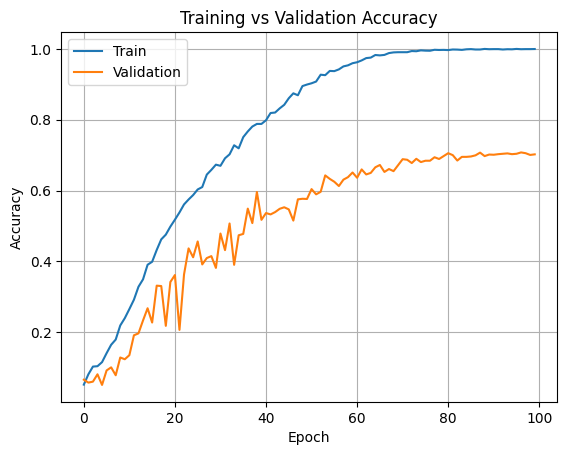

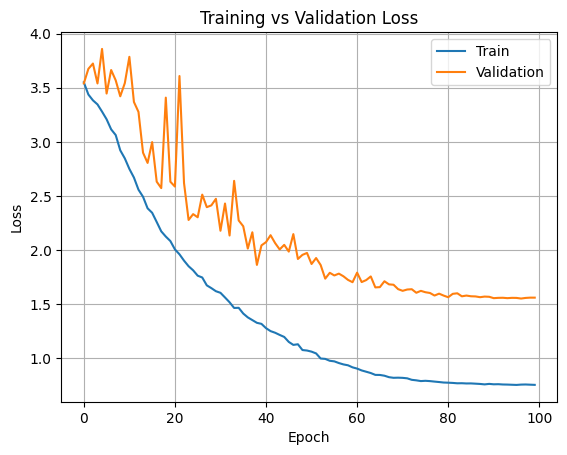

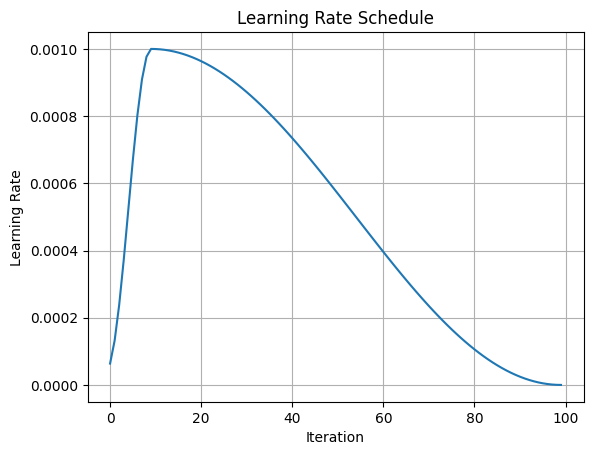

(Net(
   (stem): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
   )
   (stage1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
# Model 5
run_ablation_experiment("No MixUp", config_kwargs={"use_mixup": False})

## **Model variant: No Data Augmentation**

**Change**
- Disabled all data augmentation techniques during training, including MixUp and any other stochastic input transformations.

**Purpose**
- To isolate the contribution of data augmentation to model generalization and performance on unseen data.

=== Running: No Augmentation ===
Total parameters: 11,336,581 | Trainable: 11,336,581


2026/02/16 05:55:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 3.548, Train Acc: 0.055 | Val Loss: 3.517, Val Acc: 0.071 | LR: 6.35e-05


2026/02/16 05:55:28 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:55:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [2/100] | Train Loss: 3.434, Train Acc: 0.082 | Val Loss: 3.628, Val Acc: 0.065 | LR: 1.32e-04


2026/02/16 05:56:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [3/100] | Train Loss: 3.390, Train Acc: 0.096 | Val Loss: 3.452, Val Acc: 0.081 | LR: 2.38e-04


2026/02/16 05:56:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:56:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [4/100] | Train Loss: 3.329, Train Acc: 0.108 | Val Loss: 3.665, Val Acc: 0.068 | LR: 3.72e-04


Epoch [5/100] | Train Loss: 3.282, Train Acc: 0.114 | Val Loss: 4.146, Val Acc: 0.062 | LR: 5.21e-04


Epoch [6/100] | Train Loss: 3.184, Train Acc: 0.146 | Val Loss: 4.165, Val Acc: 0.081 | LR: 6.69e-04


2026/02/16 05:57:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [7/100] | Train Loss: 3.095, Train Acc: 0.162 | Val Loss: 3.334, Val Acc: 0.113 | LR: 8.03e-04


2026/02/16 05:57:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:57:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:57:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [8/100] | Train Loss: 2.996, Train Acc: 0.197 | Val Loss: 3.516, Val Acc: 0.129 | LR: 9.09e-04


2026/02/16 05:57:35 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:57:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [9/100] | Train Loss: 2.884, Train Acc: 0.209 | Val Loss: 3.625, Val Acc: 0.107 | LR: 9.77e-04


Epoch [10/100] | Train Loss: 2.763, Train Acc: 0.261 | Val Loss: 3.777, Val Acc: 0.091 | LR: 1.00e-03


2026/02/16 05:58:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [11/100] | Train Loss: 2.649, Train Acc: 0.290 | Val Loss: 3.298, Val Acc: 0.160 | LR: 1.00e-03


2026/02/16 05:58:25 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:58:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:58:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [12/100] | Train Loss: 2.564, Train Acc: 0.318 | Val Loss: 3.091, Val Acc: 0.174 | LR: 9.99e-04


2026/02/16 05:58:53 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:58:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 05:59:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [13/100] | Train Loss: 2.467, Train Acc: 0.346 | Val Loss: 3.434, Val Acc: 0.201 | LR: 9.97e-04


2026/02/16 05:59:21 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 05:59:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [14/100] | Train Loss: 2.359, Train Acc: 0.389 | Val Loss: 3.279, Val Acc: 0.171 | LR: 9.95e-04


Epoch [15/100] | Train Loss: 2.251, Train Acc: 0.421 | Val Loss: 4.399, Val Acc: 0.171 | LR: 9.92e-04


2026/02/16 06:00:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [16/100] | Train Loss: 2.171, Train Acc: 0.450 | Val Loss: 3.061, Val Acc: 0.229 | LR: 9.89e-04


2026/02/16 06:00:14 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:00:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:00:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [17/100] | Train Loss: 2.085, Train Acc: 0.484 | Val Loss: 2.910, Val Acc: 0.275 | LR: 9.85e-04


2026/02/16 06:00:41 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:00:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [18/100] | Train Loss: 1.992, Train Acc: 0.522 | Val Loss: 3.821, Val Acc: 0.188 | LR: 9.81e-04


Epoch [19/100] | Train Loss: 1.894, Train Acc: 0.563 | Val Loss: 3.426, Val Acc: 0.215 | LR: 9.75e-04


2026/02/16 06:01:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [20/100] | Train Loss: 1.785, Train Acc: 0.601 | Val Loss: 2.648, Val Acc: 0.339 | LR: 9.70e-04


2026/02/16 06:01:28 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:01:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [21/100] | Train Loss: 1.673, Train Acc: 0.657 | Val Loss: 3.301, Val Acc: 0.245 | LR: 9.64e-04


Epoch [22/100] | Train Loss: 1.613, Train Acc: 0.672 | Val Loss: 2.929, Val Acc: 0.290 | LR: 9.57e-04


Epoch [23/100] | Train Loss: 1.498, Train Acc: 0.724 | Val Loss: 4.173, Val Acc: 0.161 | LR: 9.49e-04


Epoch [24/100] | Train Loss: 1.417, Train Acc: 0.754 | Val Loss: 3.373, Val Acc: 0.246 | LR: 9.41e-04


Epoch [25/100] | Train Loss: 1.340, Train Acc: 0.787 | Val Loss: 3.745, Val Acc: 0.260 | LR: 9.33e-04


Epoch [26/100] | Train Loss: 1.252, Train Acc: 0.828 | Val Loss: 2.902, Val Acc: 0.323 | LR: 9.24e-04


Epoch [27/100] | Train Loss: 1.129, Train Acc: 0.889 | Val Loss: 3.093, Val Acc: 0.326 | LR: 9.14e-04


Epoch [28/100] | Train Loss: 1.068, Train Acc: 0.912 | Val Loss: 3.693, Val Acc: 0.256 | LR: 9.04e-04


2026/02/16 06:03:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [29/100] | Train Loss: 1.024, Train Acc: 0.931 | Val Loss: 2.728, Val Acc: 0.352 | LR: 8.94e-04


2026/02/16 06:03:35 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:03:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [30/100] | Train Loss: 0.954, Train Acc: 0.958 | Val Loss: 2.930, Val Acc: 0.314 | LR: 8.83e-04


2026/02/16 06:04:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [31/100] | Train Loss: 0.908, Train Acc: 0.970 | Val Loss: 2.738, Val Acc: 0.356 | LR: 8.71e-04


2026/02/16 06:04:14 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:04:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:04:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [32/100] | Train Loss: 0.875, Train Acc: 0.984 | Val Loss: 2.586, Val Acc: 0.384 | LR: 8.60e-04


2026/02/16 06:04:40 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:04:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [33/100] | Train Loss: 0.846, Train Acc: 0.989 | Val Loss: 2.596, Val Acc: 0.374 | LR: 8.47e-04


Epoch [34/100] | Train Loss: 0.826, Train Acc: 0.993 | Val Loss: 2.625, Val Acc: 0.379 | LR: 8.34e-04


Epoch [35/100] | Train Loss: 0.838, Train Acc: 0.990 | Val Loss: 3.080, Val Acc: 0.300 | LR: 8.21e-04


Epoch [36/100] | Train Loss: 0.814, Train Acc: 0.996 | Val Loss: 2.681, Val Acc: 0.371 | LR: 8.08e-04


Epoch [37/100] | Train Loss: 0.814, Train Acc: 0.991 | Val Loss: 2.654, Val Acc: 0.357 | LR: 7.94e-04


Epoch [38/100] | Train Loss: 0.791, Train Acc: 0.998 | Val Loss: 2.630, Val Acc: 0.363 | LR: 7.79e-04


Epoch [39/100] | Train Loss: 0.782, Train Acc: 0.998 | Val Loss: 2.581, Val Acc: 0.378 | LR: 7.65e-04


Epoch [40/100] | Train Loss: 0.787, Train Acc: 0.998 | Val Loss: 2.635, Val Acc: 0.356 | LR: 7.50e-04


Epoch [41/100] | Train Loss: 0.784, Train Acc: 0.996 | Val Loss: 2.938, Val Acc: 0.310 | LR: 7.35e-04


Epoch [42/100] | Train Loss: 0.774, Train Acc: 0.999 | Val Loss: 2.684, Val Acc: 0.363 | LR: 7.19e-04


Epoch [43/100] | Train Loss: 0.774, Train Acc: 0.998 | Val Loss: 2.713, Val Acc: 0.349 | LR: 7.03e-04


Epoch [44/100] | Train Loss: 0.775, Train Acc: 0.997 | Val Loss: 2.611, Val Acc: 0.374 | LR: 6.87e-04


2026/02/16 06:07:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [45/100] | Train Loss: 0.768, Train Acc: 0.998 | Val Loss: 2.575, Val Acc: 0.391 | LR: 6.71e-04


2026/02/16 06:07:27 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:07:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:07:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [46/100] | Train Loss: 0.759, Train Acc: 0.999 | Val Loss: 2.517, Val Acc: 0.401 | LR: 6.54e-04


2026/02/16 06:07:52 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:07:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [47/100] | Train Loss: 0.754, Train Acc: 0.999 | Val Loss: 2.532, Val Acc: 0.398 | LR: 6.38e-04


Epoch [48/100] | Train Loss: 0.753, Train Acc: 1.000 | Val Loss: 2.558, Val Acc: 0.381 | LR: 6.21e-04


2026/02/16 06:08:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [49/100] | Train Loss: 0.747, Train Acc: 1.000 | Val Loss: 2.522, Val Acc: 0.405 | LR: 6.04e-04


2026/02/16 06:08:41 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:08:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:09:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [50/100] | Train Loss: 0.740, Train Acc: 1.000 | Val Loss: 2.455, Val Acc: 0.412 | LR: 5.87e-04


2026/02/16 06:09:07 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:09:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [51/100] | Train Loss: 0.742, Train Acc: 0.999 | Val Loss: 2.904, Val Acc: 0.309 | LR: 5.69e-04


Epoch [52/100] | Train Loss: 0.744, Train Acc: 0.999 | Val Loss: 2.539, Val Acc: 0.390 | LR: 5.52e-04


2026/02/16 06:09:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [53/100] | Train Loss: 0.740, Train Acc: 1.000 | Val Loss: 2.442, Val Acc: 0.425 | LR: 5.35e-04


2026/02/16 06:09:55 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:10:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [54/100] | Train Loss: 0.738, Train Acc: 1.000 | Val Loss: 2.578, Val Acc: 0.382 | LR: 5.17e-04


Epoch [55/100] | Train Loss: 0.736, Train Acc: 1.000 | Val Loss: 2.536, Val Acc: 0.390 | LR: 5.00e-04


Epoch [56/100] | Train Loss: 0.739, Train Acc: 0.999 | Val Loss: 2.548, Val Acc: 0.383 | LR: 4.82e-04


Epoch [57/100] | Train Loss: 0.738, Train Acc: 1.000 | Val Loss: 2.496, Val Acc: 0.411 | LR: 4.65e-04


Epoch [58/100] | Train Loss: 0.735, Train Acc: 1.000 | Val Loss: 2.504, Val Acc: 0.395 | LR: 4.48e-04


Epoch [59/100] | Train Loss: 0.734, Train Acc: 0.999 | Val Loss: 2.441, Val Acc: 0.423 | LR: 4.30e-04


Epoch [60/100] | Train Loss: 0.729, Train Acc: 1.000 | Val Loss: 2.460, Val Acc: 0.409 | LR: 4.13e-04


Epoch [61/100] | Train Loss: 0.726, Train Acc: 1.000 | Val Loss: 2.555, Val Acc: 0.393 | LR: 3.96e-04


Epoch [62/100] | Train Loss: 0.726, Train Acc: 1.000 | Val Loss: 2.446, Val Acc: 0.425 | LR: 3.79e-04


Epoch [63/100] | Train Loss: 0.722, Train Acc: 1.000 | Val Loss: 2.488, Val Acc: 0.413 | LR: 3.62e-04


Epoch [64/100] | Train Loss: 0.721, Train Acc: 1.000 | Val Loss: 2.424, Val Acc: 0.411 | LR: 3.45e-04


Epoch [65/100] | Train Loss: 0.721, Train Acc: 1.000 | Val Loss: 2.451, Val Acc: 0.411 | LR: 3.29e-04


Epoch [66/100] | Train Loss: 0.718, Train Acc: 1.000 | Val Loss: 2.419, Val Acc: 0.424 | LR: 3.13e-04


Epoch [67/100] | Train Loss: 0.718, Train Acc: 1.000 | Val Loss: 2.545, Val Acc: 0.374 | LR: 2.96e-04


Epoch [68/100] | Train Loss: 0.717, Train Acc: 1.000 | Val Loss: 2.477, Val Acc: 0.403 | LR: 2.81e-04


Epoch [69/100] | Train Loss: 0.715, Train Acc: 1.000 | Val Loss: 2.510, Val Acc: 0.395 | LR: 2.65e-04


Epoch [70/100] | Train Loss: 0.713, Train Acc: 1.000 | Val Loss: 2.481, Val Acc: 0.413 | LR: 2.50e-04


Epoch [71/100] | Train Loss: 0.713, Train Acc: 1.000 | Val Loss: 2.472, Val Acc: 0.407 | LR: 2.35e-04


Epoch [72/100] | Train Loss: 0.712, Train Acc: 1.000 | Val Loss: 2.418, Val Acc: 0.425 | LR: 2.20e-04


2026/02/16 06:14:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [73/100] | Train Loss: 0.712, Train Acc: 1.000 | Val Loss: 2.431, Val Acc: 0.427 | LR: 2.06e-04


2026/02/16 06:14:15 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:14:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [74/100] | Train Loss: 0.710, Train Acc: 1.000 | Val Loss: 2.456, Val Acc: 0.413 | LR: 1.92e-04


2026/02/16 06:14:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [75/100] | Train Loss: 0.709, Train Acc: 1.000 | Val Loss: 2.421, Val Acc: 0.430 | LR: 1.78e-04


2026/02/16 06:14:53 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:14:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [76/100] | Train Loss: 0.709, Train Acc: 1.000 | Val Loss: 2.429, Val Acc: 0.412 | LR: 1.65e-04


Epoch [77/100] | Train Loss: 0.708, Train Acc: 1.000 | Val Loss: 2.433, Val Acc: 0.428 | LR: 1.53e-04


Epoch [78/100] | Train Loss: 0.708, Train Acc: 1.000 | Val Loss: 2.442, Val Acc: 0.427 | LR: 1.40e-04


2026/02/16 06:15:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [79/100] | Train Loss: 0.707, Train Acc: 1.000 | Val Loss: 2.406, Val Acc: 0.432 | LR: 1.28e-04


2026/02/16 06:15:53 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:15:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:16:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [80/100] | Train Loss: 0.707, Train Acc: 1.000 | Val Loss: 2.411, Val Acc: 0.438 | LR: 1.17e-04


2026/02/16 06:16:20 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:16:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [81/100] | Train Loss: 0.705, Train Acc: 1.000 | Val Loss: 2.465, Val Acc: 0.413 | LR: 1.06e-04


Epoch [82/100] | Train Loss: 0.705, Train Acc: 1.000 | Val Loss: 2.435, Val Acc: 0.436 | LR: 9.54e-05


Epoch [83/100] | Train Loss: 0.705, Train Acc: 1.000 | Val Loss: 2.445, Val Acc: 0.423 | LR: 8.54e-05


Epoch [84/100] | Train Loss: 0.704, Train Acc: 1.000 | Val Loss: 2.422, Val Acc: 0.426 | LR: 7.59e-05


Epoch [85/100] | Train Loss: 0.704, Train Acc: 1.000 | Val Loss: 2.431, Val Acc: 0.432 | LR: 6.69e-05


Epoch [86/100] | Train Loss: 0.702, Train Acc: 1.000 | Val Loss: 2.442, Val Acc: 0.424 | LR: 5.85e-05


Epoch [87/100] | Train Loss: 0.705, Train Acc: 1.000 | Val Loss: 2.442, Val Acc: 0.424 | LR: 5.05e-05


Epoch [88/100] | Train Loss: 0.703, Train Acc: 1.000 | Val Loss: 2.427, Val Acc: 0.432 | LR: 4.32e-05


Epoch [89/100] | Train Loss: 0.702, Train Acc: 1.000 | Val Loss: 2.417, Val Acc: 0.435 | LR: 3.64e-05


Epoch [90/100] | Train Loss: 0.702, Train Acc: 1.000 | Val Loss: 2.430, Val Acc: 0.425 | LR: 3.01e-05


Epoch [91/100] | Train Loss: 0.702, Train Acc: 1.000 | Val Loss: 2.419, Val Acc: 0.431 | LR: 2.44e-05


Epoch [92/100] | Train Loss: 0.701, Train Acc: 1.000 | Val Loss: 2.434, Val Acc: 0.426 | LR: 1.93e-05


Epoch [93/100] | Train Loss: 0.702, Train Acc: 1.000 | Val Loss: 2.419, Val Acc: 0.427 | LR: 1.48e-05


Epoch [94/100] | Train Loss: 0.701, Train Acc: 1.000 | Val Loss: 2.421, Val Acc: 0.428 | LR: 1.09e-05


Epoch [95/100] | Train Loss: 0.701, Train Acc: 1.000 | Val Loss: 2.421, Val Acc: 0.432 | LR: 7.57e-06


Epoch [96/100] | Train Loss: 0.701, Train Acc: 1.000 | Val Loss: 2.417, Val Acc: 0.427 | LR: 4.85e-06


Epoch [97/100] | Train Loss: 0.701, Train Acc: 1.000 | Val Loss: 2.426, Val Acc: 0.432 | LR: 2.73e-06


Epoch [98/100] | Train Loss: 0.701, Train Acc: 1.000 | Val Loss: 2.429, Val Acc: 0.431 | LR: 1.21e-06


Epoch [99/100] | Train Loss: 0.701, Train Acc: 1.000 | Val Loss: 2.434, Val Acc: 0.430 | LR: 3.03e-07


Epoch [100/100] | Train Loss: 0.701, Train Acc: 1.000 | Val Loss: 2.412, Val Acc: 0.431 | LR: 4.02e-09
[No Augmentation] Finished! Best Validation Accuracy: 0.438



[No Augmentation] Test Loss: 2.296 | Test Acc: 0.464


2026/02/16 06:20:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 06:20:39 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:20:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run No Augmentation at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/e35c98ec9b6d4d7a9c6acc82659954fb
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


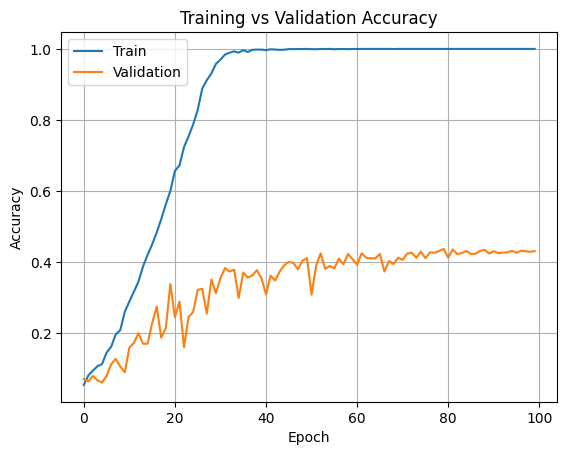

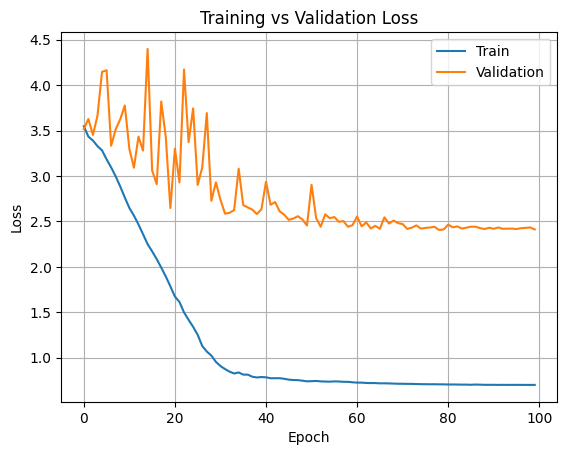

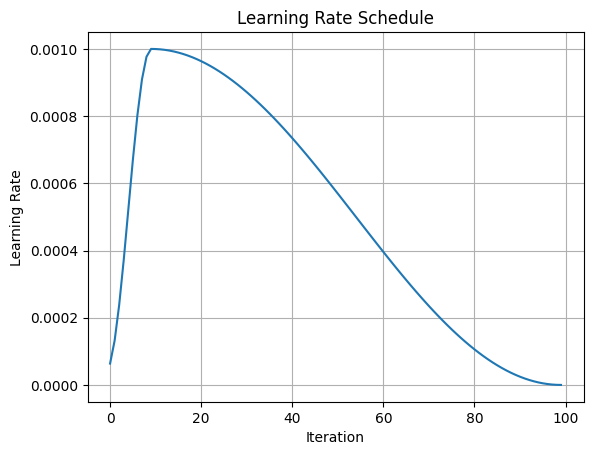

(Net(
   (stem): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
   )
   (stage1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
# Model 6 (Requires custom dataset/loader logic first)
train_transform2 = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
train_dataset2 = OxfordPetDataset(split="train", transform=train_transform2)
train_loader2 = DataLoader(train_dataset2, batch_size=32, shuffle=True, num_workers=2)

run_ablation_experiment(
    "No Augmentation",
    config_kwargs={"use_mixup": False},
    custom_train_dataset=train_dataset2,
    custom_train_loader=train_loader2,
)

## **Model variant: No Stem Layer**

**Change**
- Removed the convolutional stem (7×7 convolution, Batch Normalization, ReLU, and max pooling), feeding inputs directly into the first stage of the network.

**Purpose**
- To investigate the importance of early-stage feature extraction and aggressive spatial downsampling.

=== Running: No StemLayer ===
Total parameters: 11,309,669 | Trainable: 11,309,669


2026/02/16 06:21:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 3.561, Train Acc: 0.054 | Val Loss: 3.539, Val Acc: 0.067 | LR: 6.35e-05


2026/02/16 06:21:29 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:21:35 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [2/100] | Train Loss: 3.458, Train Acc: 0.087 | Val Loss: 3.686, Val Acc: 0.064 | LR: 1.32e-04


2026/02/16 06:22:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [3/100] | Train Loss: 3.435, Train Acc: 0.099 | Val Loss: 3.492, Val Acc: 0.087 | LR: 2.38e-04


2026/02/16 06:22:49 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:22:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:23:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [4/100] | Train Loss: 3.379, Train Acc: 0.104 | Val Loss: 3.444, Val Acc: 0.089 | LR: 3.72e-04


2026/02/16 06:23:37 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:23:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:24:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [5/100] | Train Loss: 3.332, Train Acc: 0.126 | Val Loss: 3.419, Val Acc: 0.099 | LR: 5.21e-04


2026/02/16 06:24:23 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:24:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [6/100] | Train Loss: 3.252, Train Acc: 0.147 | Val Loss: 3.885, Val Acc: 0.070 | LR: 6.69e-04


2026/02/16 06:25:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [7/100] | Train Loss: 3.203, Train Acc: 0.154 | Val Loss: 3.422, Val Acc: 0.106 | LR: 8.03e-04


2026/02/16 06:25:42 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:25:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [8/100] | Train Loss: 3.154, Train Acc: 0.178 | Val Loss: 3.872, Val Acc: 0.093 | LR: 9.09e-04


2026/02/16 06:26:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [9/100] | Train Loss: 3.116, Train Acc: 0.184 | Val Loss: 3.344, Val Acc: 0.136 | LR: 9.77e-04


2026/02/16 06:27:00 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:27:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [10/100] | Train Loss: 3.009, Train Acc: 0.220 | Val Loss: 4.390, Val Acc: 0.110 | LR: 1.00e-03


2026/02/16 06:28:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [11/100] | Train Loss: 2.981, Train Acc: 0.224 | Val Loss: 3.375, Val Acc: 0.139 | LR: 1.00e-03


2026/02/16 06:28:19 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:28:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:29:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [12/100] | Train Loss: 2.927, Train Acc: 0.248 | Val Loss: 3.577, Val Acc: 0.142 | LR: 9.99e-04


2026/02/16 06:29:06 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:29:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:29:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [13/100] | Train Loss: 2.947, Train Acc: 0.251 | Val Loss: 3.016, Val Acc: 0.187 | LR: 9.97e-04


2026/02/16 06:29:49 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:29:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [14/100] | Train Loss: 2.836, Train Acc: 0.284 | Val Loss: 3.364, Val Acc: 0.138 | LR: 9.95e-04


Epoch [15/100] | Train Loss: 2.786, Train Acc: 0.295 | Val Loss: 3.289, Val Acc: 0.159 | LR: 9.92e-04


Epoch [16/100] | Train Loss: 2.815, Train Acc: 0.299 | Val Loss: 3.767, Val Acc: 0.122 | LR: 9.89e-04


2026/02/16 06:32:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [17/100] | Train Loss: 2.741, Train Acc: 0.325 | Val Loss: 2.849, Val Acc: 0.250 | LR: 9.85e-04


2026/02/16 06:32:06 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:32:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:32:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [18/100] | Train Loss: 2.693, Train Acc: 0.333 | Val Loss: 2.812, Val Acc: 0.272 | LR: 9.81e-04


2026/02/16 06:32:53 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:32:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [19/100] | Train Loss: 2.685, Train Acc: 0.348 | Val Loss: 3.031, Val Acc: 0.214 | LR: 9.75e-04


2026/02/16 06:34:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [20/100] | Train Loss: 2.587, Train Acc: 0.368 | Val Loss: 2.773, Val Acc: 0.288 | LR: 9.70e-04


2026/02/16 06:34:10 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:34:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:34:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [21/100] | Train Loss: 2.607, Train Acc: 0.383 | Val Loss: 2.674, Val Acc: 0.306 | LR: 9.64e-04


2026/02/16 06:34:56 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:35:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [22/100] | Train Loss: 2.574, Train Acc: 0.389 | Val Loss: 2.931, Val Acc: 0.253 | LR: 9.57e-04


Epoch [23/100] | Train Loss: 2.535, Train Acc: 0.413 | Val Loss: 2.859, Val Acc: 0.263 | LR: 9.49e-04


Epoch [24/100] | Train Loss: 2.462, Train Acc: 0.436 | Val Loss: 3.047, Val Acc: 0.235 | LR: 9.41e-04


Epoch [25/100] | Train Loss: 2.432, Train Acc: 0.438 | Val Loss: 2.861, Val Acc: 0.268 | LR: 9.33e-04


Epoch [26/100] | Train Loss: 2.424, Train Acc: 0.449 | Val Loss: 3.472, Val Acc: 0.242 | LR: 9.24e-04


2026/02/16 06:38:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [27/100] | Train Loss: 2.360, Train Acc: 0.472 | Val Loss: 2.674, Val Acc: 0.307 | LR: 9.14e-04


2026/02/16 06:38:15 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:38:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:38:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [28/100] | Train Loss: 2.327, Train Acc: 0.492 | Val Loss: 2.965, Val Acc: 0.316 | LR: 9.04e-04


2026/02/16 06:39:00 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:39:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:39:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [29/100] | Train Loss: 2.316, Train Acc: 0.497 | Val Loss: 2.466, Val Acc: 0.358 | LR: 8.94e-04


2026/02/16 06:39:46 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:39:51 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:40:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [30/100] | Train Loss: 2.246, Train Acc: 0.509 | Val Loss: 2.505, Val Acc: 0.381 | LR: 8.83e-04


2026/02/16 06:40:32 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:40:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 06:41:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [31/100] | Train Loss: 2.237, Train Acc: 0.526 | Val Loss: 2.346, Val Acc: 0.393 | LR: 8.71e-04


2026/02/16 06:41:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:41:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [32/100] | Train Loss: 2.212, Train Acc: 0.540 | Val Loss: 2.446, Val Acc: 0.373 | LR: 8.60e-04


2026/02/16 06:42:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [33/100] | Train Loss: 2.149, Train Acc: 0.560 | Val Loss: 2.225, Val Acc: 0.449 | LR: 8.47e-04


2026/02/16 06:42:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:42:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [34/100] | Train Loss: 2.137, Train Acc: 0.570 | Val Loss: 2.949, Val Acc: 0.270 | LR: 8.34e-04


Epoch [35/100] | Train Loss: 2.196, Train Acc: 0.561 | Val Loss: 2.678, Val Acc: 0.318 | LR: 8.21e-04


Epoch [36/100] | Train Loss: 2.011, Train Acc: 0.605 | Val Loss: 2.512, Val Acc: 0.375 | LR: 8.08e-04


Epoch [37/100] | Train Loss: 2.038, Train Acc: 0.604 | Val Loss: 2.525, Val Acc: 0.347 | LR: 7.94e-04


Epoch [38/100] | Train Loss: 2.016, Train Acc: 0.624 | Val Loss: 2.583, Val Acc: 0.358 | LR: 7.79e-04


Epoch [39/100] | Train Loss: 1.942, Train Acc: 0.650 | Val Loss: 2.561, Val Acc: 0.364 | LR: 7.65e-04


2026/02/16 06:46:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [40/100] | Train Loss: 1.952, Train Acc: 0.646 | Val Loss: 2.108, Val Acc: 0.509 | LR: 7.50e-04


2026/02/16 06:46:26 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:46:31 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [41/100] | Train Loss: 1.968, Train Acc: 0.646 | Val Loss: 2.294, Val Acc: 0.430 | LR: 7.35e-04


Epoch [42/100] | Train Loss: 1.932, Train Acc: 0.661 | Val Loss: 2.240, Val Acc: 0.454 | LR: 7.19e-04


2026/02/16 06:48:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [43/100] | Train Loss: 2.002, Train Acc: 0.643 | Val Loss: 1.960, Val Acc: 0.551 | LR: 7.03e-04


2026/02/16 06:48:13 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:48:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [44/100] | Train Loss: 1.881, Train Acc: 0.665 | Val Loss: 2.166, Val Acc: 0.493 | LR: 6.87e-04


Epoch [45/100] | Train Loss: 1.915, Train Acc: 0.674 | Val Loss: 2.091, Val Acc: 0.498 | LR: 6.71e-04


Epoch [46/100] | Train Loss: 1.766, Train Acc: 0.710 | Val Loss: 2.183, Val Acc: 0.475 | LR: 6.54e-04


2026/02/16 06:50:28 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [47/100] | Train Loss: 1.865, Train Acc: 0.711 | Val Loss: 1.923, Val Acc: 0.573 | LR: 6.38e-04


2026/02/16 06:50:32 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:50:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [48/100] | Train Loss: 1.744, Train Acc: 0.741 | Val Loss: 1.963, Val Acc: 0.562 | LR: 6.21e-04


Epoch [49/100] | Train Loss: 1.835, Train Acc: 0.720 | Val Loss: 1.991, Val Acc: 0.538 | LR: 6.04e-04


Epoch [50/100] | Train Loss: 1.805, Train Acc: 0.719 | Val Loss: 1.914, Val Acc: 0.563 | LR: 5.87e-04


Epoch [51/100] | Train Loss: 1.705, Train Acc: 0.751 | Val Loss: 1.984, Val Acc: 0.532 | LR: 5.69e-04


Epoch [52/100] | Train Loss: 1.694, Train Acc: 0.760 | Val Loss: 2.239, Val Acc: 0.461 | LR: 5.52e-04


2026/02/16 06:53:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [53/100] | Train Loss: 1.689, Train Acc: 0.759 | Val Loss: 1.860, Val Acc: 0.579 | LR: 5.35e-04


2026/02/16 06:53:55 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:54:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [54/100] | Train Loss: 1.700, Train Acc: 0.774 | Val Loss: 1.990, Val Acc: 0.560 | LR: 5.17e-04


2026/02/16 06:55:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [55/100] | Train Loss: 1.671, Train Acc: 0.769 | Val Loss: 1.932, Val Acc: 0.587 | LR: 5.00e-04


2026/02/16 06:55:13 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:55:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [56/100] | Train Loss: 1.689, Train Acc: 0.776 | Val Loss: 1.868, Val Acc: 0.563 | LR: 4.82e-04


Epoch [57/100] | Train Loss: 1.606, Train Acc: 0.793 | Val Loss: 1.959, Val Acc: 0.565 | LR: 4.65e-04


2026/02/16 06:56:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [58/100] | Train Loss: 1.601, Train Acc: 0.805 | Val Loss: 1.752, Val Acc: 0.636 | LR: 4.48e-04


2026/02/16 06:56:59 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:57:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [59/100] | Train Loss: 1.604, Train Acc: 0.811 | Val Loss: 1.777, Val Acc: 0.611 | LR: 4.30e-04


Epoch [60/100] | Train Loss: 1.554, Train Acc: 0.809 | Val Loss: 1.843, Val Acc: 0.592 | LR: 4.13e-04


2026/02/16 06:58:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [61/100] | Train Loss: 1.585, Train Acc: 0.805 | Val Loss: 1.729, Val Acc: 0.642 | LR: 3.96e-04


2026/02/16 06:58:49 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 06:58:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [62/100] | Train Loss: 1.572, Train Acc: 0.831 | Val Loss: 1.821, Val Acc: 0.608 | LR: 3.79e-04


Epoch [63/100] | Train Loss: 1.590, Train Acc: 0.828 | Val Loss: 1.749, Val Acc: 0.640 | LR: 3.62e-04


Epoch [64/100] | Train Loss: 1.517, Train Acc: 0.860 | Val Loss: 1.740, Val Acc: 0.630 | LR: 3.45e-04


Epoch [65/100] | Train Loss: 1.449, Train Acc: 0.867 | Val Loss: 1.764, Val Acc: 0.633 | LR: 3.29e-04


2026/02/16 07:01:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [66/100] | Train Loss: 1.498, Train Acc: 0.842 | Val Loss: 1.601, Val Acc: 0.688 | LR: 3.13e-04


2026/02/16 07:01:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:01:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [67/100] | Train Loss: 1.462, Train Acc: 0.861 | Val Loss: 1.659, Val Acc: 0.659 | LR: 2.96e-04


Epoch [68/100] | Train Loss: 1.508, Train Acc: 0.865 | Val Loss: 1.594, Val Acc: 0.686 | LR: 2.81e-04


Epoch [69/100] | Train Loss: 1.518, Train Acc: 0.859 | Val Loss: 1.627, Val Acc: 0.683 | LR: 2.65e-04


Epoch [70/100] | Train Loss: 1.514, Train Acc: 0.865 | Val Loss: 1.629, Val Acc: 0.679 | LR: 2.50e-04


Epoch [71/100] | Train Loss: 1.365, Train Acc: 0.894 | Val Loss: 1.593, Val Acc: 0.669 | LR: 2.35e-04


2026/02/16 07:04:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [72/100] | Train Loss: 1.404, Train Acc: 0.891 | Val Loss: 1.601, Val Acc: 0.696 | LR: 2.20e-04


2026/02/16 07:05:00 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:05:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [73/100] | Train Loss: 1.471, Train Acc: 0.882 | Val Loss: 1.621, Val Acc: 0.680 | LR: 2.06e-04


Epoch [74/100] | Train Loss: 1.321, Train Acc: 0.904 | Val Loss: 1.566, Val Acc: 0.696 | LR: 1.92e-04


2026/02/16 07:06:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [75/100] | Train Loss: 1.385, Train Acc: 0.901 | Val Loss: 1.555, Val Acc: 0.701 | LR: 1.78e-04


2026/02/16 07:06:48 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:06:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:07:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [76/100] | Train Loss: 1.405, Train Acc: 0.896 | Val Loss: 1.553, Val Acc: 0.710 | LR: 1.65e-04


2026/02/16 07:07:34 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:07:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [77/100] | Train Loss: 1.418, Train Acc: 0.906 | Val Loss: 1.556, Val Acc: 0.693 | LR: 1.53e-04


Epoch [78/100] | Train Loss: 1.355, Train Acc: 0.913 | Val Loss: 1.578, Val Acc: 0.689 | LR: 1.40e-04


Epoch [79/100] | Train Loss: 1.291, Train Acc: 0.928 | Val Loss: 1.574, Val Acc: 0.702 | LR: 1.28e-04


2026/02/16 07:09:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [80/100] | Train Loss: 1.375, Train Acc: 0.905 | Val Loss: 1.558, Val Acc: 0.712 | LR: 1.17e-04


2026/02/16 07:09:52 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:09:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [81/100] | Train Loss: 1.369, Train Acc: 0.911 | Val Loss: 1.580, Val Acc: 0.710 | LR: 1.06e-04


2026/02/16 07:11:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [82/100] | Train Loss: 1.307, Train Acc: 0.930 | Val Loss: 1.531, Val Acc: 0.716 | LR: 9.54e-05


2026/02/16 07:11:11 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:11:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [83/100] | Train Loss: 1.311, Train Acc: 0.897 | Val Loss: 1.572, Val Acc: 0.703 | LR: 8.54e-05


Epoch [84/100] | Train Loss: 1.410, Train Acc: 0.907 | Val Loss: 1.536, Val Acc: 0.714 | LR: 7.59e-05


2026/02/16 07:12:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [85/100] | Train Loss: 1.273, Train Acc: 0.931 | Val Loss: 1.518, Val Acc: 0.725 | LR: 6.69e-05


2026/02/16 07:12:58 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:13:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [86/100] | Train Loss: 1.279, Train Acc: 0.934 | Val Loss: 1.519, Val Acc: 0.721 | LR: 5.85e-05


Epoch [87/100] | Train Loss: 1.351, Train Acc: 0.930 | Val Loss: 1.514, Val Acc: 0.717 | LR: 5.05e-05


Epoch [88/100] | Train Loss: 1.501, Train Acc: 0.894 | Val Loss: 1.508, Val Acc: 0.720 | LR: 4.32e-05


Epoch [89/100] | Train Loss: 1.353, Train Acc: 0.923 | Val Loss: 1.517, Val Acc: 0.720 | LR: 3.64e-05


Epoch [90/100] | Train Loss: 1.418, Train Acc: 0.902 | Val Loss: 1.530, Val Acc: 0.721 | LR: 3.01e-05


Epoch [91/100] | Train Loss: 1.369, Train Acc: 0.911 | Val Loss: 1.516, Val Acc: 0.720 | LR: 2.44e-05


Epoch [92/100] | Train Loss: 1.428, Train Acc: 0.910 | Val Loss: 1.522, Val Acc: 0.720 | LR: 1.93e-05


Epoch [93/100] | Train Loss: 1.338, Train Acc: 0.931 | Val Loss: 1.529, Val Acc: 0.718 | LR: 1.48e-05


Epoch [94/100] | Train Loss: 1.389, Train Acc: 0.918 | Val Loss: 1.503, Val Acc: 0.720 | LR: 1.09e-05


Epoch [95/100] | Train Loss: 1.301, Train Acc: 0.924 | Val Loss: 1.509, Val Acc: 0.722 | LR: 7.57e-06


Epoch [96/100] | Train Loss: 1.330, Train Acc: 0.925 | Val Loss: 1.507, Val Acc: 0.724 | LR: 4.85e-06


Epoch [97/100] | Train Loss: 1.345, Train Acc: 0.920 | Val Loss: 1.521, Val Acc: 0.724 | LR: 2.73e-06


2026/02/16 07:19:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [98/100] | Train Loss: 1.306, Train Acc: 0.936 | Val Loss: 1.499, Val Acc: 0.726 | LR: 1.21e-06


2026/02/16 07:20:00 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:20:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [99/100] | Train Loss: 1.251, Train Acc: 0.943 | Val Loss: 1.503, Val Acc: 0.724 | LR: 3.03e-07


Epoch [100/100] | Train Loss: 1.303, Train Acc: 0.933 | Val Loss: 1.505, Val Acc: 0.725 | LR: 4.02e-09
[No StemLayer] Finished! Best Validation Accuracy: 0.726



[No StemLayer] Test Loss: 1.423 | Test Acc: 0.751


2026/02/16 07:21:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 07:21:23 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:21:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run No StemLayer at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/5c9a4418c1b24190804fc162843c3cbc
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


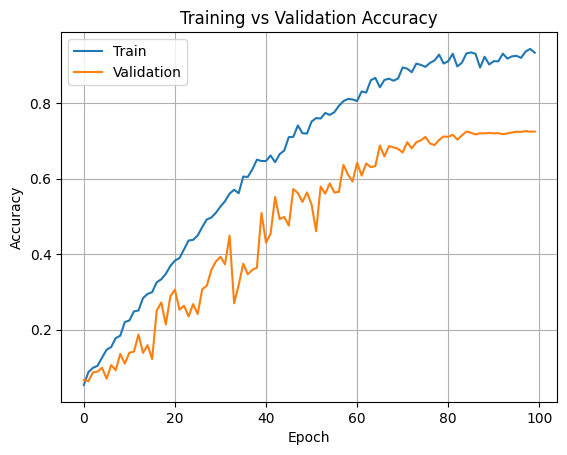

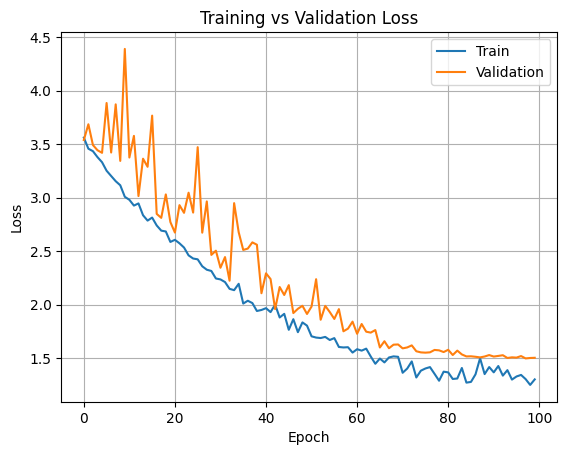

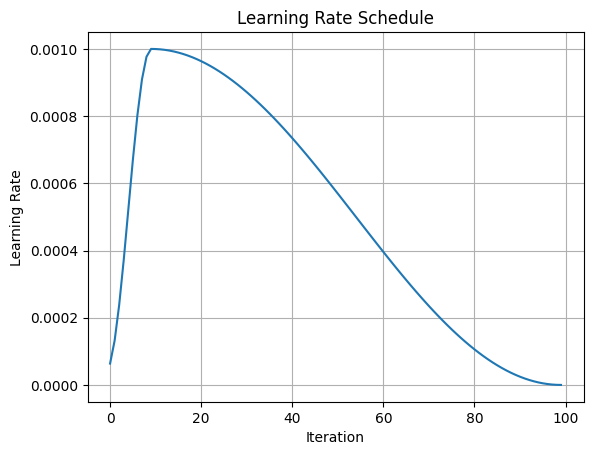

(Net(
   (stem): Sequential(
     (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
   )
   (stage1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [ ]:
# Model 7
run_ablation_experiment("No StemLayer", model_kwargs={"use_stem": False})

## **Model variant: No Residual Blocks**

**Change**
- Replaced all residual blocks with plain convolutional blocks, removing skip connections while preserving depth and channel dimensions.

**Purpose**
- To evaluate the contribution of residual connections to optimization stability and final accuracy.

=== Running: No Residual ===
Total parameters: 4,892,037 | Trainable: 4,892,037


2026/02/16 07:21:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 3.581, Train Acc: 0.043 | Val Loss: 3.542, Val Acc: 0.056 | LR: 6.35e-05


2026/02/16 07:21:56 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:22:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:22:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [2/100] | Train Loss: 3.495, Train Acc: 0.074 | Val Loss: 3.487, Val Acc: 0.079 | LR: 1.32e-04


2026/02/16 07:22:24 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:22:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [3/100] | Train Loss: 3.443, Train Acc: 0.090 | Val Loss: 3.577, Val Acc: 0.064 | LR: 2.38e-04


Epoch [4/100] | Train Loss: 3.392, Train Acc: 0.107 | Val Loss: 3.884, Val Acc: 0.050 | LR: 3.72e-04


Epoch [5/100] | Train Loss: 3.351, Train Acc: 0.111 | Val Loss: 3.552, Val Acc: 0.068 | LR: 5.21e-04


2026/02/16 07:23:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [6/100] | Train Loss: 3.304, Train Acc: 0.129 | Val Loss: 3.394, Val Acc: 0.112 | LR: 6.69e-04


2026/02/16 07:23:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:23:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:24:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [7/100] | Train Loss: 3.243, Train Acc: 0.141 | Val Loss: 3.386, Val Acc: 0.113 | LR: 8.03e-04


2026/02/16 07:24:07 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:24:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:24:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [8/100] | Train Loss: 3.172, Train Acc: 0.167 | Val Loss: 3.229, Val Acc: 0.144 | LR: 9.09e-04


2026/02/16 07:24:34 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:24:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:24:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [9/100] | Train Loss: 3.138, Train Acc: 0.179 | Val Loss: 3.210, Val Acc: 0.148 | LR: 9.77e-04


2026/02/16 07:25:01 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:25:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [10/100] | Train Loss: 3.061, Train Acc: 0.206 | Val Loss: 3.287, Val Acc: 0.131 | LR: 1.00e-03


2026/02/16 07:25:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [11/100] | Train Loss: 2.988, Train Acc: 0.223 | Val Loss: 3.013, Val Acc: 0.196 | LR: 1.00e-03


2026/02/16 07:25:42 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:25:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [12/100] | Train Loss: 2.894, Train Acc: 0.261 | Val Loss: 3.337, Val Acc: 0.144 | LR: 9.99e-04


Epoch [13/100] | Train Loss: 2.867, Train Acc: 0.275 | Val Loss: 3.316, Val Acc: 0.132 | LR: 9.97e-04


2026/02/16 07:26:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [14/100] | Train Loss: 2.800, Train Acc: 0.282 | Val Loss: 2.883, Val Acc: 0.248 | LR: 9.95e-04


2026/02/16 07:26:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:26:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [15/100] | Train Loss: 2.773, Train Acc: 0.314 | Val Loss: 3.300, Val Acc: 0.179 | LR: 9.92e-04


Epoch [16/100] | Train Loss: 2.696, Train Acc: 0.330 | Val Loss: 3.058, Val Acc: 0.225 | LR: 9.89e-04


Epoch [17/100] | Train Loss: 2.671, Train Acc: 0.342 | Val Loss: 3.680, Val Acc: 0.149 | LR: 9.85e-04


Epoch [18/100] | Train Loss: 2.652, Train Acc: 0.349 | Val Loss: 3.170, Val Acc: 0.218 | LR: 9.81e-04


2026/02/16 07:27:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [19/100] | Train Loss: 2.639, Train Acc: 0.370 | Val Loss: 2.932, Val Acc: 0.250 | LR: 9.75e-04


2026/02/16 07:27:58 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:28:03 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:28:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [20/100] | Train Loss: 2.578, Train Acc: 0.374 | Val Loss: 2.796, Val Acc: 0.282 | LR: 9.70e-04


2026/02/16 07:28:24 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:28:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [21/100] | Train Loss: 2.502, Train Acc: 0.412 | Val Loss: 2.739, Val Acc: 0.278 | LR: 9.64e-04


2026/02/16 07:29:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [22/100] | Train Loss: 2.456, Train Acc: 0.417 | Val Loss: 2.511, Val Acc: 0.362 | LR: 9.57e-04


2026/02/16 07:29:05 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:29:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [23/100] | Train Loss: 2.413, Train Acc: 0.452 | Val Loss: 2.592, Val Acc: 0.317 | LR: 9.49e-04


Epoch [24/100] | Train Loss: 2.444, Train Acc: 0.445 | Val Loss: 2.727, Val Acc: 0.281 | LR: 9.41e-04


Epoch [25/100] | Train Loss: 2.371, Train Acc: 0.463 | Val Loss: 2.819, Val Acc: 0.282 | LR: 9.33e-04


Epoch [26/100] | Train Loss: 2.360, Train Acc: 0.469 | Val Loss: 2.557, Val Acc: 0.330 | LR: 9.24e-04


Epoch [27/100] | Train Loss: 2.242, Train Acc: 0.504 | Val Loss: 2.482, Val Acc: 0.362 | LR: 9.14e-04


2026/02/16 07:30:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [28/100] | Train Loss: 2.223, Train Acc: 0.531 | Val Loss: 2.486, Val Acc: 0.370 | LR: 9.04e-04


2026/02/16 07:30:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:30:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:31:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [29/100] | Train Loss: 2.207, Train Acc: 0.535 | Val Loss: 2.376, Val Acc: 0.405 | LR: 8.94e-04


2026/02/16 07:31:05 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:31:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:31:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [30/100] | Train Loss: 2.171, Train Acc: 0.548 | Val Loss: 2.383, Val Acc: 0.407 | LR: 8.83e-04


2026/02/16 07:31:31 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:31:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [31/100] | Train Loss: 2.152, Train Acc: 0.560 | Val Loss: 2.654, Val Acc: 0.306 | LR: 8.71e-04


2026/02/16 07:32:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [32/100] | Train Loss: 2.103, Train Acc: 0.571 | Val Loss: 2.263, Val Acc: 0.436 | LR: 8.60e-04


2026/02/16 07:32:11 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:32:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [33/100] | Train Loss: 2.014, Train Acc: 0.606 | Val Loss: 2.528, Val Acc: 0.357 | LR: 8.47e-04


Epoch [34/100] | Train Loss: 2.052, Train Acc: 0.609 | Val Loss: 2.463, Val Acc: 0.394 | LR: 8.34e-04


Epoch [35/100] | Train Loss: 2.035, Train Acc: 0.609 | Val Loss: 2.328, Val Acc: 0.423 | LR: 8.21e-04


2026/02/16 07:33:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [36/100] | Train Loss: 1.967, Train Acc: 0.631 | Val Loss: 2.329, Val Acc: 0.439 | LR: 8.08e-04


2026/02/16 07:33:21 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:33:26 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:33:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [37/100] | Train Loss: 1.902, Train Acc: 0.639 | Val Loss: 2.092, Val Acc: 0.486 | LR: 7.94e-04


2026/02/16 07:33:48 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:33:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:34:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [38/100] | Train Loss: 1.920, Train Acc: 0.652 | Val Loss: 2.081, Val Acc: 0.495 | LR: 7.79e-04


2026/02/16 07:34:15 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:34:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [39/100] | Train Loss: 1.978, Train Acc: 0.650 | Val Loss: 2.192, Val Acc: 0.472 | LR: 7.65e-04


Epoch [40/100] | Train Loss: 1.830, Train Acc: 0.673 | Val Loss: 2.388, Val Acc: 0.425 | LR: 7.50e-04


2026/02/16 07:35:05 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [41/100] | Train Loss: 1.895, Train Acc: 0.674 | Val Loss: 2.134, Val Acc: 0.498 | LR: 7.35e-04


2026/02/16 07:35:09 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:35:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:35:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [42/100] | Train Loss: 1.926, Train Acc: 0.680 | Val Loss: 2.092, Val Acc: 0.505 | LR: 7.19e-04


2026/02/16 07:35:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:35:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [43/100] | Train Loss: 1.752, Train Acc: 0.711 | Val Loss: 2.130, Val Acc: 0.466 | LR: 7.03e-04


Epoch [44/100] | Train Loss: 1.888, Train Acc: 0.685 | Val Loss: 2.150, Val Acc: 0.487 | LR: 6.87e-04


Epoch [45/100] | Train Loss: 1.751, Train Acc: 0.711 | Val Loss: 2.259, Val Acc: 0.466 | LR: 6.71e-04


Epoch [46/100] | Train Loss: 1.749, Train Acc: 0.740 | Val Loss: 2.135, Val Acc: 0.504 | LR: 6.54e-04


2026/02/16 07:36:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [47/100] | Train Loss: 1.753, Train Acc: 0.735 | Val Loss: 2.085, Val Acc: 0.509 | LR: 6.38e-04


2026/02/16 07:37:00 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:37:05 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:37:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [48/100] | Train Loss: 1.668, Train Acc: 0.757 | Val Loss: 1.948, Val Acc: 0.548 | LR: 6.21e-04


2026/02/16 07:37:27 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:37:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [49/100] | Train Loss: 1.782, Train Acc: 0.743 | Val Loss: 2.077, Val Acc: 0.515 | LR: 6.04e-04


Epoch [50/100] | Train Loss: 1.820, Train Acc: 0.716 | Val Loss: 2.029, Val Acc: 0.528 | LR: 5.87e-04


2026/02/16 07:38:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [51/100] | Train Loss: 1.769, Train Acc: 0.754 | Val Loss: 1.954, Val Acc: 0.553 | LR: 5.69e-04


2026/02/16 07:38:29 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:38:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [52/100] | Train Loss: 1.673, Train Acc: 0.765 | Val Loss: 2.018, Val Acc: 0.515 | LR: 5.52e-04


Epoch [53/100] | Train Loss: 1.675, Train Acc: 0.764 | Val Loss: 2.073, Val Acc: 0.511 | LR: 5.35e-04


2026/02/16 07:39:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [54/100] | Train Loss: 1.692, Train Acc: 0.768 | Val Loss: 1.893, Val Acc: 0.571 | LR: 5.17e-04


2026/02/16 07:39:26 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:39:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [55/100] | Train Loss: 1.654, Train Acc: 0.796 | Val Loss: 2.000, Val Acc: 0.540 | LR: 5.00e-04


2026/02/16 07:40:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [56/100] | Train Loss: 1.730, Train Acc: 0.779 | Val Loss: 1.785, Val Acc: 0.618 | LR: 4.82e-04


2026/02/16 07:40:09 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:40:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [57/100] | Train Loss: 1.606, Train Acc: 0.819 | Val Loss: 1.796, Val Acc: 0.601 | LR: 4.65e-04


Epoch [58/100] | Train Loss: 1.540, Train Acc: 0.815 | Val Loss: 1.865, Val Acc: 0.588 | LR: 4.48e-04


Epoch [59/100] | Train Loss: 1.588, Train Acc: 0.829 | Val Loss: 1.864, Val Acc: 0.593 | LR: 4.30e-04


Epoch [60/100] | Train Loss: 1.629, Train Acc: 0.803 | Val Loss: 1.839, Val Acc: 0.595 | LR: 4.13e-04


Epoch [61/100] | Train Loss: 1.543, Train Acc: 0.828 | Val Loss: 1.842, Val Acc: 0.582 | LR: 3.96e-04


2026/02/16 07:41:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [62/100] | Train Loss: 1.543, Train Acc: 0.824 | Val Loss: 1.818, Val Acc: 0.620 | LR: 3.79e-04


2026/02/16 07:41:45 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:41:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [63/100] | Train Loss: 1.475, Train Acc: 0.856 | Val Loss: 1.732, Val Acc: 0.619 | LR: 3.62e-04


Epoch [64/100] | Train Loss: 1.517, Train Acc: 0.856 | Val Loss: 1.782, Val Acc: 0.610 | LR: 3.45e-04


2026/02/16 07:42:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [65/100] | Train Loss: 1.535, Train Acc: 0.844 | Val Loss: 1.788, Val Acc: 0.621 | LR: 3.29e-04


2026/02/16 07:42:40 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:42:45 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:43:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [66/100] | Train Loss: 1.487, Train Acc: 0.864 | Val Loss: 1.715, Val Acc: 0.648 | LR: 3.13e-04


2026/02/16 07:43:07 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:43:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:43:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [67/100] | Train Loss: 1.566, Train Acc: 0.849 | Val Loss: 1.715, Val Acc: 0.655 | LR: 2.96e-04


2026/02/16 07:43:33 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:43:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [68/100] | Train Loss: 1.477, Train Acc: 0.859 | Val Loss: 1.744, Val Acc: 0.630 | LR: 2.81e-04


Epoch [69/100] | Train Loss: 1.438, Train Acc: 0.880 | Val Loss: 1.731, Val Acc: 0.640 | LR: 2.65e-04


Epoch [70/100] | Train Loss: 1.406, Train Acc: 0.884 | Val Loss: 1.769, Val Acc: 0.622 | LR: 2.50e-04


Epoch [71/100] | Train Loss: 1.450, Train Acc: 0.866 | Val Loss: 1.689, Val Acc: 0.652 | LR: 2.35e-04


Epoch [72/100] | Train Loss: 1.447, Train Acc: 0.886 | Val Loss: 1.681, Val Acc: 0.652 | LR: 2.20e-04


2026/02/16 07:45:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [73/100] | Train Loss: 1.454, Train Acc: 0.881 | Val Loss: 1.677, Val Acc: 0.657 | LR: 2.06e-04


2026/02/16 07:45:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:45:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:45:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [74/100] | Train Loss: 1.360, Train Acc: 0.895 | Val Loss: 1.646, Val Acc: 0.676 | LR: 1.92e-04


2026/02/16 07:45:35 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:45:40 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [75/100] | Train Loss: 1.410, Train Acc: 0.893 | Val Loss: 1.654, Val Acc: 0.670 | LR: 1.78e-04


Epoch [76/100] | Train Loss: 1.310, Train Acc: 0.913 | Val Loss: 1.680, Val Acc: 0.663 | LR: 1.65e-04


Epoch [77/100] | Train Loss: 1.447, Train Acc: 0.879 | Val Loss: 1.697, Val Acc: 0.656 | LR: 1.53e-04


Epoch [78/100] | Train Loss: 1.399, Train Acc: 0.908 | Val Loss: 1.656, Val Acc: 0.673 | LR: 1.40e-04


Epoch [79/100] | Train Loss: 1.467, Train Acc: 0.883 | Val Loss: 1.700, Val Acc: 0.654 | LR: 1.28e-04


Epoch [80/100] | Train Loss: 1.375, Train Acc: 0.907 | Val Loss: 1.645, Val Acc: 0.671 | LR: 1.17e-04


Epoch [81/100] | Train Loss: 1.381, Train Acc: 0.913 | Val Loss: 1.647, Val Acc: 0.672 | LR: 1.06e-04


2026/02/16 07:47:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [82/100] | Train Loss: 1.364, Train Acc: 0.908 | Val Loss: 1.636, Val Acc: 0.687 | LR: 9.54e-05


2026/02/16 07:47:39 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:47:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:48:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [83/100] | Train Loss: 1.285, Train Acc: 0.928 | Val Loss: 1.621, Val Acc: 0.696 | LR: 8.54e-05


2026/02/16 07:48:06 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:48:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [84/100] | Train Loss: 1.499, Train Acc: 0.894 | Val Loss: 1.649, Val Acc: 0.678 | LR: 7.59e-05


Epoch [85/100] | Train Loss: 1.424, Train Acc: 0.909 | Val Loss: 1.676, Val Acc: 0.673 | LR: 6.69e-05


Epoch [86/100] | Train Loss: 1.366, Train Acc: 0.910 | Val Loss: 1.618, Val Acc: 0.692 | LR: 5.85e-05


Epoch [87/100] | Train Loss: 1.561, Train Acc: 0.863 | Val Loss: 1.668, Val Acc: 0.676 | LR: 5.05e-05


Epoch [88/100] | Train Loss: 1.399, Train Acc: 0.904 | Val Loss: 1.625, Val Acc: 0.688 | LR: 4.32e-05


Epoch [89/100] | Train Loss: 1.375, Train Acc: 0.904 | Val Loss: 1.618, Val Acc: 0.690 | LR: 3.64e-05


Epoch [90/100] | Train Loss: 1.424, Train Acc: 0.920 | Val Loss: 1.620, Val Acc: 0.681 | LR: 3.01e-05


Epoch [91/100] | Train Loss: 1.310, Train Acc: 0.934 | Val Loss: 1.620, Val Acc: 0.682 | LR: 2.44e-05


Epoch [92/100] | Train Loss: 1.381, Train Acc: 0.923 | Val Loss: 1.637, Val Acc: 0.683 | LR: 1.93e-05


Epoch [93/100] | Train Loss: 1.294, Train Acc: 0.928 | Val Loss: 1.620, Val Acc: 0.688 | LR: 1.48e-05


Epoch [94/100] | Train Loss: 1.387, Train Acc: 0.917 | Val Loss: 1.630, Val Acc: 0.685 | LR: 1.09e-05


Epoch [95/100] | Train Loss: 1.404, Train Acc: 0.902 | Val Loss: 1.619, Val Acc: 0.692 | LR: 7.57e-06


Epoch [96/100] | Train Loss: 1.355, Train Acc: 0.914 | Val Loss: 1.616, Val Acc: 0.690 | LR: 4.85e-06


Epoch [97/100] | Train Loss: 1.324, Train Acc: 0.922 | Val Loss: 1.609, Val Acc: 0.692 | LR: 2.73e-06


Epoch [98/100] | Train Loss: 1.316, Train Acc: 0.928 | Val Loss: 1.627, Val Acc: 0.685 | LR: 1.21e-06


Epoch [99/100] | Train Loss: 1.275, Train Acc: 0.951 | Val Loss: 1.633, Val Acc: 0.688 | LR: 3.03e-07


Epoch [100/100] | Train Loss: 1.319, Train Acc: 0.935 | Val Loss: 1.635, Val Acc: 0.689 | LR: 4.02e-09
[No Residual] Finished! Best Validation Accuracy: 0.696



[No Residual] Test Loss: 1.531 | Test Acc: 0.710


2026/02/16 07:52:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 07:52:14 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:52:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run No Residual at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/9a6c3983090d48a7b1cdb42acde110cd
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


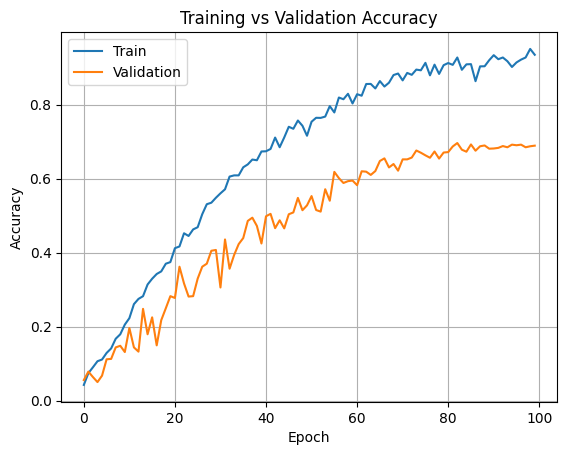

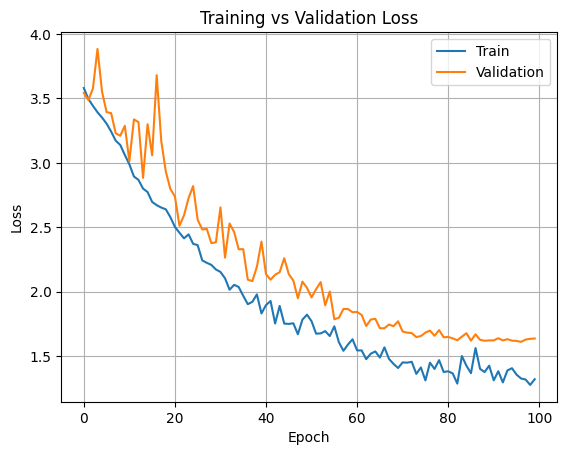

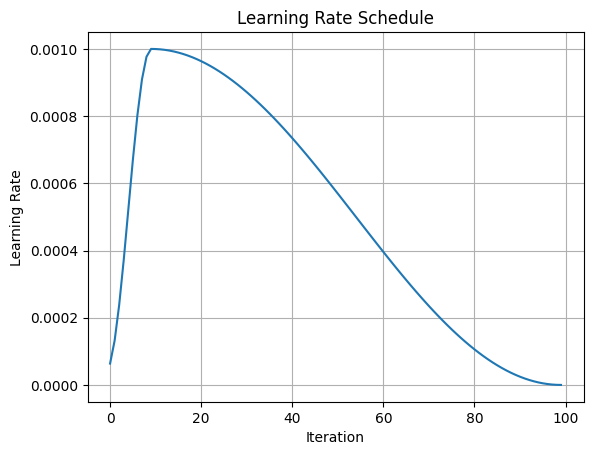

(Net(
   (stem): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
   )
   (stage1): Sequential(
     (0): ConvBlock(
       (block): Sequential(
         (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ReLU()
       )
     )
     (1): ConvBlock(
       (block): Sequential(


In [ ]:
# Model 8
run_ablation_experiment("No Residual", model_kwargs={"use_residuals": False})

## **Model variant: No Label Smoothing**

**Change**
- Disabled label smoothing in the cross-entropy loss, using hard one-hot target labels during training.

**Purpose**
- To assess the effect of label smoothing on model calibration and generalization.

=== Running: No LabelSmoothing ===
Total parameters: 11,336,581 | Trainable: 11,336,581


2026/02/16 07:52:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 3.547, Train Acc: 0.059 | Val Loss: 3.533, Val Acc: 0.068 | LR: 6.35e-05


2026/02/16 07:52:44 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:52:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [2/100] | Train Loss: 3.433, Train Acc: 0.082 | Val Loss: 3.799, Val Acc: 0.045 | LR: 1.32e-04


Epoch [3/100] | Train Loss: 3.411, Train Acc: 0.088 | Val Loss: 3.668, Val Acc: 0.051 | LR: 2.38e-04


2026/02/16 07:53:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [4/100] | Train Loss: 3.371, Train Acc: 0.096 | Val Loss: 3.538, Val Acc: 0.079 | LR: 3.72e-04


2026/02/16 07:53:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:53:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:54:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [5/100] | Train Loss: 3.290, Train Acc: 0.115 | Val Loss: 3.547, Val Acc: 0.092 | LR: 5.21e-04


2026/02/16 07:54:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:54:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [6/100] | Train Loss: 3.217, Train Acc: 0.129 | Val Loss: 5.394, Val Acc: 0.051 | LR: 6.69e-04


Epoch [7/100] | Train Loss: 3.183, Train Acc: 0.145 | Val Loss: 5.847, Val Acc: 0.032 | LR: 8.03e-04


Epoch [8/100] | Train Loss: 3.140, Train Acc: 0.150 | Val Loss: 3.710, Val Acc: 0.069 | LR: 9.09e-04


2026/02/16 07:55:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [9/100] | Train Loss: 3.037, Train Acc: 0.170 | Val Loss: 3.395, Val Acc: 0.112 | LR: 9.77e-04


2026/02/16 07:55:16 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:55:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:55:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [10/100] | Train Loss: 2.941, Train Acc: 0.211 | Val Loss: 3.211, Val Acc: 0.136 | LR: 1.00e-03


2026/02/16 07:55:45 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:55:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:56:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [11/100] | Train Loss: 2.842, Train Acc: 0.215 | Val Loss: 2.977, Val Acc: 0.177 | LR: 1.00e-03


2026/02/16 07:56:12 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:56:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [12/100] | Train Loss: 2.767, Train Acc: 0.244 | Val Loss: 3.100, Val Acc: 0.171 | LR: 9.99e-04


Epoch [13/100] | Train Loss: 2.774, Train Acc: 0.258 | Val Loss: 3.288, Val Acc: 0.129 | LR: 9.97e-04


2026/02/16 07:57:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [14/100] | Train Loss: 2.625, Train Acc: 0.277 | Val Loss: 2.994, Val Acc: 0.192 | LR: 9.95e-04


2026/02/16 07:57:07 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:57:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [15/100] | Train Loss: 2.565, Train Acc: 0.303 | Val Loss: 3.787, Val Acc: 0.129 | LR: 9.92e-04


Epoch [16/100] | Train Loss: 2.474, Train Acc: 0.313 | Val Loss: 3.616, Val Acc: 0.171 | LR: 9.89e-04


2026/02/16 07:57:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [17/100] | Train Loss: 2.464, Train Acc: 0.326 | Val Loss: 2.671, Val Acc: 0.237 | LR: 9.85e-04


2026/02/16 07:58:03 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:58:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 07:58:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [18/100] | Train Loss: 2.376, Train Acc: 0.365 | Val Loss: 2.497, Val Acc: 0.277 | LR: 9.81e-04


2026/02/16 07:58:30 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:58:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [19/100] | Train Loss: 2.257, Train Acc: 0.380 | Val Loss: 2.675, Val Acc: 0.264 | LR: 9.75e-04


2026/02/16 07:59:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [20/100] | Train Loss: 2.200, Train Acc: 0.405 | Val Loss: 2.378, Val Acc: 0.310 | LR: 9.70e-04


2026/02/16 07:59:14 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 07:59:19 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [21/100] | Train Loss: 2.090, Train Acc: 0.431 | Val Loss: 3.149, Val Acc: 0.226 | LR: 9.64e-04


Epoch [22/100] | Train Loss: 2.168, Train Acc: 0.445 | Val Loss: 2.763, Val Acc: 0.256 | LR: 9.57e-04


2026/02/16 08:00:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [23/100] | Train Loss: 2.093, Train Acc: 0.451 | Val Loss: 2.156, Val Acc: 0.375 | LR: 9.49e-04


2026/02/16 08:00:09 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:00:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:00:34 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [24/100] | Train Loss: 1.946, Train Acc: 0.471 | Val Loss: 2.046, Val Acc: 0.378 | LR: 9.41e-04


2026/02/16 08:00:39 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:00:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [25/100] | Train Loss: 2.049, Train Acc: 0.488 | Val Loss: 2.357, Val Acc: 0.309 | LR: 9.33e-04


2026/02/16 08:01:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [26/100] | Train Loss: 1.869, Train Acc: 0.506 | Val Loss: 1.980, Val Acc: 0.419 | LR: 9.24e-04


2026/02/16 08:01:22 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:01:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [27/100] | Train Loss: 1.952, Train Acc: 0.509 | Val Loss: 2.554, Val Acc: 0.323 | LR: 9.14e-04


Epoch [28/100] | Train Loss: 1.840, Train Acc: 0.531 | Val Loss: 2.279, Val Acc: 0.338 | LR: 9.04e-04


Epoch [29/100] | Train Loss: 1.803, Train Acc: 0.545 | Val Loss: 2.096, Val Acc: 0.407 | LR: 8.94e-04


Epoch [30/100] | Train Loss: 1.777, Train Acc: 0.570 | Val Loss: 2.481, Val Acc: 0.344 | LR: 8.83e-04


Epoch [31/100] | Train Loss: 1.658, Train Acc: 0.581 | Val Loss: 2.031, Val Acc: 0.411 | LR: 8.71e-04


Epoch [32/100] | Train Loss: 1.795, Train Acc: 0.574 | Val Loss: 2.024, Val Acc: 0.415 | LR: 8.60e-04


2026/02/16 08:03:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [33/100] | Train Loss: 1.635, Train Acc: 0.597 | Val Loss: 1.792, Val Acc: 0.457 | LR: 8.47e-04


2026/02/16 08:03:13 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:03:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [34/100] | Train Loss: 1.670, Train Acc: 0.597 | Val Loss: 2.701, Val Acc: 0.312 | LR: 8.34e-04


2026/02/16 08:03:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [35/100] | Train Loss: 1.577, Train Acc: 0.612 | Val Loss: 1.651, Val Acc: 0.503 | LR: 8.21e-04


2026/02/16 08:03:54 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:03:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [36/100] | Train Loss: 1.585, Train Acc: 0.635 | Val Loss: 1.768, Val Acc: 0.477 | LR: 8.08e-04


Epoch [37/100] | Train Loss: 1.535, Train Acc: 0.648 | Val Loss: 1.704, Val Acc: 0.478 | LR: 7.94e-04


Epoch [38/100] | Train Loss: 1.568, Train Acc: 0.635 | Val Loss: 1.949, Val Acc: 0.463 | LR: 7.79e-04


2026/02/16 08:04:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [39/100] | Train Loss: 1.519, Train Acc: 0.658 | Val Loss: 1.533, Val Acc: 0.533 | LR: 7.65e-04


2026/02/16 08:05:03 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:05:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [40/100] | Train Loss: 1.322, Train Acc: 0.681 | Val Loss: 1.740, Val Acc: 0.494 | LR: 7.50e-04


Epoch [41/100] | Train Loss: 1.504, Train Acc: 0.668 | Val Loss: 1.585, Val Acc: 0.531 | LR: 7.35e-04


Epoch [42/100] | Train Loss: 1.341, Train Acc: 0.708 | Val Loss: 1.560, Val Acc: 0.533 | LR: 7.19e-04


2026/02/16 08:06:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [43/100] | Train Loss: 1.445, Train Acc: 0.703 | Val Loss: 1.454, Val Acc: 0.570 | LR: 7.03e-04


2026/02/16 08:06:12 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:06:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [44/100] | Train Loss: 1.349, Train Acc: 0.740 | Val Loss: 1.804, Val Acc: 0.503 | LR: 6.87e-04


Epoch [45/100] | Train Loss: 1.491, Train Acc: 0.696 | Val Loss: 1.600, Val Acc: 0.551 | LR: 6.71e-04


Epoch [46/100] | Train Loss: 1.431, Train Acc: 0.726 | Val Loss: 1.529, Val Acc: 0.553 | LR: 6.54e-04


Epoch [47/100] | Train Loss: 1.470, Train Acc: 0.725 | Val Loss: 1.494, Val Acc: 0.569 | LR: 6.38e-04


Epoch [48/100] | Train Loss: 1.272, Train Acc: 0.753 | Val Loss: 1.515, Val Acc: 0.564 | LR: 6.21e-04


2026/02/16 08:07:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [49/100] | Train Loss: 1.304, Train Acc: 0.738 | Val Loss: 1.353, Val Acc: 0.598 | LR: 6.04e-04


2026/02/16 08:07:49 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:07:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [50/100] | Train Loss: 1.164, Train Acc: 0.783 | Val Loss: 1.424, Val Acc: 0.589 | LR: 5.87e-04


2026/02/16 08:08:29 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [51/100] | Train Loss: 1.192, Train Acc: 0.763 | Val Loss: 1.333, Val Acc: 0.601 | LR: 5.69e-04


2026/02/16 08:08:33 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:08:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:08:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [52/100] | Train Loss: 1.148, Train Acc: 0.793 | Val Loss: 1.341, Val Acc: 0.605 | LR: 5.52e-04


2026/02/16 08:09:04 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:09:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [53/100] | Train Loss: 1.173, Train Acc: 0.809 | Val Loss: 1.413, Val Acc: 0.570 | LR: 5.35e-04


2026/02/16 08:09:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [54/100] | Train Loss: 1.151, Train Acc: 0.791 | Val Loss: 1.376, Val Acc: 0.615 | LR: 5.17e-04


2026/02/16 08:09:47 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:09:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:10:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [55/100] | Train Loss: 1.012, Train Acc: 0.834 | Val Loss: 1.354, Val Acc: 0.616 | LR: 5.00e-04


2026/02/16 08:10:17 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:10:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [56/100] | Train Loss: 1.046, Train Acc: 0.827 | Val Loss: 1.466, Val Acc: 0.590 | LR: 4.82e-04


Epoch [57/100] | Train Loss: 0.969, Train Acc: 0.843 | Val Loss: 1.312, Val Acc: 0.615 | LR: 4.65e-04


2026/02/16 08:11:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [58/100] | Train Loss: 0.964, Train Acc: 0.826 | Val Loss: 1.306, Val Acc: 0.620 | LR: 4.48e-04


2026/02/16 08:11:15 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:11:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:11:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [59/100] | Train Loss: 1.028, Train Acc: 0.850 | Val Loss: 1.214, Val Acc: 0.649 | LR: 4.30e-04


2026/02/16 08:11:44 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:11:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [60/100] | Train Loss: 0.993, Train Acc: 0.854 | Val Loss: 1.274, Val Acc: 0.638 | LR: 4.13e-04


Epoch [61/100] | Train Loss: 1.037, Train Acc: 0.845 | Val Loss: 1.293, Val Acc: 0.625 | LR: 3.96e-04


Epoch [62/100] | Train Loss: 0.881, Train Acc: 0.859 | Val Loss: 1.218, Val Acc: 0.644 | LR: 3.79e-04


Epoch [63/100] | Train Loss: 0.982, Train Acc: 0.876 | Val Loss: 1.628, Val Acc: 0.553 | LR: 3.62e-04


Epoch [64/100] | Train Loss: 0.976, Train Acc: 0.861 | Val Loss: 1.253, Val Acc: 0.645 | LR: 3.45e-04


2026/02/16 08:13:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [65/100] | Train Loss: 0.824, Train Acc: 0.899 | Val Loss: 1.163, Val Acc: 0.659 | LR: 3.29e-04


2026/02/16 08:13:21 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:13:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [66/100] | Train Loss: 0.960, Train Acc: 0.872 | Val Loss: 1.220, Val Acc: 0.643 | LR: 3.13e-04


Epoch [67/100] | Train Loss: 0.932, Train Acc: 0.873 | Val Loss: 1.188, Val Acc: 0.647 | LR: 2.96e-04


Epoch [68/100] | Train Loss: 0.838, Train Acc: 0.886 | Val Loss: 1.152, Val Acc: 0.659 | LR: 2.81e-04


2026/02/16 08:14:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [69/100] | Train Loss: 1.026, Train Acc: 0.857 | Val Loss: 1.117, Val Acc: 0.674 | LR: 2.65e-04


2026/02/16 08:14:34 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:14:39 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:15:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [70/100] | Train Loss: 0.915, Train Acc: 0.902 | Val Loss: 1.123, Val Acc: 0.681 | LR: 2.50e-04


2026/02/16 08:15:06 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:15:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [71/100] | Train Loss: 0.920, Train Acc: 0.869 | Val Loss: 1.146, Val Acc: 0.674 | LR: 2.35e-04


Epoch [72/100] | Train Loss: 0.856, Train Acc: 0.886 | Val Loss: 1.126, Val Acc: 0.677 | LR: 2.20e-04


Epoch [73/100] | Train Loss: 0.944, Train Acc: 0.887 | Val Loss: 1.132, Val Acc: 0.676 | LR: 2.06e-04


2026/02/16 08:16:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [74/100] | Train Loss: 0.934, Train Acc: 0.889 | Val Loss: 1.098, Val Acc: 0.686 | LR: 1.92e-04


2026/02/16 08:16:16 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:16:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [75/100] | Train Loss: 0.897, Train Acc: 0.884 | Val Loss: 1.066, Val Acc: 0.683 | LR: 1.78e-04


2026/02/16 08:16:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [76/100] | Train Loss: 0.925, Train Acc: 0.894 | Val Loss: 1.066, Val Acc: 0.694 | LR: 1.65e-04


2026/02/16 08:16:59 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:17:04 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [77/100] | Train Loss: 0.924, Train Acc: 0.902 | Val Loss: 1.090, Val Acc: 0.689 | LR: 1.53e-04


2026/02/16 08:17:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [78/100] | Train Loss: 0.858, Train Acc: 0.912 | Val Loss: 1.046, Val Acc: 0.698 | LR: 1.40e-04


2026/02/16 08:17:40 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:17:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [79/100] | Train Loss: 0.885, Train Acc: 0.909 | Val Loss: 1.070, Val Acc: 0.680 | LR: 1.28e-04


Epoch [80/100] | Train Loss: 0.689, Train Acc: 0.941 | Val Loss: 1.040, Val Acc: 0.698 | LR: 1.17e-04


Epoch [81/100] | Train Loss: 0.763, Train Acc: 0.927 | Val Loss: 1.055, Val Acc: 0.693 | LR: 1.06e-04


2026/02/16 08:18:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [82/100] | Train Loss: 0.767, Train Acc: 0.912 | Val Loss: 1.025, Val Acc: 0.706 | LR: 9.54e-05


2026/02/16 08:18:51 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:18:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [83/100] | Train Loss: 0.697, Train Acc: 0.940 | Val Loss: 1.070, Val Acc: 0.692 | LR: 8.54e-05


Epoch [84/100] | Train Loss: 0.901, Train Acc: 0.904 | Val Loss: 1.029, Val Acc: 0.703 | LR: 7.59e-05


Epoch [85/100] | Train Loss: 0.667, Train Acc: 0.946 | Val Loss: 1.012, Val Acc: 0.705 | LR: 6.69e-05


2026/02/16 08:19:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [86/100] | Train Loss: 0.830, Train Acc: 0.920 | Val Loss: 1.023, Val Acc: 0.709 | LR: 5.85e-05


2026/02/16 08:20:03 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:20:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [87/100] | Train Loss: 0.866, Train Acc: 0.908 | Val Loss: 1.017, Val Acc: 0.709 | LR: 5.05e-05


Epoch [88/100] | Train Loss: 0.759, Train Acc: 0.935 | Val Loss: 1.021, Val Acc: 0.704 | LR: 4.32e-05


Epoch [89/100] | Train Loss: 0.631, Train Acc: 0.944 | Val Loss: 1.028, Val Acc: 0.701 | LR: 3.64e-05


Epoch [90/100] | Train Loss: 0.831, Train Acc: 0.912 | Val Loss: 1.053, Val Acc: 0.700 | LR: 3.01e-05


2026/02/16 08:21:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [91/100] | Train Loss: 0.783, Train Acc: 0.916 | Val Loss: 1.009, Val Acc: 0.712 | LR: 2.44e-05


2026/02/16 08:21:25 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:21:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [92/100] | Train Loss: 0.879, Train Acc: 0.914 | Val Loss: 1.045, Val Acc: 0.707 | LR: 1.93e-05


Epoch [93/100] | Train Loss: 0.695, Train Acc: 0.945 | Val Loss: 1.014, Val Acc: 0.712 | LR: 1.48e-05


Epoch [94/100] | Train Loss: 0.775, Train Acc: 0.932 | Val Loss: 1.024, Val Acc: 0.706 | LR: 1.09e-05


Epoch [95/100] | Train Loss: 0.743, Train Acc: 0.925 | Val Loss: 1.015, Val Acc: 0.708 | LR: 7.57e-06


Epoch [96/100] | Train Loss: 0.646, Train Acc: 0.932 | Val Loss: 1.022, Val Acc: 0.705 | LR: 4.85e-06


Epoch [97/100] | Train Loss: 0.799, Train Acc: 0.920 | Val Loss: 1.022, Val Acc: 0.707 | LR: 2.73e-06


Epoch [98/100] | Train Loss: 0.621, Train Acc: 0.946 | Val Loss: 1.011, Val Acc: 0.710 | LR: 1.21e-06


Epoch [99/100] | Train Loss: 0.762, Train Acc: 0.929 | Val Loss: 1.010, Val Acc: 0.710 | LR: 3.03e-07


Epoch [100/100] | Train Loss: 0.861, Train Acc: 0.917 | Val Loss: 1.027, Val Acc: 0.708 | LR: 4.02e-09
[No LabelSmoothing] Finished! Best Validation Accuracy: 0.712



[No LabelSmoothing] Test Loss: 0.926 | Test Acc: 0.738


2026/02/16 08:23:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 08:23:49 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:23:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run No LabelSmoothing at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/614a6067e07341cf9cf71075c4e0d7bc
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


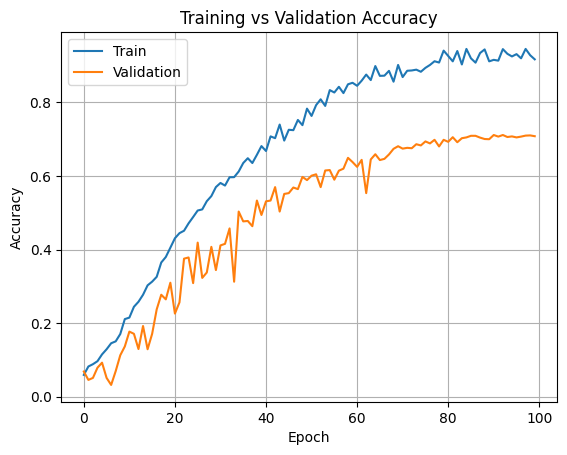

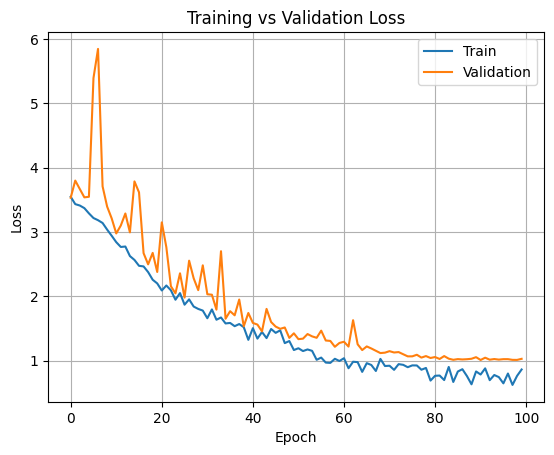

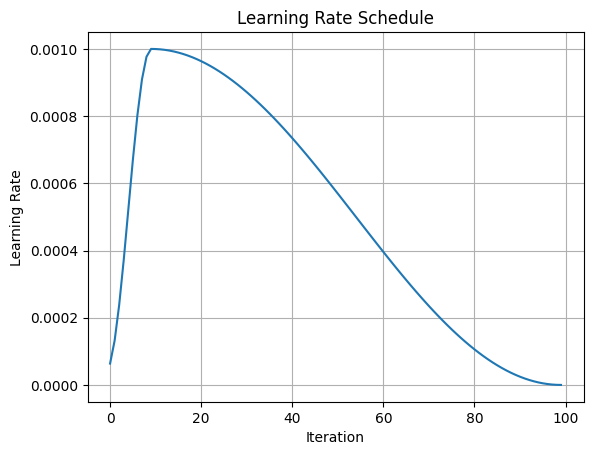

(Net(
   (stem): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
   )
   (stage1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
# Model 9
run_ablation_experiment(
    "No LabelSmoothing", config_kwargs={"use_label_smoothing": False}
)

## **Model variant: No Learning Rate Scheduler**

**Change**
- Disabled the learning rate scheduler, training the model with a constant learning rate throughout all epochs.

**Purpose**
- To evaluate the impact of dynamic learning rate scheduling on convergence speed and final performance.

=== Running: No LR Scheduler ===
Total parameters: 11,336,581 | Trainable: 11,336,581


2026/02/16 08:24:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 3.624, Train Acc: 0.036 | Val Loss: 3.621, Val Acc: 0.040 | LR: 1.00e-03


2026/02/16 08:24:22 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:24:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:24:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [2/100] | Train Loss: 3.567, Train Acc: 0.051 | Val Loss: 3.640, Val Acc: 0.041 | LR: 1.00e-03


2026/02/16 08:24:50 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:24:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:25:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [3/100] | Train Loss: 3.538, Train Acc: 0.057 | Val Loss: 3.556, Val Acc: 0.050 | LR: 1.00e-03


2026/02/16 08:25:19 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:25:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:25:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [4/100] | Train Loss: 3.522, Train Acc: 0.065 | Val Loss: 3.538, Val Acc: 0.059 | LR: 1.00e-03


2026/02/16 08:25:47 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:25:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [5/100] | Train Loss: 3.499, Train Acc: 0.067 | Val Loss: 3.608, Val Acc: 0.052 | LR: 1.00e-03


2026/02/16 08:26:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [6/100] | Train Loss: 3.479, Train Acc: 0.064 | Val Loss: 3.539, Val Acc: 0.062 | LR: 1.00e-03


2026/02/16 08:26:32 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:26:37 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:26:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [7/100] | Train Loss: 3.445, Train Acc: 0.076 | Val Loss: 3.431, Val Acc: 0.082 | LR: 1.00e-03


2026/02/16 08:27:02 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:27:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [8/100] | Train Loss: 3.414, Train Acc: 0.086 | Val Loss: 3.411, Val Acc: 0.076 | LR: 1.00e-03


2026/02/16 08:27:41 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [9/100] | Train Loss: 3.412, Train Acc: 0.082 | Val Loss: 3.386, Val Acc: 0.083 | LR: 1.00e-03


2026/02/16 08:27:45 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:27:50 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:28:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [10/100] | Train Loss: 3.389, Train Acc: 0.097 | Val Loss: 3.354, Val Acc: 0.092 | LR: 1.00e-03


2026/02/16 08:28:16 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:28:20 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [11/100] | Train Loss: 3.370, Train Acc: 0.095 | Val Loss: 3.389, Val Acc: 0.086 | LR: 1.00e-03


Epoch [12/100] | Train Loss: 3.367, Train Acc: 0.099 | Val Loss: 3.437, Val Acc: 0.079 | LR: 1.00e-03


2026/02/16 08:29:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [13/100] | Train Loss: 3.354, Train Acc: 0.110 | Val Loss: 3.311, Val Acc: 0.106 | LR: 1.00e-03


2026/02/16 08:29:11 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:29:17 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [14/100] | Train Loss: 3.332, Train Acc: 0.108 | Val Loss: 3.422, Val Acc: 0.106 | LR: 1.00e-03


Epoch [15/100] | Train Loss: 3.317, Train Acc: 0.109 | Val Loss: 3.328, Val Acc: 0.103 | LR: 1.00e-03


2026/02/16 08:30:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [16/100] | Train Loss: 3.292, Train Acc: 0.118 | Val Loss: 3.296, Val Acc: 0.113 | LR: 1.00e-03


2026/02/16 08:30:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:30:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [17/100] | Train Loss: 3.276, Train Acc: 0.123 | Val Loss: 3.296, Val Acc: 0.109 | LR: 1.00e-03


2026/02/16 08:30:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [18/100] | Train Loss: 3.250, Train Acc: 0.135 | Val Loss: 3.243, Val Acc: 0.118 | LR: 1.00e-03


2026/02/16 08:30:50 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:30:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [19/100] | Train Loss: 3.267, Train Acc: 0.131 | Val Loss: 3.308, Val Acc: 0.115 | LR: 1.00e-03


2026/02/16 08:31:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [20/100] | Train Loss: 3.237, Train Acc: 0.142 | Val Loss: 3.194, Val Acc: 0.123 | LR: 1.00e-03


2026/02/16 08:31:35 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:31:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:32:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [21/100] | Train Loss: 3.213, Train Acc: 0.139 | Val Loss: 3.142, Val Acc: 0.141 | LR: 1.00e-03


2026/02/16 08:32:07 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:32:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:32:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [22/100] | Train Loss: 3.185, Train Acc: 0.154 | Val Loss: 3.132, Val Acc: 0.152 | LR: 1.00e-03


2026/02/16 08:32:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:32:43 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [23/100] | Train Loss: 3.173, Train Acc: 0.165 | Val Loss: 3.121, Val Acc: 0.148 | LR: 1.00e-03


Epoch [24/100] | Train Loss: 3.171, Train Acc: 0.167 | Val Loss: 3.127, Val Acc: 0.144 | LR: 1.00e-03


Epoch [25/100] | Train Loss: 3.120, Train Acc: 0.168 | Val Loss: 3.130, Val Acc: 0.140 | LR: 1.00e-03


2026/02/16 08:33:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [26/100] | Train Loss: 3.107, Train Acc: 0.181 | Val Loss: 3.089, Val Acc: 0.156 | LR: 1.00e-03


2026/02/16 08:33:52 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:33:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:34:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [27/100] | Train Loss: 3.109, Train Acc: 0.182 | Val Loss: 3.132, Val Acc: 0.159 | LR: 1.00e-03


2026/02/16 08:34:24 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:34:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:34:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [28/100] | Train Loss: 3.079, Train Acc: 0.192 | Val Loss: 3.054, Val Acc: 0.185 | LR: 1.00e-03


2026/02/16 08:34:52 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:34:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [29/100] | Train Loss: 3.069, Train Acc: 0.186 | Val Loss: 3.010, Val Acc: 0.179 | LR: 1.00e-03


Epoch [30/100] | Train Loss: 3.049, Train Acc: 0.204 | Val Loss: 3.041, Val Acc: 0.166 | LR: 1.00e-03


2026/02/16 08:35:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [31/100] | Train Loss: 3.026, Train Acc: 0.212 | Val Loss: 2.983, Val Acc: 0.185 | LR: 1.00e-03


2026/02/16 08:35:54 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:35:59 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:36:19 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [32/100] | Train Loss: 3.038, Train Acc: 0.211 | Val Loss: 2.956, Val Acc: 0.206 | LR: 1.00e-03


2026/02/16 08:36:23 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:36:29 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:36:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [33/100] | Train Loss: 2.989, Train Acc: 0.214 | Val Loss: 2.955, Val Acc: 0.208 | LR: 1.00e-03


2026/02/16 08:36:54 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:37:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:37:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [34/100] | Train Loss: 2.998, Train Acc: 0.224 | Val Loss: 2.945, Val Acc: 0.214 | LR: 1.00e-03


2026/02/16 08:37:25 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:37:30 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [35/100] | Train Loss: 2.939, Train Acc: 0.244 | Val Loss: 3.023, Val Acc: 0.189 | LR: 1.00e-03


2026/02/16 08:38:03 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [36/100] | Train Loss: 2.927, Train Acc: 0.237 | Val Loss: 2.856, Val Acc: 0.235 | LR: 1.00e-03


2026/02/16 08:38:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:38:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [37/100] | Train Loss: 2.906, Train Acc: 0.259 | Val Loss: 2.899, Val Acc: 0.222 | LR: 1.00e-03


2026/02/16 08:38:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [38/100] | Train Loss: 2.854, Train Acc: 0.259 | Val Loss: 2.867, Val Acc: 0.236 | LR: 1.00e-03


2026/02/16 08:38:51 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:38:56 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:39:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [39/100] | Train Loss: 2.825, Train Acc: 0.274 | Val Loss: 2.844, Val Acc: 0.240 | LR: 1.00e-03


2026/02/16 08:39:22 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:39:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:39:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [40/100] | Train Loss: 2.815, Train Acc: 0.282 | Val Loss: 2.768, Val Acc: 0.270 | LR: 1.00e-03


2026/02/16 08:39:51 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:39:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:40:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [41/100] | Train Loss: 2.789, Train Acc: 0.288 | Val Loss: 2.736, Val Acc: 0.287 | LR: 1.00e-03


2026/02/16 08:40:22 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:40:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [42/100] | Train Loss: 2.771, Train Acc: 0.314 | Val Loss: 2.708, Val Acc: 0.275 | LR: 1.00e-03


Epoch [43/100] | Train Loss: 2.736, Train Acc: 0.335 | Val Loss: 2.793, Val Acc: 0.263 | LR: 1.00e-03


Epoch [44/100] | Train Loss: 2.660, Train Acc: 0.332 | Val Loss: 2.788, Val Acc: 0.265 | LR: 1.00e-03


Epoch [45/100] | Train Loss: 2.677, Train Acc: 0.338 | Val Loss: 2.711, Val Acc: 0.272 | LR: 1.00e-03


2026/02/16 08:41:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [46/100] | Train Loss: 2.597, Train Acc: 0.373 | Val Loss: 2.597, Val Acc: 0.327 | LR: 1.00e-03


2026/02/16 08:41:48 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:41:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:42:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [47/100] | Train Loss: 2.644, Train Acc: 0.362 | Val Loss: 2.513, Val Acc: 0.363 | LR: 1.00e-03


2026/02/16 08:42:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:42:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [48/100] | Train Loss: 2.591, Train Acc: 0.361 | Val Loss: 2.550, Val Acc: 0.320 | LR: 1.00e-03


Epoch [49/100] | Train Loss: 2.543, Train Acc: 0.379 | Val Loss: 2.589, Val Acc: 0.345 | LR: 1.00e-03


Epoch [50/100] | Train Loss: 2.552, Train Acc: 0.383 | Val Loss: 2.521, Val Acc: 0.341 | LR: 1.00e-03


Epoch [51/100] | Train Loss: 2.516, Train Acc: 0.398 | Val Loss: 2.637, Val Acc: 0.306 | LR: 1.00e-03


2026/02/16 08:43:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [52/100] | Train Loss: 2.500, Train Acc: 0.405 | Val Loss: 2.446, Val Acc: 0.387 | LR: 1.00e-03


2026/02/16 08:43:41 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:43:46 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:44:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [53/100] | Train Loss: 2.431, Train Acc: 0.431 | Val Loss: 2.325, Val Acc: 0.399 | LR: 1.00e-03


2026/02/16 08:44:11 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:44:15 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:44:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [54/100] | Train Loss: 2.454, Train Acc: 0.433 | Val Loss: 2.345, Val Acc: 0.424 | LR: 1.00e-03


2026/02/16 08:44:41 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:44:47 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [55/100] | Train Loss: 2.501, Train Acc: 0.423 | Val Loss: 2.478, Val Acc: 0.382 | LR: 1.00e-03


Epoch [56/100] | Train Loss: 2.454, Train Acc: 0.446 | Val Loss: 2.396, Val Acc: 0.378 | LR: 1.00e-03


Epoch [57/100] | Train Loss: 2.393, Train Acc: 0.462 | Val Loss: 2.378, Val Acc: 0.402 | LR: 1.00e-03


2026/02/16 08:45:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [58/100] | Train Loss: 2.409, Train Acc: 0.469 | Val Loss: 2.329, Val Acc: 0.425 | LR: 1.00e-03


2026/02/16 08:45:55 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:46:01 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:46:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [59/100] | Train Loss: 2.371, Train Acc: 0.468 | Val Loss: 2.257, Val Acc: 0.443 | LR: 1.00e-03


2026/02/16 08:46:27 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:46:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [60/100] | Train Loss: 2.405, Train Acc: 0.481 | Val Loss: 2.276, Val Acc: 0.441 | LR: 1.00e-03


2026/02/16 08:47:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [61/100] | Train Loss: 2.293, Train Acc: 0.498 | Val Loss: 2.245, Val Acc: 0.452 | LR: 1.00e-03


2026/02/16 08:47:12 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:47:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [62/100] | Train Loss: 2.355, Train Acc: 0.488 | Val Loss: 2.312, Val Acc: 0.413 | LR: 1.00e-03


Epoch [63/100] | Train Loss: 2.304, Train Acc: 0.496 | Val Loss: 2.287, Val Acc: 0.420 | LR: 1.00e-03


2026/02/16 08:48:10 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [64/100] | Train Loss: 2.366, Train Acc: 0.484 | Val Loss: 2.176, Val Acc: 0.469 | LR: 1.00e-03


2026/02/16 08:48:15 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:48:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [65/100] | Train Loss: 2.134, Train Acc: 0.530 | Val Loss: 2.246, Val Acc: 0.443 | LR: 1.00e-03


Epoch [66/100] | Train Loss: 2.245, Train Acc: 0.536 | Val Loss: 2.282, Val Acc: 0.431 | LR: 1.00e-03


2026/02/16 08:49:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [67/100] | Train Loss: 2.268, Train Acc: 0.522 | Val Loss: 2.194, Val Acc: 0.472 | LR: 1.00e-03


2026/02/16 08:49:16 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:49:22 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:49:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [68/100] | Train Loss: 2.191, Train Acc: 0.551 | Val Loss: 2.145, Val Acc: 0.477 | LR: 1.00e-03


2026/02/16 08:49:47 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:49:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:50:13 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [69/100] | Train Loss: 2.176, Train Acc: 0.569 | Val Loss: 2.126, Val Acc: 0.510 | LR: 1.00e-03


2026/02/16 08:50:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:50:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [70/100] | Train Loss: 2.202, Train Acc: 0.555 | Val Loss: 2.132, Val Acc: 0.494 | LR: 1.00e-03


2026/02/16 08:51:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [71/100] | Train Loss: 2.182, Train Acc: 0.571 | Val Loss: 2.112, Val Acc: 0.511 | LR: 1.00e-03


2026/02/16 08:51:04 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:51:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [72/100] | Train Loss: 2.187, Train Acc: 0.572 | Val Loss: 2.243, Val Acc: 0.449 | LR: 1.00e-03


Epoch [73/100] | Train Loss: 2.174, Train Acc: 0.576 | Val Loss: 2.091, Val Acc: 0.504 | LR: 1.00e-03


2026/02/16 08:51:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [74/100] | Train Loss: 2.109, Train Acc: 0.599 | Val Loss: 2.076, Val Acc: 0.520 | LR: 1.00e-03


2026/02/16 08:52:02 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:52:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [75/100] | Train Loss: 2.149, Train Acc: 0.593 | Val Loss: 2.120, Val Acc: 0.504 | LR: 1.00e-03


Epoch [76/100] | Train Loss: 2.046, Train Acc: 0.633 | Val Loss: 2.130, Val Acc: 0.498 | LR: 1.00e-03


Epoch [77/100] | Train Loss: 2.071, Train Acc: 0.632 | Val Loss: 2.152, Val Acc: 0.497 | LR: 1.00e-03


Epoch [78/100] | Train Loss: 2.013, Train Acc: 0.649 | Val Loss: 2.068, Val Acc: 0.519 | LR: 1.00e-03


Epoch [79/100] | Train Loss: 2.106, Train Acc: 0.616 | Val Loss: 2.117, Val Acc: 0.519 | LR: 1.00e-03


Epoch [80/100] | Train Loss: 2.024, Train Acc: 0.648 | Val Loss: 2.089, Val Acc: 0.516 | LR: 1.00e-03


2026/02/16 08:53:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [81/100] | Train Loss: 2.013, Train Acc: 0.647 | Val Loss: 1.966, Val Acc: 0.568 | LR: 1.00e-03


2026/02/16 08:54:03 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:54:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 08:54:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [82/100] | Train Loss: 2.056, Train Acc: 0.639 | Val Loss: 1.941, Val Acc: 0.569 | LR: 1.00e-03


2026/02/16 08:54:35 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:54:41 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [83/100] | Train Loss: 1.980, Train Acc: 0.656 | Val Loss: 2.017, Val Acc: 0.552 | LR: 1.00e-03


Epoch [84/100] | Train Loss: 1.935, Train Acc: 0.683 | Val Loss: 2.010, Val Acc: 0.531 | LR: 1.00e-03


Epoch [85/100] | Train Loss: 1.917, Train Acc: 0.688 | Val Loss: 2.041, Val Acc: 0.536 | LR: 1.00e-03


Epoch [86/100] | Train Loss: 1.892, Train Acc: 0.695 | Val Loss: 1.973, Val Acc: 0.549 | LR: 1.00e-03


Epoch [87/100] | Train Loss: 1.867, Train Acc: 0.712 | Val Loss: 1.995, Val Acc: 0.548 | LR: 1.00e-03


Epoch [88/100] | Train Loss: 1.900, Train Acc: 0.707 | Val Loss: 2.036, Val Acc: 0.535 | LR: 1.00e-03


Epoch [89/100] | Train Loss: 1.950, Train Acc: 0.691 | Val Loss: 2.053, Val Acc: 0.518 | LR: 1.00e-03


Epoch [90/100] | Train Loss: 1.831, Train Acc: 0.735 | Val Loss: 1.978, Val Acc: 0.553 | LR: 1.00e-03


Epoch [91/100] | Train Loss: 1.838, Train Acc: 0.729 | Val Loss: 1.983, Val Acc: 0.563 | LR: 1.00e-03


Epoch [92/100] | Train Loss: 1.828, Train Acc: 0.735 | Val Loss: 2.079, Val Acc: 0.536 | LR: 1.00e-03


Epoch [93/100] | Train Loss: 1.888, Train Acc: 0.724 | Val Loss: 2.007, Val Acc: 0.546 | LR: 1.00e-03


2026/02/16 08:57:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [94/100] | Train Loss: 1.795, Train Acc: 0.753 | Val Loss: 1.887, Val Acc: 0.591 | LR: 1.00e-03


2026/02/16 08:57:53 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:58:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [95/100] | Train Loss: 1.802, Train Acc: 0.762 | Val Loss: 1.954, Val Acc: 0.565 | LR: 1.00e-03


Epoch [96/100] | Train Loss: 1.790, Train Acc: 0.744 | Val Loss: 1.978, Val Acc: 0.562 | LR: 1.00e-03


Epoch [97/100] | Train Loss: 1.826, Train Acc: 0.741 | Val Loss: 1.926, Val Acc: 0.573 | LR: 1.00e-03


2026/02/16 08:59:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [98/100] | Train Loss: 1.806, Train Acc: 0.748 | Val Loss: 1.880, Val Acc: 0.600 | LR: 1.00e-03


2026/02/16 08:59:09 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 08:59:14 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [99/100] | Train Loss: 1.764, Train Acc: 0.774 | Val Loss: 1.892, Val Acc: 0.589 | LR: 1.00e-03


Epoch [100/100] | Train Loss: 1.831, Train Acc: 0.761 | Val Loss: 1.885, Val Acc: 0.595 | LR: 1.00e-03
[No LR Scheduler] Finished! Best Validation Accuracy: 0.600



[No LR Scheduler] Test Loss: 1.755 | Test Acc: 0.641


2026/02/16 08:59:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 09:00:02 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:00:07 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run No LR Scheduler at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/f974267a785a456aba3cb0cf3fc16dd5
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


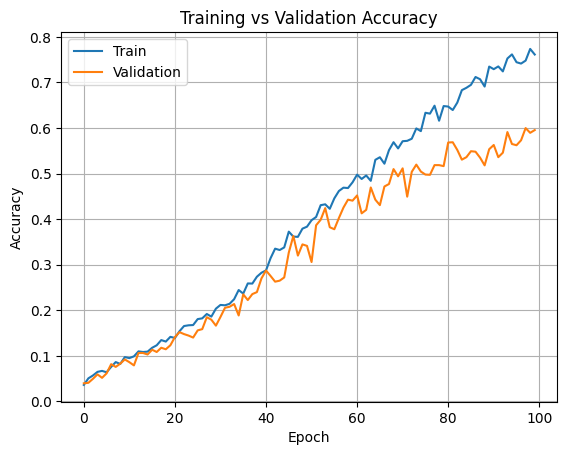

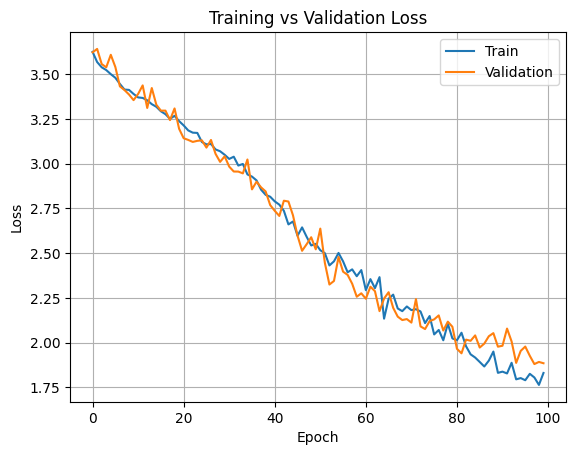

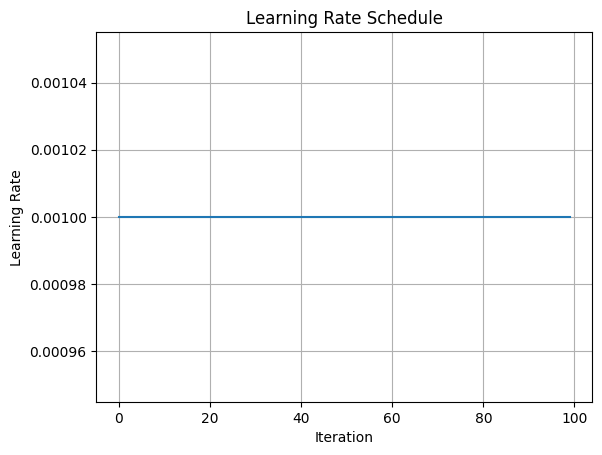

(Net(
   (stem): Sequential(
     (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
     (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace=True)
     (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace=True)
     (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace=True)
   )
   (stage1): Sequential(
     (0): ResidualBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=

In [ ]:
# Model 10
run_ablation_experiment("No LR Scheduler", config_kwargs={"use_scheduler": False})

## **Final Results and Discussion**



In [ ]:
model_order = [
    "Baseline",
    "No BatchNorm",
    "No Pooling",
    "No Dropout",
    "No MixUp",
    "No Augmentation",
    "No StemLayer",
    "No Residual",
    "No LabelSmoothing",
    "No LR Scheduler",
]

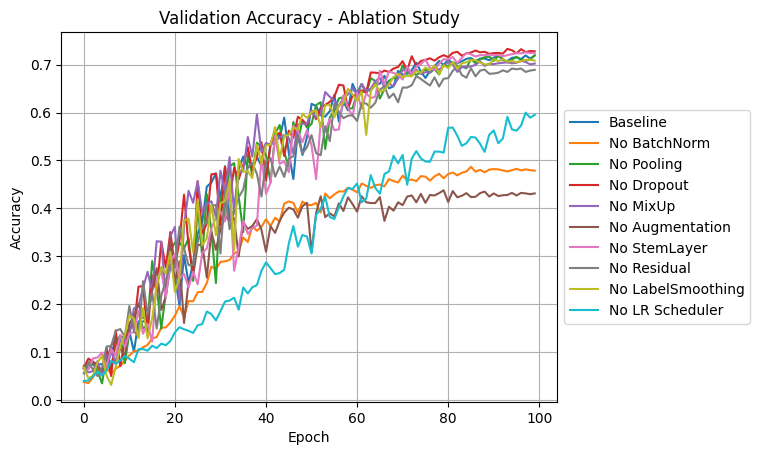

In [ ]:
plt.figure()

for model in model_order:
    if model in all_histories:
        plt.plot(all_histories[model]["val_acc"])

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy - Ablation Study")
plt.legend(
    [m for m in model_order if m in all_histories],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
plt.grid(True)
plt.show()

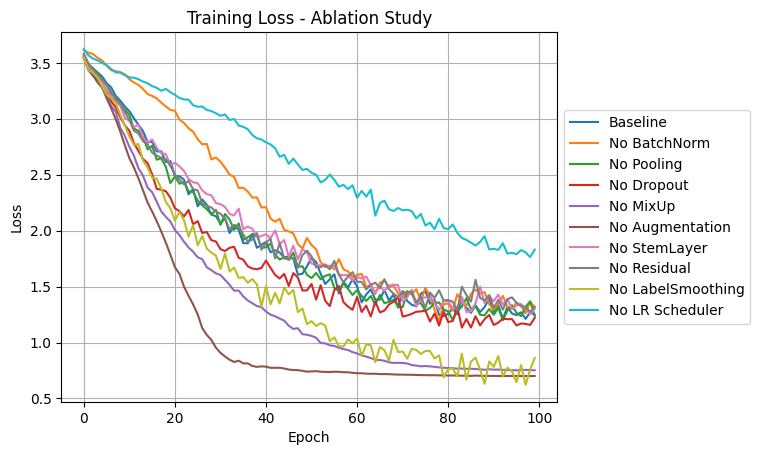

In [ ]:
plt.figure()

for model in model_order:
    if model in all_histories:
        plt.plot(all_histories[model]["train_loss"])

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss - Ablation Study")
plt.legend(
    [m for m in model_order if m in all_histories],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
)
plt.grid(True)
plt.show()

In [7]:
df_results = pd.read_csv(ABLATION_CSV_PATH)
df_results[:10]

Model  Test Loss  Test Accuracy  Test Precision  Test Recall  \
0           Baseline     1.4457         0.7492          0.7517       0.7497   
1       No BatchNorm     2.1512         0.5347          0.5324       0.5352   
2         No Pooling     1.4642         0.7367          0.7415       0.7372   
3         No Dropout     1.4766         0.7346          0.7379       0.7350   
4           No MixUp     1.4875         0.7275          0.7263       0.7280   
5    No Augmentation     2.2956         0.4637          0.4792       0.4645   
6       No StemLayer     1.4233         0.7514          0.7529       0.7517   
7        No Residual     1.5306         0.7102          0.7127       0.7107   
8  No LabelSmoothing     0.9255         0.7384          0.7430       0.7388   
9    No LR Scheduler     1.7546         0.6408          0.6595       0.6413   

   Test F1  
0   0.7464  
1   0.5287  
2   0.7362  
3   0.7329  
4   0.7243  
5   0.4575  
6   0.7485  
7   0.7077  
8   0.7374  
9   0.6416

The Baseline model achieves a solid test accuracy of `74.92%`, leading to a strong reference point for comparison.

Removing key architectural components significantly degrades performance. In particular:

- No Augmentation (`46.37%`) causes the largest drop, highlighting that data augmentation is critical for generalization.

- No BatchNorm (`53.47%`) also leads to an important decline, confirming that batch normalization is essential for stable training and good performance.

- No LR Scheduler (`64.08%`) clearly reduces accuracy, showing the importance of proper learning rate scheduling.

Other components such as dropout, pooling, MixUp, residual connections and label smoothing produce more moderate drops (around 1–4%), indicating they contribute to performance but are less individually critical than augmentation or batch normalization.

Interestingly, removing the stem layer slightly increases test accuracy (`75.14%` vs. `74.92%`). However, this modification substantially slows down training, making it approximately 2–3× slower than the baseline and other ablation variants. This suggests that while the stem layer may not significantly impact final accuracy, it plays an important role in computational efficiency and training speed.

All the experiments log can be accessed publicly at the following address: https://mlflow.niccolozanotti.com/#/experiments/5/runs  by logging in as:

- username: `guest`
- password: `publicpassword`

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained ResNet-18 model on `OxfordPetDataset`. Use the implementation provided by PyTorch, i.e. the opposite of part 1. Specifically, use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

2A. First, fine-tune the ResNet-18 with the same training hyperparameters you used for your best model in part 1.

2B. Then, tweak the training hyperparameters in order to increase the accuracy on the test split. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions — papers, blog posts, YouTube videos, or whatever else you may find useful. You should consider yourselves satisfied once you obtain a classification accuracy on the test split of ~90%.

In [ ]:
def run_finetuning_stage(
    model_name,
    model,
    config,
    criterion,
    optimizer,
    scheduler,
    mixup_fn,
    custom_mlflow_params=None,
):
    """
    Executes a fine-tuning stage, handling training, evaluation,
    MLflow logging, local saving, and plotting.
    """
    # 1. Open MLflow context
    run_context = mlflow.start_run(run_name=model_name) if USE_MLFLOW else nullcontext()

    with run_context:
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        print(f"\n" + "=" * 50)
        print(f"=== Running: {model_name} ===")
        print(
            f"Total params: {total_params:,} | Trainable params: {trainable_params:,}"
        )
        print("=" * 50)

        if USE_MLFLOW:
            mlflow.log_param("total_params", total_params)
            mlflow.log_param("trainable_params", trainable_params)
            mlflow.log_params(vars(config))
            if custom_mlflow_params:
                mlflow.log_params(custom_mlflow_params)

        # 2. Train the model
        best_acc, history = train_model(
            model_name=model_name,
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            mixup=mixup_fn,
            device=device,
            config=config,
            use_mlflow=USE_MLFLOW,
        )

        # 3. Load best weights and Evaluate
        model.load_state_dict(torch.load(config.save_path, map_location=device))
        model.to(device)

        test_loss, test_acc, test_prec, test_recall, test_f1 = evaluate(
            model, test_loader, criterion, device
        )

        print(f"[{model_name}] Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}")

        # 4. Log to MLflow
        if USE_MLFLOW:
            mlflow.log_metrics(
                {
                    "test_loss": test_loss,
                    "test_accuracy": test_acc,
                    "test_precision": test_prec,
                    "test_recall": test_recall,
                    "test_f1": test_f1,
                }
            )
            mlflow.pytorch.log_model(model, artifact_path="model")

    # --- Local Saving and Plotting ---
    global results, all_histories
    results = [r for r in results if r["Model"] != model_name]
    results.append(
        {
            "Model": model_name,
            "Test Loss": test_loss,
            "Test Accuracy": test_acc,
            "Test Precision": test_prec,
            "Test Recall": test_recall,
            "Test F1": test_f1,
        }
    )
    all_histories[model_name] = history

    pd.DataFrame(results).round(4).to_csv(ABLATION_CSV_PATH, index=False)
    with open(ABLATION_JSON_PATH, "w") as f:
        json.dump(all_histories, f, indent=4)

    plot_accuracy(history)
    plot_loss(history)
    plot_learning_rate(history)

    return test_acc  # Returning this so we can compare 2A and 2B later


=== Running: ResNet-18 Fine-tuned (Part 2A) ===
Total params: 11,195,493 | Trainable params: 11,195,493


2026/02/16 09:00:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 2.679, Train Acc: 0.495 | Val Loss: 1.636, Val Acc: 0.774 | LR: 6.35e-05


2026/02/16 09:00:36 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:00:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 09:01:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [2/100] | Train Loss: 1.658, Train Acc: 0.834 | Val Loss: 1.243, Val Acc: 0.834 | LR: 1.32e-04


2026/02/16 09:01:08 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:01:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [3/100] | Train Loss: 1.362, Train Acc: 0.886 | Val Loss: 1.310, Val Acc: 0.796 | LR: 2.38e-04


Epoch [4/100] | Train Loss: 1.461, Train Acc: 0.883 | Val Loss: 1.464, Val Acc: 0.733 | LR: 3.72e-04


Epoch [5/100] | Train Loss: 1.563, Train Acc: 0.826 | Val Loss: 1.821, Val Acc: 0.605 | LR: 5.21e-04


Epoch [6/100] | Train Loss: 1.541, Train Acc: 0.833 | Val Loss: 1.770, Val Acc: 0.637 | LR: 6.69e-04


Epoch [7/100] | Train Loss: 1.686, Train Acc: 0.774 | Val Loss: 1.889, Val Acc: 0.586 | LR: 8.03e-04


Epoch [8/100] | Train Loss: 1.585, Train Acc: 0.817 | Val Loss: 1.860, Val Acc: 0.605 | LR: 9.09e-04


Epoch [9/100] | Train Loss: 1.594, Train Acc: 0.817 | Val Loss: 1.787, Val Acc: 0.637 | LR: 9.77e-04


Epoch [10/100] | Train Loss: 1.499, Train Acc: 0.848 | Val Loss: 1.722, Val Acc: 0.655 | LR: 1.00e-03


Epoch [11/100] | Train Loss: 1.398, Train Acc: 0.888 | Val Loss: 1.589, Val Acc: 0.703 | LR: 1.00e-03


Epoch [12/100] | Train Loss: 1.459, Train Acc: 0.863 | Val Loss: 1.910, Val Acc: 0.598 | LR: 9.99e-04


Epoch [13/100] | Train Loss: 1.380, Train Acc: 0.873 | Val Loss: 1.667, Val Acc: 0.663 | LR: 9.97e-04


Epoch [14/100] | Train Loss: 1.441, Train Acc: 0.884 | Val Loss: 1.614, Val Acc: 0.689 | LR: 9.95e-04


Epoch [15/100] | Train Loss: 1.315, Train Acc: 0.905 | Val Loss: 1.548, Val Acc: 0.716 | LR: 9.92e-04


Epoch [16/100] | Train Loss: 1.305, Train Acc: 0.932 | Val Loss: 1.456, Val Acc: 0.752 | LR: 9.89e-04


Epoch [17/100] | Train Loss: 1.311, Train Acc: 0.914 | Val Loss: 1.554, Val Acc: 0.723 | LR: 9.85e-04


Epoch [18/100] | Train Loss: 1.204, Train Acc: 0.944 | Val Loss: 1.491, Val Acc: 0.747 | LR: 9.81e-04


Epoch [19/100] | Train Loss: 1.337, Train Acc: 0.907 | Val Loss: 1.861, Val Acc: 0.616 | LR: 9.75e-04


Epoch [20/100] | Train Loss: 1.255, Train Acc: 0.932 | Val Loss: 1.678, Val Acc: 0.680 | LR: 9.70e-04


Epoch [21/100] | Train Loss: 1.247, Train Acc: 0.939 | Val Loss: 1.486, Val Acc: 0.726 | LR: 9.64e-04


Epoch [22/100] | Train Loss: 1.247, Train Acc: 0.932 | Val Loss: 1.471, Val Acc: 0.749 | LR: 9.57e-04


Epoch [23/100] | Train Loss: 1.225, Train Acc: 0.942 | Val Loss: 1.507, Val Acc: 0.730 | LR: 9.49e-04


Epoch [24/100] | Train Loss: 1.258, Train Acc: 0.932 | Val Loss: 1.479, Val Acc: 0.750 | LR: 9.41e-04


Epoch [25/100] | Train Loss: 1.279, Train Acc: 0.951 | Val Loss: 1.451, Val Acc: 0.757 | LR: 9.33e-04


Epoch [26/100] | Train Loss: 1.344, Train Acc: 0.926 | Val Loss: 1.628, Val Acc: 0.708 | LR: 9.24e-04


Epoch [27/100] | Train Loss: 1.122, Train Acc: 0.971 | Val Loss: 1.508, Val Acc: 0.754 | LR: 9.14e-04


Epoch [28/100] | Train Loss: 1.207, Train Acc: 0.952 | Val Loss: 1.475, Val Acc: 0.752 | LR: 9.04e-04


Epoch [29/100] | Train Loss: 1.264, Train Acc: 0.948 | Val Loss: 1.383, Val Acc: 0.771 | LR: 8.94e-04


Epoch [30/100] | Train Loss: 1.221, Train Acc: 0.948 | Val Loss: 1.443, Val Acc: 0.756 | LR: 8.83e-04


Epoch [31/100] | Train Loss: 1.168, Train Acc: 0.959 | Val Loss: 1.382, Val Acc: 0.783 | LR: 8.71e-04


Epoch [32/100] | Train Loss: 1.239, Train Acc: 0.933 | Val Loss: 1.424, Val Acc: 0.760 | LR: 8.60e-04


Epoch [33/100] | Train Loss: 1.310, Train Acc: 0.935 | Val Loss: 1.467, Val Acc: 0.759 | LR: 8.47e-04


Epoch [34/100] | Train Loss: 1.242, Train Acc: 0.937 | Val Loss: 1.503, Val Acc: 0.732 | LR: 8.34e-04


Epoch [35/100] | Train Loss: 1.237, Train Acc: 0.956 | Val Loss: 1.448, Val Acc: 0.762 | LR: 8.21e-04


Epoch [36/100] | Train Loss: 1.096, Train Acc: 0.971 | Val Loss: 1.408, Val Acc: 0.762 | LR: 8.08e-04


Epoch [37/100] | Train Loss: 1.170, Train Acc: 0.950 | Val Loss: 1.553, Val Acc: 0.731 | LR: 7.94e-04


Epoch [38/100] | Train Loss: 1.165, Train Acc: 0.970 | Val Loss: 1.389, Val Acc: 0.787 | LR: 7.79e-04


Epoch [39/100] | Train Loss: 1.143, Train Acc: 0.973 | Val Loss: 1.356, Val Acc: 0.778 | LR: 7.65e-04


Epoch [40/100] | Train Loss: 1.182, Train Acc: 0.965 | Val Loss: 1.408, Val Acc: 0.770 | LR: 7.50e-04


Epoch [41/100] | Train Loss: 1.193, Train Acc: 0.934 | Val Loss: 1.419, Val Acc: 0.768 | LR: 7.35e-04


Epoch [42/100] | Train Loss: 1.220, Train Acc: 0.950 | Val Loss: 1.481, Val Acc: 0.756 | LR: 7.19e-04


Epoch [43/100] | Train Loss: 1.168, Train Acc: 0.953 | Val Loss: 1.370, Val Acc: 0.793 | LR: 7.03e-04


Epoch [44/100] | Train Loss: 1.127, Train Acc: 0.964 | Val Loss: 1.330, Val Acc: 0.791 | LR: 6.87e-04


Epoch [45/100] | Train Loss: 1.187, Train Acc: 0.954 | Val Loss: 1.377, Val Acc: 0.791 | LR: 6.71e-04


Epoch [46/100] | Train Loss: 1.152, Train Acc: 0.973 | Val Loss: 1.377, Val Acc: 0.784 | LR: 6.54e-04


Epoch [47/100] | Train Loss: 1.132, Train Acc: 0.960 | Val Loss: 1.339, Val Acc: 0.790 | LR: 6.38e-04


Epoch [48/100] | Train Loss: 1.010, Train Acc: 0.984 | Val Loss: 1.409, Val Acc: 0.764 | LR: 6.21e-04


Epoch [49/100] | Train Loss: 1.132, Train Acc: 0.958 | Val Loss: 1.307, Val Acc: 0.799 | LR: 6.04e-04


Epoch [50/100] | Train Loss: 1.133, Train Acc: 0.957 | Val Loss: 1.355, Val Acc: 0.782 | LR: 5.87e-04


Epoch [51/100] | Train Loss: 1.053, Train Acc: 0.975 | Val Loss: 1.290, Val Acc: 0.809 | LR: 5.69e-04


Epoch [52/100] | Train Loss: 1.051, Train Acc: 0.972 | Val Loss: 1.310, Val Acc: 0.794 | LR: 5.52e-04


Epoch [53/100] | Train Loss: 1.151, Train Acc: 0.957 | Val Loss: 1.354, Val Acc: 0.788 | LR: 5.35e-04


Epoch [54/100] | Train Loss: 1.055, Train Acc: 0.974 | Val Loss: 1.332, Val Acc: 0.808 | LR: 5.17e-04


Epoch [55/100] | Train Loss: 1.233, Train Acc: 0.955 | Val Loss: 1.420, Val Acc: 0.783 | LR: 5.00e-04


Epoch [56/100] | Train Loss: 1.129, Train Acc: 0.951 | Val Loss: 1.362, Val Acc: 0.784 | LR: 4.82e-04


Epoch [57/100] | Train Loss: 1.120, Train Acc: 0.950 | Val Loss: 1.356, Val Acc: 0.781 | LR: 4.65e-04


Epoch [58/100] | Train Loss: 1.123, Train Acc: 0.963 | Val Loss: 1.341, Val Acc: 0.796 | LR: 4.48e-04


Epoch [59/100] | Train Loss: 1.083, Train Acc: 0.963 | Val Loss: 1.282, Val Acc: 0.814 | LR: 4.30e-04


Epoch [60/100] | Train Loss: 1.095, Train Acc: 0.967 | Val Loss: 1.294, Val Acc: 0.799 | LR: 4.13e-04


Epoch [61/100] | Train Loss: 1.165, Train Acc: 0.952 | Val Loss: 1.279, Val Acc: 0.804 | LR: 3.96e-04


Epoch [62/100] | Train Loss: 1.226, Train Acc: 0.927 | Val Loss: 1.331, Val Acc: 0.799 | LR: 3.79e-04


Epoch [63/100] | Train Loss: 1.127, Train Acc: 0.970 | Val Loss: 1.262, Val Acc: 0.815 | LR: 3.62e-04


Epoch [64/100] | Train Loss: 1.069, Train Acc: 0.962 | Val Loss: 1.300, Val Acc: 0.803 | LR: 3.45e-04


Epoch [65/100] | Train Loss: 1.098, Train Acc: 0.957 | Val Loss: 1.258, Val Acc: 0.821 | LR: 3.29e-04


Epoch [66/100] | Train Loss: 1.085, Train Acc: 0.971 | Val Loss: 1.271, Val Acc: 0.817 | LR: 3.13e-04


Epoch [67/100] | Train Loss: 1.116, Train Acc: 0.961 | Val Loss: 1.257, Val Acc: 0.819 | LR: 2.96e-04


Epoch [68/100] | Train Loss: 1.053, Train Acc: 0.972 | Val Loss: 1.245, Val Acc: 0.828 | LR: 2.81e-04


Epoch [69/100] | Train Loss: 1.103, Train Acc: 0.970 | Val Loss: 1.249, Val Acc: 0.826 | LR: 2.65e-04


Epoch [70/100] | Train Loss: 1.034, Train Acc: 0.971 | Val Loss: 1.257, Val Acc: 0.814 | LR: 2.50e-04


Epoch [71/100] | Train Loss: 1.143, Train Acc: 0.951 | Val Loss: 1.257, Val Acc: 0.817 | LR: 2.35e-04


Epoch [72/100] | Train Loss: 1.043, Train Acc: 0.973 | Val Loss: 1.236, Val Acc: 0.817 | LR: 2.20e-04


Epoch [73/100] | Train Loss: 1.123, Train Acc: 0.955 | Val Loss: 1.295, Val Acc: 0.812 | LR: 2.06e-04


Epoch [74/100] | Train Loss: 1.123, Train Acc: 0.956 | Val Loss: 1.243, Val Acc: 0.817 | LR: 1.92e-04


Epoch [75/100] | Train Loss: 1.130, Train Acc: 0.960 | Val Loss: 1.262, Val Acc: 0.822 | LR: 1.78e-04


Epoch [76/100] | Train Loss: 1.088, Train Acc: 0.960 | Val Loss: 1.243, Val Acc: 0.823 | LR: 1.65e-04


Epoch [77/100] | Train Loss: 1.085, Train Acc: 0.971 | Val Loss: 1.224, Val Acc: 0.826 | LR: 1.53e-04


Epoch [78/100] | Train Loss: 1.102, Train Acc: 0.968 | Val Loss: 1.231, Val Acc: 0.827 | LR: 1.40e-04


Epoch [79/100] | Train Loss: 1.108, Train Acc: 0.959 | Val Loss: 1.226, Val Acc: 0.820 | LR: 1.28e-04


Epoch [80/100] | Train Loss: 1.070, Train Acc: 0.957 | Val Loss: 1.216, Val Acc: 0.826 | LR: 1.17e-04


Epoch [81/100] | Train Loss: 1.131, Train Acc: 0.966 | Val Loss: 1.246, Val Acc: 0.814 | LR: 1.06e-04


Epoch [82/100] | Train Loss: 1.034, Train Acc: 0.966 | Val Loss: 1.229, Val Acc: 0.830 | LR: 9.54e-05


Epoch [83/100] | Train Loss: 1.041, Train Acc: 0.968 | Val Loss: 1.222, Val Acc: 0.825 | LR: 8.54e-05


Epoch [84/100] | Train Loss: 1.082, Train Acc: 0.942 | Val Loss: 1.209, Val Acc: 0.829 | LR: 7.59e-05


Epoch [85/100] | Train Loss: 1.127, Train Acc: 0.961 | Val Loss: 1.215, Val Acc: 0.824 | LR: 6.69e-05


Epoch [86/100] | Train Loss: 1.094, Train Acc: 0.962 | Val Loss: 1.221, Val Acc: 0.827 | LR: 5.85e-05


Epoch [87/100] | Train Loss: 1.014, Train Acc: 0.976 | Val Loss: 1.236, Val Acc: 0.821 | LR: 5.05e-05


Epoch [88/100] | Train Loss: 1.004, Train Acc: 0.977 | Val Loss: 1.213, Val Acc: 0.828 | LR: 4.32e-05


Epoch [89/100] | Train Loss: 1.023, Train Acc: 0.974 | Val Loss: 1.214, Val Acc: 0.830 | LR: 3.64e-05


Epoch [90/100] | Train Loss: 1.020, Train Acc: 0.978 | Val Loss: 1.211, Val Acc: 0.825 | LR: 3.01e-05


Epoch [91/100] | Train Loss: 1.095, Train Acc: 0.951 | Val Loss: 1.212, Val Acc: 0.830 | LR: 2.44e-05


Epoch [92/100] | Train Loss: 1.088, Train Acc: 0.965 | Val Loss: 1.221, Val Acc: 0.830 | LR: 1.93e-05


Epoch [93/100] | Train Loss: 1.098, Train Acc: 0.968 | Val Loss: 1.219, Val Acc: 0.830 | LR: 1.48e-05


Epoch [94/100] | Train Loss: 1.081, Train Acc: 0.960 | Val Loss: 1.212, Val Acc: 0.828 | LR: 1.09e-05


Epoch [95/100] | Train Loss: 1.042, Train Acc: 0.957 | Val Loss: 1.208, Val Acc: 0.827 | LR: 7.57e-06


Epoch [96/100] | Train Loss: 1.047, Train Acc: 0.968 | Val Loss: 1.208, Val Acc: 0.830 | LR: 4.85e-06


Epoch [97/100] | Train Loss: 1.089, Train Acc: 0.958 | Val Loss: 1.208, Val Acc: 0.828 | LR: 2.73e-06


Epoch [98/100] | Train Loss: 1.022, Train Acc: 0.981 | Val Loss: 1.209, Val Acc: 0.827 | LR: 1.21e-06


Epoch [99/100] | Train Loss: 1.050, Train Acc: 0.965 | Val Loss: 1.209, Val Acc: 0.828 | LR: 3.03e-07


Epoch [100/100] | Train Loss: 1.104, Train Acc: 0.960 | Val Loss: 1.208, Val Acc: 0.829 | LR: 4.02e-09
[ResNet-18 Fine-tuned (Part 2A)] Finished! Best Validation Accuracy: 0.834



[ResNet-18 Fine-tuned (Part 2A)] Test Loss: 1.186 | Test Acc: 0.865


2026/02/16 09:24:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 09:24:44 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:24:52 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run ResNet-18 Fine-tuned (Part 2A) at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/39cd136859154f1f85f4156f6429ab7d
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


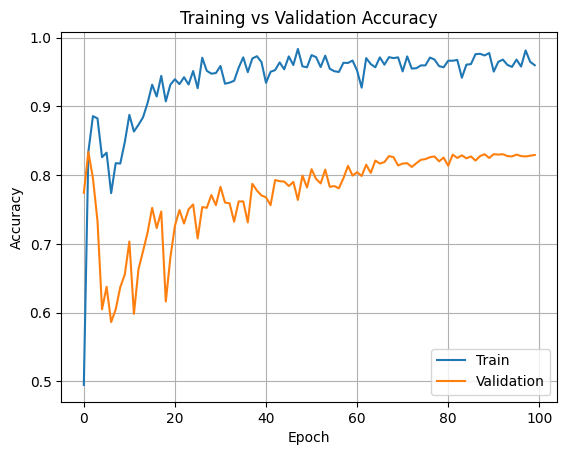

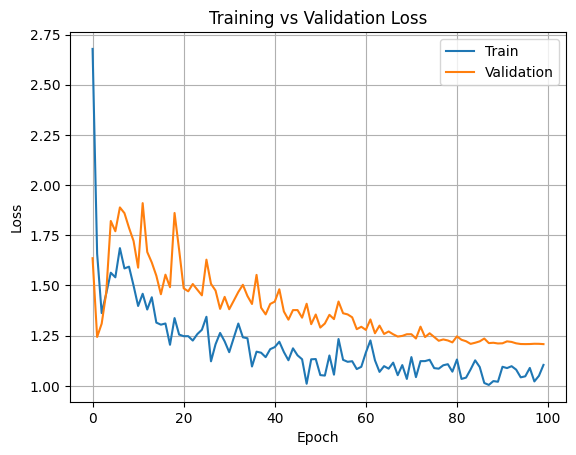

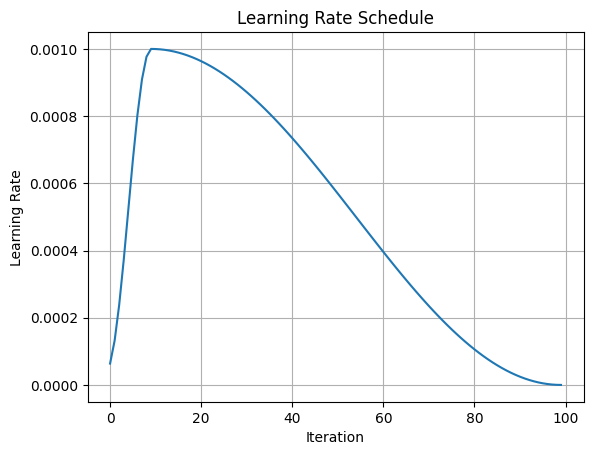

In [ ]:
# ==============================================================================
# Part 2A: Fine-tune ResNet-18
# ==============================================================================

# Setup Model
resnet18_2a = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet18_2a.fc = nn.Linear(resnet18_2a.fc.in_features, train_dataset.get_num_classes())
resnet18_2a = resnet18_2a.to(device)

# Setup Components
config_2a = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=True,
    save_path="best_resnet18_2a.pth",
)
crit_2a, opt_2a, sched_2a, mix_2a = build_training_components(
    resnet18_2a, train_loader, train_dataset, config_2a
)

# Run
test_acc_2a = run_finetuning_stage(
    "ResNet-18 Fine-tuned (Part 2A)",
    resnet18_2a,
    config_2a,
    crit_2a,
    opt_2a,
    sched_2a,
    mix_2a,
)

## Part 2B: Fine-tune ResNet-18 with optimized hyperparameters

**Changes from Part 2A:**
- **Lower learning rate**: Pretrained models benefit from smaller learning rates (1e-4 to 3e-4) to avoid destroying pretrained features
- **Layer-wise learning rate decay**: Lower learning rate for earlier layers, higher for classifier (discriminative fine-tuning)
- **Longer warmup**: Gradual warmup helps stabilize training when fine-tuning
- **Freeze backbone initially** (optional): Train only the classifier first, then unfreeze the backbone

**Justification:**
- Transfer learning best practices suggest using smaller learning rates for pretrained layers (Yosinski et al., "How transferable are features in deep neural networks?", NeurIPS 2014)
- The pretrained features are already well-optimized for image classification; aggressive updates can degrade them


=== Running: ResNet-18 FT Head (Part 2B) ===
Total params: 11,195,493 | Trainable params: 18,981


2026/02/16 09:25:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 2.629, Train Acc: 0.361 | Val Loss: 2.078, Val Acc: 0.646 | LR: 5.45e-05


2026/02/16 09:25:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:25:24 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 09:25:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [2/100] | Train Loss: 1.825, Train Acc: 0.595 | Val Loss: 1.302, Val Acc: 0.782 | LR: 7.94e-04


2026/02/16 09:25:48 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:25:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 09:26:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [3/100] | Train Loss: 1.262, Train Acc: 0.771 | Val Loss: 1.182, Val Acc: 0.816 | LR: 4.22e-04


2026/02/16 09:26:19 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:26:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 09:26:45 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [4/100] | Train Loss: 1.149, Train Acc: 0.790 | Val Loss: 1.029, Val Acc: 0.824 | LR: 3.45e-04


2026/02/16 09:26:49 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:26:57 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 09:27:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [5/100] | Train Loss: 1.023, Train Acc: 0.829 | Val Loss: 1.009, Val Acc: 0.835 | LR: 8.54e-04


2026/02/16 09:27:21 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:27:27 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 09:27:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [6/100] | Train Loss: 0.989, Train Acc: 0.838 | Val Loss: 0.959, Val Acc: 0.840 | LR: 2.45e-05


2026/02/16 09:27:52 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:28:00 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [7/100] | Train Loss: 0.945, Train Acc: 0.853 | Val Loss: 0.967, Val Acc: 0.827 | LR: 9.94e-04


2026/02/16 09:28:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [8/100] | Train Loss: 0.915, Train Acc: 0.859 | Val Loss: 0.929, Val Acc: 0.844 | LR: 9.55e-05


2026/02/16 09:28:38 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:28:44 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [9/100] | Train Loss: 0.894, Train Acc: 0.863 | Val Loss: 0.925, Val Acc: 0.835 | LR: 7.27e-04


2026/02/16 09:29:17 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [10/100] | Train Loss: 0.875, Train Acc: 0.863 | Val Loss: 0.909, Val Acc: 0.855 | LR: 5.00e-04


2026/02/16 09:29:21 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:29:28 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [11/100] | Train Loss: 0.890, Train Acc: 0.857 | Val Loss: 0.912, Val Acc: 0.855 | LR: 2.73e-04


Epoch [12/100] | Train Loss: 0.850, Train Acc: 0.875 | Val Loss: 0.914, Val Acc: 0.840 | LR: 9.05e-04


Epoch [13/100] | Train Loss: 0.875, Train Acc: 0.865 | Val Loss: 0.901, Val Acc: 0.845 | LR: 6.16e-06


Epoch [14/100] | Train Loss: 0.854, Train Acc: 0.874 | Val Loss: 0.892, Val Acc: 0.854 | LR: 9.76e-04


2026/02/16 09:30:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [15/100] | Train Loss: 0.847, Train Acc: 0.874 | Val Loss: 0.895, Val Acc: 0.856 | LR: 1.46e-04


2026/02/16 09:30:46 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:30:53 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [16/100] | Train Loss: 0.840, Train Acc: 0.878 | Val Loss: 0.906, Val Acc: 0.845 | LR: 6.55e-04


Epoch [17/100] | Train Loss: 0.821, Train Acc: 0.887 | Val Loss: 0.898, Val Acc: 0.845 | LR: 5.78e-04


Epoch [18/100] | Train Loss: 0.846, Train Acc: 0.877 | Val Loss: 0.893, Val Acc: 0.852 | LR: 2.06e-04


Epoch [19/100] | Train Loss: 0.812, Train Acc: 0.888 | Val Loss: 0.917, Val Acc: 0.840 | LR: 9.46e-04


Epoch [20/100] | Train Loss: 0.826, Train Acc: 0.881 | Val Loss: 0.891, Val Acc: 0.854 | LR: 0.00e+00


Epoch [21/100] | Train Loss: 0.816, Train Acc: 0.890 | Val Loss: 0.907, Val Acc: 0.847 | LR: 9.46e-04


2026/02/16 09:32:36 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [22/100] | Train Loss: 0.825, Train Acc: 0.884 | Val Loss: 0.884, Val Acc: 0.858 | LR: 2.06e-04


2026/02/16 09:32:41 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:32:48 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [23/100] | Train Loss: 0.820, Train Acc: 0.886 | Val Loss: 0.903, Val Acc: 0.842 | LR: 5.78e-04


Epoch [24/100] | Train Loss: 0.817, Train Acc: 0.881 | Val Loss: 0.886, Val Acc: 0.856 | LR: 6.55e-04


Epoch [25/100] | Train Loss: 0.827, Train Acc: 0.880 | Val Loss: 0.891, Val Acc: 0.856 | LR: 1.46e-04


Epoch [26/100] | Train Loss: 0.807, Train Acc: 0.890 | Val Loss: 0.890, Val Acc: 0.854 | LR: 9.76e-04


Epoch [27/100] | Train Loss: 0.803, Train Acc: 0.892 | Val Loss: 0.899, Val Acc: 0.848 | LR: 6.16e-06


Epoch [28/100] | Train Loss: 0.810, Train Acc: 0.886 | Val Loss: 0.910, Val Acc: 0.845 | LR: 9.05e-04


Epoch [29/100] | Train Loss: 0.796, Train Acc: 0.895 | Val Loss: 0.887, Val Acc: 0.848 | LR: 2.73e-04


Epoch [30/100] | Train Loss: 0.804, Train Acc: 0.890 | Val Loss: 0.898, Val Acc: 0.845 | LR: 5.00e-04


Epoch [31/100] | Train Loss: 0.793, Train Acc: 0.896 | Val Loss: 0.911, Val Acc: 0.849 | LR: 7.27e-04


Epoch [32/100] | Train Loss: 0.817, Train Acc: 0.884 | Val Loss: 0.890, Val Acc: 0.851 | LR: 9.55e-05


Epoch [33/100] | Train Loss: 0.800, Train Acc: 0.895 | Val Loss: 0.928, Val Acc: 0.829 | LR: 9.94e-04


Epoch [34/100] | Train Loss: 0.812, Train Acc: 0.884 | Val Loss: 0.883, Val Acc: 0.854 | LR: 2.45e-05


Epoch [35/100] | Train Loss: 0.790, Train Acc: 0.896 | Val Loss: 0.900, Val Acc: 0.846 | LR: 8.54e-04


Epoch [36/100] | Train Loss: 0.786, Train Acc: 0.900 | Val Loss: 0.884, Val Acc: 0.854 | LR: 3.45e-04


Epoch [37/100] | Train Loss: 0.801, Train Acc: 0.895 | Val Loss: 0.898, Val Acc: 0.846 | LR: 4.22e-04


2026/02/16 09:36:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [38/100] | Train Loss: 0.780, Train Acc: 0.901 | Val Loss: 0.890, Val Acc: 0.858 | LR: 7.94e-04


2026/02/16 09:37:01 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:37:10 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [39/100] | Train Loss: 0.800, Train Acc: 0.888 | Val Loss: 0.878, Val Acc: 0.850 | LR: 5.45e-05


Epoch [40/100] | Train Loss: 0.797, Train Acc: 0.892 | Val Loss: 0.892, Val Acc: 0.847 | LR: 1.00e-03


Epoch [41/100] | Train Loss: 0.784, Train Acc: 0.899 | Val Loss: 0.892, Val Acc: 0.848 | LR: 5.45e-05


Epoch [42/100] | Train Loss: 0.801, Train Acc: 0.894 | Val Loss: 0.905, Val Acc: 0.850 | LR: 7.94e-04


Epoch [43/100] | Train Loss: 0.777, Train Acc: 0.904 | Val Loss: 0.893, Val Acc: 0.845 | LR: 4.22e-04


Epoch [44/100] | Train Loss: 0.801, Train Acc: 0.888 | Val Loss: 0.885, Val Acc: 0.856 | LR: 3.45e-04


Epoch [45/100] | Train Loss: 0.784, Train Acc: 0.901 | Val Loss: 0.909, Val Acc: 0.838 | LR: 8.54e-04


Epoch [46/100] | Train Loss: 0.795, Train Acc: 0.889 | Val Loss: 0.888, Val Acc: 0.848 | LR: 2.45e-05


Epoch [47/100] | Train Loss: 0.788, Train Acc: 0.890 | Val Loss: 0.893, Val Acc: 0.854 | LR: 9.94e-04


Epoch [48/100] | Train Loss: 0.790, Train Acc: 0.898 | Val Loss: 0.878, Val Acc: 0.855 | LR: 9.55e-05


Epoch [49/100] | Train Loss: 0.794, Train Acc: 0.892 | Val Loss: 0.904, Val Acc: 0.845 | LR: 7.27e-04


Epoch [50/100] | Train Loss: 0.779, Train Acc: 0.900 | Val Loss: 0.884, Val Acc: 0.845 | LR: 5.00e-04


Epoch [51/100] | Train Loss: 0.805, Train Acc: 0.888 | Val Loss: 0.883, Val Acc: 0.856 | LR: 2.73e-04


Epoch [52/100] | Train Loss: 0.776, Train Acc: 0.901 | Val Loss: 0.906, Val Acc: 0.846 | LR: 9.05e-04


Epoch [53/100] | Train Loss: 0.802, Train Acc: 0.892 | Val Loss: 0.876, Val Acc: 0.855 | LR: 6.16e-06


Epoch [54/100] | Train Loss: 0.795, Train Acc: 0.892 | Val Loss: 0.885, Val Acc: 0.854 | LR: 9.76e-04


Epoch [55/100] | Train Loss: 0.793, Train Acc: 0.894 | Val Loss: 0.882, Val Acc: 0.846 | LR: 1.46e-04


Epoch [56/100] | Train Loss: 0.801, Train Acc: 0.888 | Val Loss: 0.900, Val Acc: 0.841 | LR: 6.55e-04


Epoch [57/100] | Train Loss: 0.758, Train Acc: 0.906 | Val Loss: 0.882, Val Acc: 0.852 | LR: 5.78e-04


Epoch [58/100] | Train Loss: 0.799, Train Acc: 0.895 | Val Loss: 0.910, Val Acc: 0.837 | LR: 2.06e-04


Epoch [59/100] | Train Loss: 0.791, Train Acc: 0.902 | Val Loss: 0.910, Val Acc: 0.845 | LR: 9.46e-04


Epoch [60/100] | Train Loss: 0.804, Train Acc: 0.888 | Val Loss: 0.899, Val Acc: 0.850 | LR: 0.00e+00


Epoch [61/100] | Train Loss: 0.787, Train Acc: 0.892 | Val Loss: 0.905, Val Acc: 0.844 | LR: 9.46e-04


Epoch [62/100] | Train Loss: 0.789, Train Acc: 0.898 | Val Loss: 0.883, Val Acc: 0.857 | LR: 2.06e-04


Epoch [63/100] | Train Loss: 0.786, Train Acc: 0.898 | Val Loss: 0.901, Val Acc: 0.840 | LR: 5.78e-04


Epoch [64/100] | Train Loss: 0.779, Train Acc: 0.904 | Val Loss: 0.900, Val Acc: 0.845 | LR: 6.55e-04


Epoch [65/100] | Train Loss: 0.795, Train Acc: 0.893 | Val Loss: 0.908, Val Acc: 0.840 | LR: 1.46e-04


Epoch [66/100] | Train Loss: 0.778, Train Acc: 0.899 | Val Loss: 0.908, Val Acc: 0.840 | LR: 9.76e-04


Epoch [67/100] | Train Loss: 0.804, Train Acc: 0.893 | Val Loss: 0.902, Val Acc: 0.841 | LR: 6.16e-06


Epoch [68/100] | Train Loss: 0.786, Train Acc: 0.899 | Val Loss: 0.916, Val Acc: 0.838 | LR: 9.05e-04


Epoch [69/100] | Train Loss: 0.783, Train Acc: 0.897 | Val Loss: 0.897, Val Acc: 0.847 | LR: 2.73e-04


Epoch [70/100] | Train Loss: 0.789, Train Acc: 0.896 | Val Loss: 0.911, Val Acc: 0.842 | LR: 5.00e-04


Epoch [71/100] | Train Loss: 0.785, Train Acc: 0.898 | Val Loss: 0.917, Val Acc: 0.844 | LR: 7.27e-04


Epoch [72/100] | Train Loss: 0.803, Train Acc: 0.892 | Val Loss: 0.899, Val Acc: 0.843 | LR: 9.55e-05


Epoch [73/100] | Train Loss: 0.800, Train Acc: 0.892 | Val Loss: 0.928, Val Acc: 0.836 | LR: 9.94e-04


Epoch [74/100] | Train Loss: 0.798, Train Acc: 0.893 | Val Loss: 0.891, Val Acc: 0.848 | LR: 2.45e-05


Epoch [75/100] | Train Loss: 0.793, Train Acc: 0.891 | Val Loss: 0.919, Val Acc: 0.841 | LR: 8.54e-04


Epoch [76/100] | Train Loss: 0.778, Train Acc: 0.900 | Val Loss: 0.894, Val Acc: 0.847 | LR: 3.45e-04


Epoch [77/100] | Train Loss: 0.790, Train Acc: 0.896 | Val Loss: 0.896, Val Acc: 0.851 | LR: 4.22e-04


Epoch [78/100] | Train Loss: 0.783, Train Acc: 0.901 | Val Loss: 0.910, Val Acc: 0.844 | LR: 7.94e-04


Epoch [79/100] | Train Loss: 0.810, Train Acc: 0.886 | Val Loss: 0.895, Val Acc: 0.847 | LR: 5.45e-05


Epoch [80/100] | Train Loss: 0.787, Train Acc: 0.898 | Val Loss: 0.921, Val Acc: 0.834 | LR: 1.00e-03


Epoch [81/100] | Train Loss: 0.802, Train Acc: 0.889 | Val Loss: 0.890, Val Acc: 0.844 | LR: 5.45e-05


Epoch [82/100] | Train Loss: 0.794, Train Acc: 0.896 | Val Loss: 0.938, Val Acc: 0.836 | LR: 7.94e-04


Epoch [83/100] | Train Loss: 0.776, Train Acc: 0.904 | Val Loss: 0.898, Val Acc: 0.848 | LR: 4.22e-04


Epoch [84/100] | Train Loss: 0.799, Train Acc: 0.891 | Val Loss: 0.901, Val Acc: 0.845 | LR: 3.45e-04


Epoch [85/100] | Train Loss: 0.777, Train Acc: 0.902 | Val Loss: 0.911, Val Acc: 0.842 | LR: 8.54e-04


Epoch [86/100] | Train Loss: 0.799, Train Acc: 0.892 | Val Loss: 0.900, Val Acc: 0.849 | LR: 2.45e-05


Epoch [87/100] | Train Loss: 0.784, Train Acc: 0.899 | Val Loss: 0.934, Val Acc: 0.828 | LR: 9.94e-04


Epoch [88/100] | Train Loss: 0.774, Train Acc: 0.901 | Val Loss: 0.898, Val Acc: 0.848 | LR: 9.55e-05


Epoch [89/100] | Train Loss: 0.804, Train Acc: 0.888 | Val Loss: 0.924, Val Acc: 0.841 | LR: 7.27e-04


Epoch [90/100] | Train Loss: 0.775, Train Acc: 0.903 | Val Loss: 0.899, Val Acc: 0.849 | LR: 5.00e-04


Epoch [91/100] | Train Loss: 0.797, Train Acc: 0.891 | Val Loss: 0.914, Val Acc: 0.840 | LR: 2.73e-04


Epoch [92/100] | Train Loss: 0.797, Train Acc: 0.894 | Val Loss: 0.933, Val Acc: 0.839 | LR: 9.05e-04


Epoch [93/100] | Train Loss: 0.794, Train Acc: 0.892 | Val Loss: 0.908, Val Acc: 0.851 | LR: 6.16e-06


Epoch [94/100] | Train Loss: 0.781, Train Acc: 0.903 | Val Loss: 0.916, Val Acc: 0.847 | LR: 9.76e-04


Epoch [95/100] | Train Loss: 0.783, Train Acc: 0.900 | Val Loss: 0.892, Val Acc: 0.850 | LR: 1.46e-04


Epoch [96/100] | Train Loss: 0.804, Train Acc: 0.887 | Val Loss: 0.911, Val Acc: 0.847 | LR: 6.55e-04


Epoch [97/100] | Train Loss: 0.780, Train Acc: 0.899 | Val Loss: 0.899, Val Acc: 0.850 | LR: 5.78e-04


Epoch [98/100] | Train Loss: 0.818, Train Acc: 0.891 | Val Loss: 0.920, Val Acc: 0.844 | LR: 2.06e-04


Epoch [99/100] | Train Loss: 0.783, Train Acc: 0.898 | Val Loss: 0.925, Val Acc: 0.833 | LR: 9.46e-04


Epoch [100/100] | Train Loss: 0.797, Train Acc: 0.892 | Val Loss: 0.899, Val Acc: 0.853 | LR: 0.00e+00
[ResNet-18 FT Head (Part 2B)] Finished! Best Validation Accuracy: 0.858



[ResNet-18 FT Head (Part 2B)] Test Loss: 0.849 | Test Acc: 0.858


2026/02/16 09:51:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 09:51:42 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:51:49 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run ResNet-18 FT Head (Part 2B) at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/d914af6e94bb45c6b4c21eaf665044fa
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


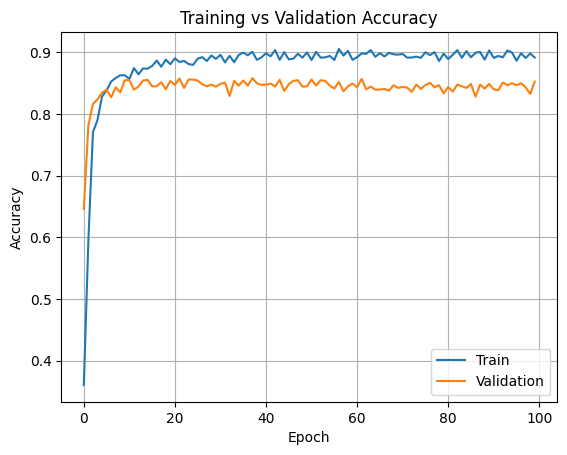

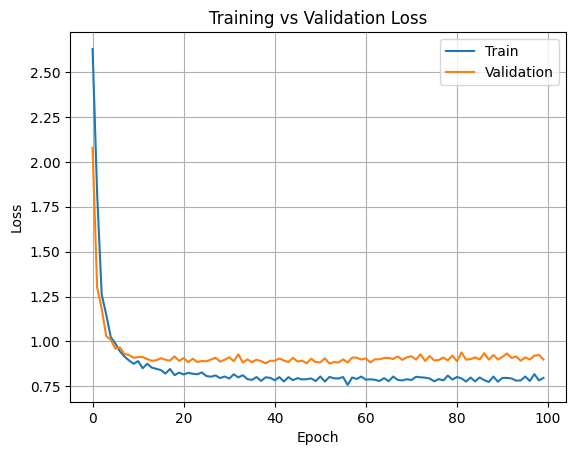

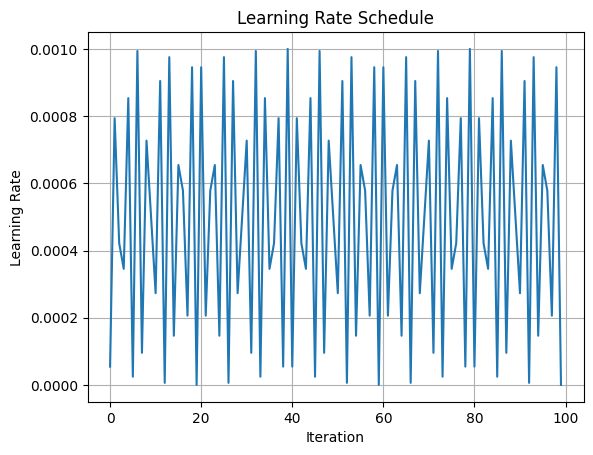

0.8575298190116882

In [ ]:
# ==============================================================================
# Part 2B - Stage 1: Fine-tune only the head (Optimized HPs)
# ==============================================================================

# Setup Model
resnet18_2b = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet18_2b.fc = nn.Sequential(
    nn.Dropout(p=0.4, inplace=False),
    nn.Linear(in_features=512, out_features=train_dataset.get_num_classes(), bias=True),
)
resnet18_2b = resnet18_2b.to(device)

# Freeze base, unfreeze head
resnet18_2b.requires_grad_(False)
resnet18_2b.fc.requires_grad_(True)

# Setup Components
config_2b_head = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=False,
    save_path="best_resnet18_2b_head.pth",
)
config_2b_head.num_epochs = 100

crit_2b = nn.CrossEntropyLoss(label_smoothing=0.05)
opt_fc = torch.optim.AdamW(resnet18_2b.fc.parameters(), lr=1e-3, weight_decay=1e-3)
sched_fc = torch.optim.lr_scheduler.CosineAnnealingLR(opt_fc, T_max=100)

# Run
run_finetuning_stage(
    "ResNet-18 FT Head (Part 2B)",
    resnet18_2b,
    config_2b_head,
    crit_2b,
    opt_fc,
    sched_fc,
    NoMixUp(),
    custom_mlflow_params={"stage": "head_only"},
)


=== Running: ResNet-18 FT Full (Part 2B) ===
Total params: 11,195,493 | Trainable params: 11,195,493


2026/02/16 09:52:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [1/100] | Train Loss: 0.775, Train Acc: 0.901 | Val Loss: 0.867, Val Acc: 0.865 | LR: 5.45e-07


2026/02/16 09:52:15 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:52:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [2/100] | Train Loss: 0.752, Train Acc: 0.907 | Val Loss: 0.859, Val Acc: 0.861 | LR: 7.94e-06


2026/02/16 09:52:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [3/100] | Train Loss: 0.734, Train Acc: 0.917 | Val Loss: 0.858, Val Acc: 0.868 | LR: 4.22e-06


2026/02/16 09:52:59 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:53:06 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


2026/02/16 09:53:26 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [4/100] | Train Loss: 0.724, Train Acc: 0.926 | Val Loss: 0.850, Val Acc: 0.871 | LR: 3.45e-06


2026/02/16 09:53:30 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:53:36 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [5/100] | Train Loss: 0.710, Train Acc: 0.929 | Val Loss: 0.842, Val Acc: 0.870 | LR: 8.54e-06


2026/02/16 09:54:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [6/100] | Train Loss: 0.699, Train Acc: 0.931 | Val Loss: 0.842, Val Acc: 0.876 | LR: 2.45e-07


2026/02/16 09:54:14 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 09:54:21 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [7/100] | Train Loss: 0.692, Train Acc: 0.939 | Val Loss: 0.845, Val Acc: 0.868 | LR: 9.94e-06


Epoch [8/100] | Train Loss: 0.682, Train Acc: 0.938 | Val Loss: 0.843, Val Acc: 0.872 | LR: 9.55e-07


Epoch [9/100] | Train Loss: 0.676, Train Acc: 0.940 | Val Loss: 0.835, Val Acc: 0.869 | LR: 7.27e-06


Epoch [10/100] | Train Loss: 0.662, Train Acc: 0.948 | Val Loss: 0.836, Val Acc: 0.871 | LR: 5.00e-06


Epoch [11/100] | Train Loss: 0.661, Train Acc: 0.946 | Val Loss: 0.830, Val Acc: 0.872 | LR: 2.73e-06


Epoch [12/100] | Train Loss: 0.645, Train Acc: 0.953 | Val Loss: 0.836, Val Acc: 0.868 | LR: 9.05e-06


Epoch [13/100] | Train Loss: 0.642, Train Acc: 0.954 | Val Loss: 0.839, Val Acc: 0.875 | LR: 6.16e-08


Epoch [14/100] | Train Loss: 0.639, Train Acc: 0.956 | Val Loss: 0.835, Val Acc: 0.869 | LR: 9.76e-06


Epoch [15/100] | Train Loss: 0.631, Train Acc: 0.960 | Val Loss: 0.833, Val Acc: 0.875 | LR: 1.46e-06


Epoch [16/100] | Train Loss: 0.624, Train Acc: 0.963 | Val Loss: 0.835, Val Acc: 0.872 | LR: 6.55e-06


Epoch [17/100] | Train Loss: 0.607, Train Acc: 0.969 | Val Loss: 0.832, Val Acc: 0.872 | LR: 5.78e-06


Epoch [18/100] | Train Loss: 0.615, Train Acc: 0.965 | Val Loss: 0.828, Val Acc: 0.874 | LR: 2.06e-06


Epoch [19/100] | Train Loss: 0.619, Train Acc: 0.961 | Val Loss: 0.824, Val Acc: 0.872 | LR: 9.46e-06


Epoch [20/100] | Train Loss: 0.611, Train Acc: 0.962 | Val Loss: 0.830, Val Acc: 0.872 | LR: 0.00e+00


Epoch [21/100] | Train Loss: 0.596, Train Acc: 0.971 | Val Loss: 0.833, Val Acc: 0.872 | LR: 9.46e-06


Epoch [22/100] | Train Loss: 0.598, Train Acc: 0.971 | Val Loss: 0.830, Val Acc: 0.871 | LR: 2.06e-06


Epoch [23/100] | Train Loss: 0.597, Train Acc: 0.966 | Val Loss: 0.825, Val Acc: 0.871 | LR: 5.78e-06


Epoch [24/100] | Train Loss: 0.590, Train Acc: 0.974 | Val Loss: 0.831, Val Acc: 0.870 | LR: 6.55e-06


Epoch [25/100] | Train Loss: 0.589, Train Acc: 0.975 | Val Loss: 0.827, Val Acc: 0.869 | LR: 1.46e-06


Epoch [26/100] | Train Loss: 0.577, Train Acc: 0.979 | Val Loss: 0.821, Val Acc: 0.874 | LR: 9.76e-06


Epoch [27/100] | Train Loss: 0.578, Train Acc: 0.979 | Val Loss: 0.826, Val Acc: 0.870 | LR: 6.16e-08


Epoch [28/100] | Train Loss: 0.575, Train Acc: 0.979 | Val Loss: 0.823, Val Acc: 0.868 | LR: 9.05e-06


Epoch [29/100] | Train Loss: 0.572, Train Acc: 0.981 | Val Loss: 0.823, Val Acc: 0.872 | LR: 2.73e-06


Epoch [30/100] | Train Loss: 0.573, Train Acc: 0.979 | Val Loss: 0.824, Val Acc: 0.871 | LR: 5.00e-06


Epoch [31/100] | Train Loss: 0.563, Train Acc: 0.983 | Val Loss: 0.824, Val Acc: 0.873 | LR: 7.27e-06


Epoch [32/100] | Train Loss: 0.564, Train Acc: 0.982 | Val Loss: 0.829, Val Acc: 0.871 | LR: 9.55e-07


Epoch [33/100] | Train Loss: 0.556, Train Acc: 0.987 | Val Loss: 0.827, Val Acc: 0.872 | LR: 9.94e-06


Epoch [34/100] | Train Loss: 0.555, Train Acc: 0.985 | Val Loss: 0.824, Val Acc: 0.869 | LR: 2.45e-07


Epoch [35/100] | Train Loss: 0.561, Train Acc: 0.983 | Val Loss: 0.822, Val Acc: 0.872 | LR: 8.54e-06


Epoch [36/100] | Train Loss: 0.550, Train Acc: 0.987 | Val Loss: 0.822, Val Acc: 0.875 | LR: 3.45e-06


Epoch [37/100] | Train Loss: 0.557, Train Acc: 0.982 | Val Loss: 0.826, Val Acc: 0.871 | LR: 4.22e-06


Epoch [38/100] | Train Loss: 0.542, Train Acc: 0.990 | Val Loss: 0.823, Val Acc: 0.870 | LR: 7.94e-06


Epoch [39/100] | Train Loss: 0.550, Train Acc: 0.987 | Val Loss: 0.820, Val Acc: 0.870 | LR: 5.45e-07


Epoch [40/100] | Train Loss: 0.542, Train Acc: 0.988 | Val Loss: 0.823, Val Acc: 0.870 | LR: 1.00e-05


Epoch [41/100] | Train Loss: 0.540, Train Acc: 0.989 | Val Loss: 0.829, Val Acc: 0.868 | LR: 5.45e-07


Epoch [42/100] | Train Loss: 0.541, Train Acc: 0.989 | Val Loss: 0.822, Val Acc: 0.872 | LR: 7.94e-06


Epoch [43/100] | Train Loss: 0.536, Train Acc: 0.989 | Val Loss: 0.825, Val Acc: 0.871 | LR: 4.22e-06


Epoch [44/100] | Train Loss: 0.541, Train Acc: 0.988 | Val Loss: 0.820, Val Acc: 0.872 | LR: 3.45e-06


Epoch [45/100] | Train Loss: 0.539, Train Acc: 0.988 | Val Loss: 0.824, Val Acc: 0.874 | LR: 8.54e-06


Epoch [46/100] | Train Loss: 0.536, Train Acc: 0.987 | Val Loss: 0.820, Val Acc: 0.871 | LR: 2.45e-07


Epoch [47/100] | Train Loss: 0.530, Train Acc: 0.991 | Val Loss: 0.824, Val Acc: 0.872 | LR: 9.94e-06


Epoch [48/100] | Train Loss: 0.525, Train Acc: 0.993 | Val Loss: 0.821, Val Acc: 0.869 | LR: 9.55e-07


Epoch [49/100] | Train Loss: 0.526, Train Acc: 0.992 | Val Loss: 0.827, Val Acc: 0.870 | LR: 7.27e-06


Epoch [50/100] | Train Loss: 0.522, Train Acc: 0.993 | Val Loss: 0.825, Val Acc: 0.871 | LR: 5.00e-06


Epoch [51/100] | Train Loss: 0.526, Train Acc: 0.994 | Val Loss: 0.826, Val Acc: 0.866 | LR: 2.73e-06


Epoch [52/100] | Train Loss: 0.522, Train Acc: 0.993 | Val Loss: 0.822, Val Acc: 0.869 | LR: 9.05e-06


Epoch [53/100] | Train Loss: 0.523, Train Acc: 0.992 | Val Loss: 0.822, Val Acc: 0.871 | LR: 6.16e-08


Epoch [54/100] | Train Loss: 0.515, Train Acc: 0.994 | Val Loss: 0.827, Val Acc: 0.866 | LR: 9.76e-06


Epoch [55/100] | Train Loss: 0.517, Train Acc: 0.993 | Val Loss: 0.822, Val Acc: 0.868 | LR: 1.46e-06


Epoch [56/100] | Train Loss: 0.518, Train Acc: 0.993 | Val Loss: 0.819, Val Acc: 0.871 | LR: 6.55e-06


Epoch [57/100] | Train Loss: 0.516, Train Acc: 0.993 | Val Loss: 0.821, Val Acc: 0.874 | LR: 5.78e-06


Epoch [58/100] | Train Loss: 0.513, Train Acc: 0.993 | Val Loss: 0.820, Val Acc: 0.871 | LR: 2.06e-06


Epoch [59/100] | Train Loss: 0.509, Train Acc: 0.994 | Val Loss: 0.824, Val Acc: 0.870 | LR: 9.46e-06


Epoch [60/100] | Train Loss: 0.512, Train Acc: 0.994 | Val Loss: 0.818, Val Acc: 0.872 | LR: 0.00e+00


Epoch [61/100] | Train Loss: 0.508, Train Acc: 0.997 | Val Loss: 0.821, Val Acc: 0.870 | LR: 9.46e-06


Epoch [62/100] | Train Loss: 0.509, Train Acc: 0.995 | Val Loss: 0.821, Val Acc: 0.873 | LR: 2.06e-06


Epoch [63/100] | Train Loss: 0.506, Train Acc: 0.997 | Val Loss: 0.820, Val Acc: 0.870 | LR: 5.78e-06


Epoch [64/100] | Train Loss: 0.506, Train Acc: 0.995 | Val Loss: 0.817, Val Acc: 0.875 | LR: 6.55e-06


Epoch [65/100] | Train Loss: 0.505, Train Acc: 0.995 | Val Loss: 0.820, Val Acc: 0.870 | LR: 1.46e-06


Epoch [66/100] | Train Loss: 0.501, Train Acc: 0.998 | Val Loss: 0.814, Val Acc: 0.870 | LR: 9.76e-06


Epoch [67/100] | Train Loss: 0.506, Train Acc: 0.995 | Val Loss: 0.817, Val Acc: 0.868 | LR: 6.16e-08


Epoch [68/100] | Train Loss: 0.500, Train Acc: 0.996 | Val Loss: 0.819, Val Acc: 0.873 | LR: 9.05e-06


2026/02/16 10:09:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Epoch [69/100] | Train Loss: 0.501, Train Acc: 0.997 | Val Loss: 0.813, Val Acc: 0.876 | LR: 2.73e-06


2026/02/16 10:09:18 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 10:09:25 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Epoch [70/100] | Train Loss: 0.500, Train Acc: 0.996 | Val Loss: 0.825, Val Acc: 0.866 | LR: 5.00e-06


Epoch [71/100] | Train Loss: 0.501, Train Acc: 0.996 | Val Loss: 0.817, Val Acc: 0.870 | LR: 7.27e-06


Epoch [72/100] | Train Loss: 0.501, Train Acc: 0.996 | Val Loss: 0.822, Val Acc: 0.868 | LR: 9.55e-07


Epoch [73/100] | Train Loss: 0.496, Train Acc: 0.998 | Val Loss: 0.817, Val Acc: 0.872 | LR: 9.94e-06


Epoch [74/100] | Train Loss: 0.494, Train Acc: 0.998 | Val Loss: 0.820, Val Acc: 0.868 | LR: 2.45e-07


Epoch [75/100] | Train Loss: 0.493, Train Acc: 0.998 | Val Loss: 0.825, Val Acc: 0.866 | LR: 8.54e-06


Epoch [76/100] | Train Loss: 0.494, Train Acc: 0.997 | Val Loss: 0.819, Val Acc: 0.868 | LR: 3.45e-06


Epoch [77/100] | Train Loss: 0.492, Train Acc: 0.998 | Val Loss: 0.819, Val Acc: 0.869 | LR: 4.22e-06


Epoch [78/100] | Train Loss: 0.493, Train Acc: 0.998 | Val Loss: 0.820, Val Acc: 0.868 | LR: 7.94e-06


Epoch [79/100] | Train Loss: 0.492, Train Acc: 0.998 | Val Loss: 0.822, Val Acc: 0.870 | LR: 5.45e-07


Epoch [80/100] | Train Loss: 0.489, Train Acc: 0.998 | Val Loss: 0.821, Val Acc: 0.868 | LR: 1.00e-05


Epoch [81/100] | Train Loss: 0.488, Train Acc: 0.997 | Val Loss: 0.817, Val Acc: 0.872 | LR: 5.45e-07


Epoch [82/100] | Train Loss: 0.489, Train Acc: 0.997 | Val Loss: 0.825, Val Acc: 0.871 | LR: 7.94e-06


Epoch [83/100] | Train Loss: 0.488, Train Acc: 0.999 | Val Loss: 0.819, Val Acc: 0.870 | LR: 4.22e-06


Epoch [84/100] | Train Loss: 0.488, Train Acc: 0.999 | Val Loss: 0.820, Val Acc: 0.871 | LR: 3.45e-06


Epoch [85/100] | Train Loss: 0.488, Train Acc: 0.998 | Val Loss: 0.820, Val Acc: 0.868 | LR: 8.54e-06


Epoch [86/100] | Train Loss: 0.485, Train Acc: 0.998 | Val Loss: 0.824, Val Acc: 0.868 | LR: 2.45e-07


Epoch [87/100] | Train Loss: 0.488, Train Acc: 0.997 | Val Loss: 0.821, Val Acc: 0.871 | LR: 9.94e-06


Epoch [88/100] | Train Loss: 0.484, Train Acc: 0.998 | Val Loss: 0.818, Val Acc: 0.873 | LR: 9.55e-07


Epoch [89/100] | Train Loss: 0.482, Train Acc: 0.999 | Val Loss: 0.821, Val Acc: 0.870 | LR: 7.27e-06


Epoch [90/100] | Train Loss: 0.483, Train Acc: 0.998 | Val Loss: 0.819, Val Acc: 0.874 | LR: 5.00e-06


Epoch [91/100] | Train Loss: 0.482, Train Acc: 0.998 | Val Loss: 0.821, Val Acc: 0.871 | LR: 2.73e-06


Epoch [92/100] | Train Loss: 0.482, Train Acc: 0.998 | Val Loss: 0.822, Val Acc: 0.872 | LR: 9.05e-06


Epoch [93/100] | Train Loss: 0.483, Train Acc: 0.997 | Val Loss: 0.823, Val Acc: 0.872 | LR: 6.16e-08


Epoch [94/100] | Train Loss: 0.480, Train Acc: 0.997 | Val Loss: 0.823, Val Acc: 0.866 | LR: 9.76e-06


Epoch [95/100] | Train Loss: 0.481, Train Acc: 0.998 | Val Loss: 0.819, Val Acc: 0.870 | LR: 1.46e-06


Epoch [96/100] | Train Loss: 0.480, Train Acc: 0.998 | Val Loss: 0.816, Val Acc: 0.871 | LR: 6.55e-06


Epoch [97/100] | Train Loss: 0.480, Train Acc: 0.998 | Val Loss: 0.817, Val Acc: 0.872 | LR: 5.78e-06


Epoch [98/100] | Train Loss: 0.479, Train Acc: 0.998 | Val Loss: 0.820, Val Acc: 0.871 | LR: 2.06e-06


Epoch [99/100] | Train Loss: 0.476, Train Acc: 0.999 | Val Loss: 0.822, Val Acc: 0.870 | LR: 9.46e-06


Epoch [100/100] | Train Loss: 0.476, Train Acc: 0.998 | Val Loss: 0.819, Val Acc: 0.870 | LR: 0.00e+00
[ResNet-18 FT Full (Part 2B)] Finished! Best Validation Accuracy: 0.876



[ResNet-18 FT Full (Part 2B)] Test Loss: 0.770 | Test Acc: 0.886


2026/02/16 10:16:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


2026/02/16 10:16:46 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.


2026/02/16 10:16:54 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


🏃 View run ResNet-18 FT Full (Part 2B) at: https://mlflow.niccolozanotti.com/#/experiments/5/runs/115c6ea08b73411ba6f5f7d8700e8664
🧪 View experiment at: https://mlflow.niccolozanotti.com/#/experiments/5


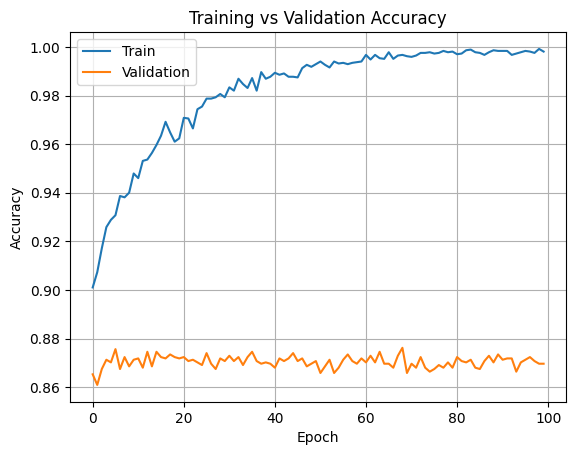

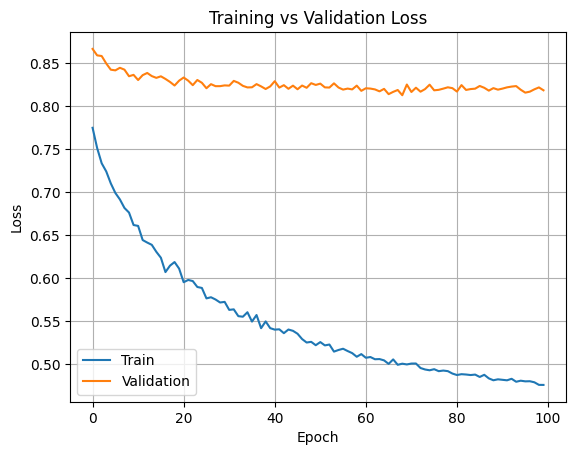

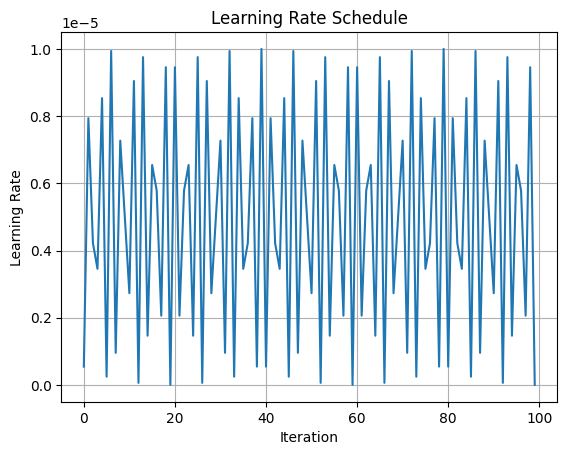

In [ ]:
# ==============================================================================
# Part 2B - Stage 2: Fine-tune all layers (Optimized HPs)
# ==============================================================================

# Unfreeze all layers
resnet18_2b.requires_grad_(True)

# Setup Components
config_2b_full = TrainConfig(
    use_scheduler=True,
    use_label_smoothing=True,
    use_mixup=False,
    save_path="best_resnet18_2b_full.pth",
)
config_2b_full.num_epochs = 100

opt_full = torch.optim.AdamW(resnet18_2b.parameters(), lr=1e-5, weight_decay=1e-3)
sched_full = torch.optim.lr_scheduler.CosineAnnealingLR(opt_full, T_max=100)

# Run
test_acc_2b2 = run_finetuning_stage(
    "ResNet-18 FT Full (Part 2B)",
    resnet18_2b,
    config_2b_full,
    crit_2b,
    opt_full,
    sched_full,
    NoMixUp(),
    custom_mlflow_params={"stage": "full_network"},
)

In [ ]:
# ==============================================================================
# Summary comparison: Part 2A vs Part 2B
# ==============================================================================
print("\n" + "=" * 50)
print("Part 2 Summary: ResNet-18 Fine-tuning Results")
print("=" * 50)
print(f"Part 2A (same hyperparameters as Part 1):")
print(f"  Test Accuracy: {test_acc_2a:.3f}")
print(f"\nPart 2B (optimized hyperparameters for transfer learning):")
print(f"  Test Accuracy: {test_acc_2b2:.3f}")
print(f"\nImprovement: {(test_acc_2b2 - test_acc_2a) * 100:.2f} percentage points")


Part 2 Summary: ResNet-18 Fine-tuning Results
Part 2A (same hyperparameters as Part 1):
  Test Accuracy: 0.865

Part 2B (optimized hyperparameters for transfer learning):
  Test Accuracy: 0.886

Improvement: 2.11 percentage points
